# Fitting Yield Curves: Parametric vs. Machine Learning
##### Group Members : Adith Srinivasan, Dipesh Ghimire, Eric Beechen, Raghav Prakash

In [161]:
from warnings import filterwarnings
filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Loading the necessary data files
treasury_panel = pd.read_excel('../data/treasury_panel_weekly.xlsx')
gsw_yields = pd.read_excel('../data/gsw_yields.xlsx')

# Define column name constants for the dataframes
PANEL_DATE_COL = "quote date"
PANEL_TTM_COL = "ttm"
PANEL_YTM_COL = "ytm"
PANEL_CPN_COL = "cpn rate"

# Convert date columns in both dataframes to datetime objects
treasury_panel[PANEL_DATE_COL] = pd.to_datetime(treasury_panel[PANEL_DATE_COL])
gsw_yields["Date"] = pd.to_datetime(gsw_yields["Date"])

## Question 1: Nelson-Siegel Baseline
Establish the Nelson-Siegel model as a baseline for comparison.

### Question 1(a): Nelson-Siegel Parameter Estimation

We fit the Nelson-Siegel model to a single cross-section by minimizing the sum of squared yield errors. The NS yield curve is defined as:

$$r(\tau) = \beta_0 + \beta_1 \frac{1-e^{-\tau/\lambda}}{\tau/\lambda} + \beta_2 \left(\frac{1-e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}\right)$$

where $\beta_0$ corresponds to level, $\beta_1$ to slope, $\beta_2$ to curvature, and $\lambda$ controls the decay rate.

In [3]:
def ns_loadings(tau: np.ndarray, lam: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute Nelson-Siegel factor loadings.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    lam : float
        Decay parameter (lambda)
        
    Returns:
    --------
    L0, L1, L2 : tuple of arrays
        Factor loadings for level, slope, and curvature
    """
    tau = np.asarray(tau, dtype=float)
    lam = float(lam)
    
    x = tau / lam
    
    # Stable evaluation for small x to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        L1 = np.where(x == 0.0, 1.0, (1.0 - np.exp(-x)) / x)
    
    L2 = L1 - np.exp(-x)
    L0 = np.ones_like(tau)
    
    return L0, L1, L2


def ns_yield(tau: np.ndarray, beta0: float, beta1: float, beta2: float, lam: float) -> np.ndarray:
    """
    Calculate Nelson-Siegel yields for given maturities.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    beta0, beta1, beta2 : float
        NS parameters
    lam : float
        Decay parameter
        
    Returns:
    --------
    yields : array
        Predicted yields
    """
    L0, L1, L2 = ns_loadings(tau, lam)
    return beta0 * L0 + beta1 * L1 + beta2 * L2


def rmse_bps(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate RMSE in basis points.
    
    Parameters:
    -----------
    y_true, y_pred : array-like
        True and predicted yields (in decimal form)
        
    Returns:
    --------
    rmse : float
        Root mean squared error in basis points
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)) * 1e4)


@dataclass(frozen=True)
class NSFitResult:
    """Container for Nelson-Siegel fitting results."""
    beta0: float
    beta1: float
    beta2: float
    lam: float
    rmse_bps: float
    success: bool
    message: str


def fit_ns_yields_sse(
    tau: np.ndarray,
    y: np.ndarray,
    x0: Optional[np.ndarray] = None,
    bounds: Tuple[np.ndarray, np.ndarray] = (
        np.array([-0.10, -0.50, -0.50, 0.05]),
        np.array([0.20, 0.50, 0.50, 10.0])
    ),
    method: str = "L-BFGS-B",
) -> NSFitResult:
    """
    Fit Nelson-Siegel parameters by minimizing sum of squared yield errors.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    y : array-like
        Observed yields (decimal)
    x0 : array-like, optional
        Initial parameter guess [beta0, beta1, beta2, lambda]
    bounds : tuple of arrays
        Lower and upper bounds for parameters
    method : str
        Optimization method
        
    Returns:
    --------
    result : NSFitResult
        Fitted parameters and diagnostics
    """
    tau = np.asarray(tau, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Remove invalid observations
    mask = np.isfinite(tau) & np.isfinite(y) & (tau > 0)
    tau, y = tau[mask], y[mask]
    
    if len(tau) == 0:
        raise ValueError("No valid observations after filtering")
    
    # Generate initial guess if not provided
    if x0 is None:
        # Use market-informed initialization
        long_mask = tau >= np.quantile(tau, 0.8)
        short_mask = tau <= np.quantile(tau, 0.2)
        
        beta0_0 = float(np.median(y[long_mask])) if long_mask.any() else float(np.median(y))
        beta1_0 = float(np.median(y[short_mask]) - beta0_0) if short_mask.any() else 0.0
        beta2_0 = 0.0
        lam_0 = 2.0
        
        x0 = np.array([beta0_0, beta1_0, beta2_0, lam_0], dtype=float)
    
    lo, hi = bounds
    
    # Objective function: sum of squared errors
    def obj(theta: np.ndarray) -> float:
        b0, b1, b2, lam = theta
        yhat = ns_yield(tau, b0, b1, b2, lam)
        err = y - yhat
        return float(np.dot(err, err))
    
    # Optimize
    res = minimize(obj, x0=x0, method=method, bounds=list(zip(lo, hi)))
    
    b0, b1, b2, lam = res.x
    yhat = ns_yield(tau, b0, b1, b2, lam)
    
    return NSFitResult(
        beta0=float(b0),
        beta1=float(b1),
        beta2=float(b2),
        lam=float(lam),
        rmse_bps=rmse_bps(y, yhat),
        success=bool(res.success),
        message=str(res.message),
    )

In [4]:
# Fit the Nelson-Siegel model to the most recent cross-section in the panel
one_date = treasury_panel[PANEL_DATE_COL].max()
cs = treasury_panel.loc[treasury_panel[PANEL_DATE_COL] == one_date].copy()

tau_cs = cs[PANEL_TTM_COL].to_numpy()
y_cs = cs[PANEL_YTM_COL].to_numpy()

# Fit the model
ns1 = fit_ns_yields_sse(tau_cs, y_cs)


# Display the results of the fit
ns1_df = pd.DataFrame({
    'Parameter': [
        "Cross-section date",
        "β₀ (level)",
        "β₁ (slope)",
        "β₂ (curvature)",
        "λ  (decay)",
        "In-sample RMSE (bps)"
    ],
    'Value': [
        one_date.date(),
        f"{ns1.beta0:.6f}",
        f"{ns1.beta1:.6f}",
        f"{ns1.beta2:.6f}",
        f"{ns1.lam:.6f}",
        f"{ns1.rmse_bps:.2f}"
    ]
})

display(ns1_df)

,Parameter,Value
0,Cross-section date,2025-12-31
1,β₀ (level),0.055289
2,β₁ (slope),-0.020012
3,β₂ (curvature),-0.026093
4,λ (decay),3.185387
5,In-sample RMSE (bps),10.11


### Question 1(b): Plot fitted curve and identify systematic errors

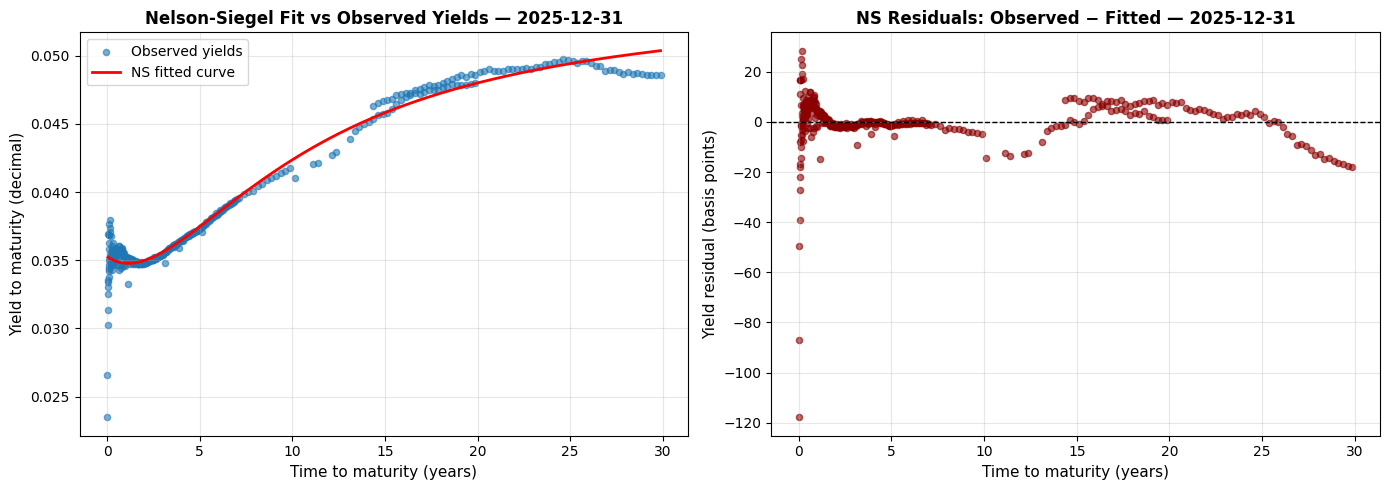

,mean,std,min,max
segment,,,,
Very Short (0-2y),0.674186,14.753580,-117.846379,28.395444
Short (2-5y),-1.116765,1.158164,-9.150484,0.484769
Medium (5-15y),-1.845643,4.410305,-14.449517,9.485271
Long (15-25y),5.105530,2.672297,-0.734536,9.660849
Longest (25y+),-9.481174,6.694938,-18.039458,1.963028


In [5]:
# Plotting observed yields versus fitted yields using the Nelson-Siegel model
tau_grid = np.linspace(max(0.05, np.nanmin(tau_cs)), np.nanmax(tau_cs), 300)
y_grid = ns_yield(tau_grid, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Fitted curve vs observed
ax1.scatter(tau_cs, y_cs, s=20, alpha=0.6, label='Observed yields')
ax1.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax1.set_title(f'Nelson-Siegel Fit vs Observed Yields — {one_date.date()}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: Residuals by maturity
resid = y_cs - ns_yield(tau_cs, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)
ax2.scatter(tau_cs, resid * 1e4, s=20, alpha=0.6, color='darkred')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('Yield residual (basis points)', fontsize=11)
ax2.set_title(f'NS Residuals: Observed − Fitted — {one_date.date()}', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary of residuals by different maturity regions
residuals_df = pd.DataFrame({
    'ttm': tau_cs,
    'residual_bps': resid * 1e4
})

# Define maturity buckets: 0-2, 2-5, 5-15, 15-25, 25+
bucket_edges = [0, 2, 5, 15, 25, float('inf')]
bucket_labels = [
    'Very Short (0-2y)',
    'Short (2-5y)',
    'Medium (5-15y)',
    'Long (15-25y)',
    'Longest (25y+)'
]
residuals_df['segment'] = pd.cut(
    residuals_df['ttm'],
    bins=bucket_edges,
    labels=bucket_labels,
    right=False,  # left-inclusive: ttm >= left, ttm < right
    include_lowest=True
)

stats_df = residuals_df.groupby('segment')['residual_bps'].describe()[['mean', 'std', 'min', 'max']]
stats_df = stats_df.reset_index()
stats_df = stats_df.set_index('segment')
stats_df = stats_df.style.set_caption("Residual statistics by different maturity regions")
display(stats_df)

#### Interpretation of Nelson-Siegel Residuals

The Nelson-Siegel model offers a smooth approximation of the yield curve, but analysis of the residuals reveals clear systematic patterns. The model alternates between over- and under-predicting yields across different maturity ranges:

**Very Short Maturity (0–2y):**
- The mean residual is slightly positive (0.674 bps), but this is misleading given the high volatility. The standard deviation is large (14.75 bps), and the minimum residual is extremely negative (-117.8 bps). This indicates the model tends to over-predict yields for short-term maturities.

**Short to Medium "Belly" (2–15y):**
- In this region, the model consistently over-predicts yields, as shown by negative mean residuals (from -1.11 bps for the 2–5 year segment to -1.84 bps for the 5–15 year segment). The low standard deviation in the 2–5 year bucket (1.15 bps) indicates this over-prediction is systematic: the model's curve sits persistently above actual market yields in this "belly" range.

**Long Maturity (15–25y):**
- The mean residual becomes positive (5.10 bps), signaling that the model now under-predicts yields in this sector. This may reflect added local steepness ("hump") in the market curve not fully captured by the NS model's single curvature parameter (β₂).

**Longest Maturity (25y+):**
- In the ultra-long segment, residuals turn negative again (mean -9.48 bps). Thus, the model over-predicts yields at the longest maturities, failing to flatten as rapidly as observed in market data.

**Systematic vs. Idiosyncratic Errors:**

- *Systematic Errors:* The consistent switching of residuals between negative and positive across the 2–5y, 15–25y, and 25y+ maturities illustrates a structural limitation of the Nelson-Siegel functional form.

- *Idiosyncratic Errors:* The wide dispersion in the 0–2y segment likely results from bond-specific effects (such as the "on-the-run" premium or year-end liquidity factors) that the NS model does not capture.

### Question 1(c): Verify discount factors are positive and decreasing

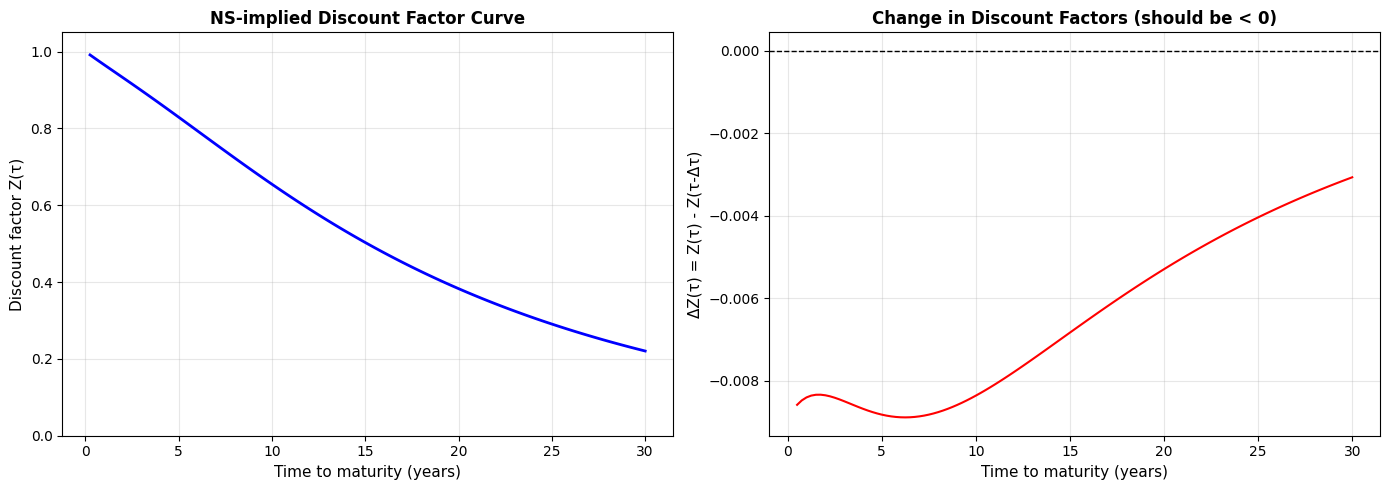

,Check,Result
0,All discount factors positive,True
1,All discount factors decreasing,True
2,Overall verdict,✓


In [6]:
def spot_to_discount(tau: np.ndarray, r: np.ndarray) -> np.ndarray:
    """
    Convert spot (zero-coupon) yields to discount factors.
    
    Z(τ) = exp(-r(τ) × τ)
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    r : array-like
        Spot yields (decimal, continuously compounded)
        
    Returns:
    --------
    Z : array
        Discount factors
    """
    tau = np.asarray(tau, dtype=float)
    r = np.asarray(r, dtype=float)
    return np.exp(-r * tau)


# Generate discount factors on a grid of maturities for further analysis and plotting
tau_dense = np.linspace(0.25, 30, 120) 
r_dense = ns_yield(tau_dense, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)
Z_dense = spot_to_discount(tau_dense, r_dense)

# Check discount factors for financial sanity:
# - Must be strictly positive
# - Must be decreasing with maturity
all_positive = np.all(Z_dense > 0)
all_decreasing = np.all(np.diff(Z_dense) < 0)

df_sanity = pd.DataFrame({
    "Check": [
        "All discount factors positive",
        "All discount factors decreasing",
        "Overall verdict"
    ],
    "Result": [
        all_positive,
        all_decreasing,
        "✓" if all_positive and all_decreasing else "✗"
    ]
})

# Plot discount factor curve and its first differences to visualize behavior and monotonicity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Discount factor curve
ax1.plot(tau_dense, Z_dense, 'b-', linewidth=2)
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Discount factor Z(τ)', fontsize=11)
ax1.set_title('NS-implied Discount Factor Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Right: First differences to check monotonicity
dZ = np.diff(Z_dense)
ax2.plot(tau_dense[1:], dZ, 'r-', linewidth=1.5)
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('ΔZ(τ) = Z(τ) - Z(τ-Δτ)', fontsize=11)
ax2.set_title('Change in Discount Factors (should be < 0)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display the verification results
display(df_sanity)

## Question 2: Hold-Out Validation Framework
Implement cross-validation to measure true out-of-sample performance.

### Question 2(a): Implement train-test split with stratification

In [7]:
def stratified_train_test_split(
    df: pd.DataFrame,
    ttm_col: str,
    test_size: float = 0.2,
    random_state: int = 42,
    n_strata: int = 3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split bonds into train/test sets with stratification by maturity bucket.
    
    Ensures test set spans the entire yield curve by maintaining maturity
    distribution in both train and test sets.
    
    Parameters:
    -----------
    df : DataFrame
        Bond data for a single date
    ttm_col : str
        Column name for time to maturity
    test_size : float
        Proportion of data for test set
    random_state : int
        Random seed for reproducibility
    n_strata : int
        Number of maturity buckets for stratification
        
    Returns:
    --------
    train_df, test_df : tuple of DataFrames
        Training and test sets
    """
    df = df.copy()
    
    # Create maturity strata using quantiles
    df['_maturity_stratum'] = pd.qcut(
        df[ttm_col], 
        q=n_strata, 
        labels=False, 
        duplicates='drop'
    )
    
    # Split within each stratum
    train_indices = []
    test_indices = []
    
    for stratum in df['_maturity_stratum'].unique():
        stratum_mask = df['_maturity_stratum'] == stratum
        stratum_indices = df[stratum_mask].index.tolist()
        
        # Split this stratum
        n_test = max(1, int(len(stratum_indices) * test_size))
        np.random.seed(random_state)
        test_idx = np.random.choice(stratum_indices, size=n_test, replace=False)
        train_idx = [i for i in stratum_indices if i not in test_idx]
        
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)
    
    train_df = df.loc[train_indices].drop('_maturity_stratum', axis=1)
    test_df = df.loc[test_indices].drop('_maturity_stratum', axis=1)
    
    return train_df, test_df


# Perform stratified train-test split on a single cross-section
train_cs, test_cs = stratified_train_test_split(
    cs, 
    ttm_col=PANEL_TTM_COL,
    test_size=0.2,
    random_state=42,
    n_strata=3
)

# Summary DataFrames of stratified train-test split
count_data = {
    "Metric": [
        "Total bonds",
        "Training bonds",
        "Test bonds"
    ],
    "Value": [
        len(cs),
        f"{len(train_cs)} ({100*len(train_cs)/len(cs):.1f}%)",
        f"{len(test_cs)} ({100*len(test_cs)/len(cs):.1f}%)"
    ]
}

count_summary_df = pd.DataFrame(count_data)
count_summary_df = count_summary_df.set_index("Metric")
count_summary_df = count_summary_df.style.set_caption(f"Bond counts for {one_date.date()}")

# TTM (maturity) distribution summary
dist_data = {
    "Set": ["Train", "Test"],
    "Min (y)": [
        f"{train_cs[PANEL_TTM_COL].min():.2f}",
        f"{test_cs[PANEL_TTM_COL].min():.2f}",
    ],
    "Median (y)": [
        f"{train_cs[PANEL_TTM_COL].median():.2f}",
        f"{test_cs[PANEL_TTM_COL].median():.2f}",
    ],
    "Max (y)": [
        f"{train_cs[PANEL_TTM_COL].max():.2f}",
        f"{test_cs[PANEL_TTM_COL].max():.2f}",
    ]
}

dist_summary_df = pd.DataFrame(dist_data)
dist_summary_df = dist_summary_df.set_index("Set")
dist_summary_df = dist_summary_df.style.set_caption(f"Maturity distribution for {one_date.date()}")

display(count_summary_df, dist_summary_df)

,Value
Metric,
Total bonds,401
Training bonds,322 (80.3%)
Test bonds,79 (19.7%)


,Min (y),Median (y),Max (y)
Set,,,
Train,0.02,3.04,29.87
Test,0.04,2.83,28.37


### Question 2(b): Fit on training set, evaluate on test set

In [19]:
# Fit NS on training data only and evaluate on test set
tau_train = train_cs[PANEL_TTM_COL].to_numpy()
y_train = train_cs[PANEL_YTM_COL].to_numpy()

tau_test = test_cs[PANEL_TTM_COL].to_numpy()
y_test = test_cs[PANEL_YTM_COL].to_numpy()

# Fit model
ns_train = fit_ns_yields_sse(tau_train, y_train)

# Predict on test set
y_test_pred = ns_yield(tau_test, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)
test_rmse = rmse_bps(y_test, y_test_pred)

# Calculate overfitting ratio
overfit_ratio = test_rmse / ns_train.rmse_bps

# Display results
results_data = {
    "Metric": ["Training RMSE (bps)", "Test RMSE (bps)", "Test/Train ratio"],
    "Value": [
        f"{ns_train.rmse_bps:.2f}",
        f"{test_rmse:.2f}",
        f"{overfit_ratio:.3f}"
    ]
}
results_df = pd.DataFrame(results_data).set_index("Metric")
results_styled = results_df.style.set_caption(f"Hold-out validation results for {one_date.date()}")
display(results_styled)

,Value
Metric,
Training RMSE (bps),10.70
Test RMSE (bps),7.21
Test/Train ratio,0.674


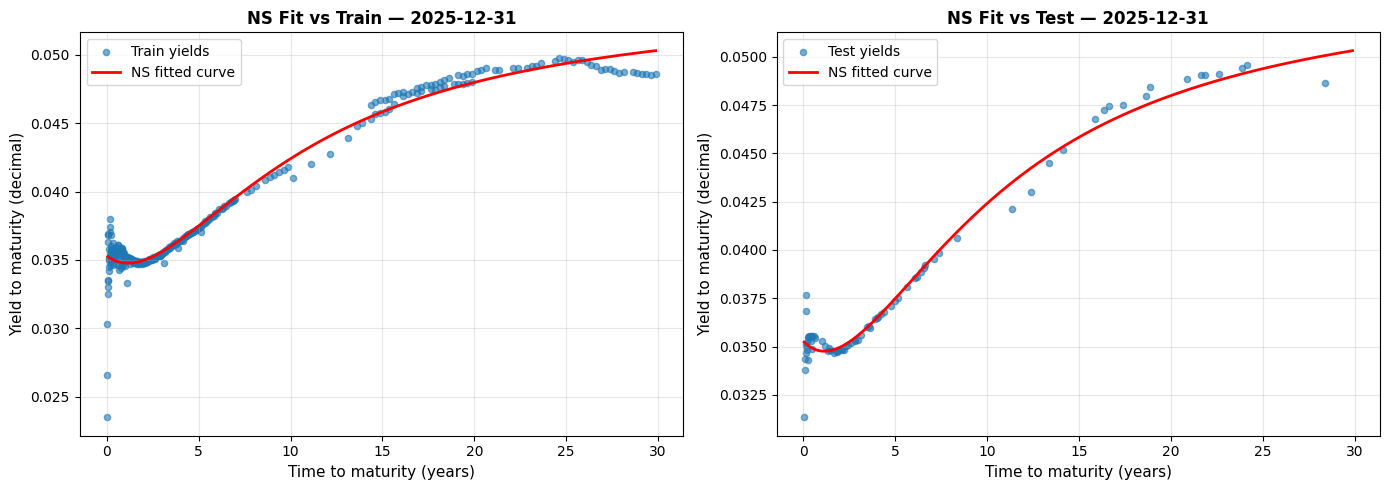

In [ ]:
# Plot fitted NS curve vs train and vs test
tau_min = max(0.05, min(np.nanmin(tau_train), np.nanmin(tau_test)))
tau_max = max(np.nanmax(tau_train), np.nanmax(tau_test))
tau_grid = np.linspace(tau_min, tau_max, 300)
y_grid = ns_yield(tau_grid, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: fitted curve vs training yields
ax1.scatter(tau_train, y_train, s=20, alpha=0.6, label='Train yields')
ax1.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax1.set_title(f'NS Fit vs Train — {one_date.date()}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: same fitted curve vs test yields
ax2.scatter(tau_test, y_test, s=20, alpha=0.6, label='Test yields')
ax2.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax2.set_title(f'NS Fit vs Test — {one_date.date()}', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Question 2(c): Repeat with multiple random seeds

In [9]:
# Repeat train/test split with multiple seeds
n_splits = 10
random_seeds = range(42, 42 + n_splits)

split_results = []

for seed in random_seeds:
    # Split data
    train_cs_i, test_cs_i = stratified_train_test_split(
        cs,
        ttm_col=PANEL_TTM_COL,
        test_size=0.2,
        random_state=seed,
        n_strata=3
    )
    
    # Fit on training
    tau_train_i = train_cs_i[PANEL_TTM_COL].to_numpy()
    y_train_i = train_cs_i[PANEL_YTM_COL].to_numpy()
    ns_fit_i = fit_ns_yields_sse(tau_train_i, y_train_i)
    
    # Predict on test
    tau_test_i = test_cs_i[PANEL_TTM_COL].to_numpy()
    y_test_i = test_cs_i[PANEL_YTM_COL].to_numpy()
    y_test_pred_i = ns_yield(tau_test_i, ns_fit_i.beta0, ns_fit_i.beta1, ns_fit_i.beta2, ns_fit_i.lam)
    test_rmse_i = rmse_bps(y_test_i, y_test_pred_i)
    
    split_results.append({
        'seed': seed,
        'train_rmse': ns_fit_i.rmse_bps,
        'test_rmse': test_rmse_i,
        'ratio': test_rmse_i / ns_fit_i.rmse_bps,
        'beta0': ns_fit_i.beta0,
        'beta1': ns_fit_i.beta1,
        'beta2': ns_fit_i.beta2,
        'lambda': ns_fit_i.lam
    })

split_df = pd.DataFrame(split_results)

# Display test RMSE statistics in a DataFrame with caption
rmse_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Std', 'Min', 'Max', 'Median'],
    'Test RMSE (bps)': [
        split_df['test_rmse'].mean(),
        split_df['test_rmse'].std(),
        split_df['test_rmse'].min(),
        split_df['test_rmse'].max(),
        split_df['test_rmse'].median()
    ]
})

rmse_stats_styled = rmse_stats.style.set_caption(f'Nelson-Siegel Test RMSE statistics across {n_splits} random train/test splits')
display(rmse_stats_styled)

,Statistic,Test RMSE (bps)
0,Mean,9.918578
1,Std,3.482136
2,Min,5.639540
3,Max,14.779686
4,Median,8.741285


#### Is NS Performance Stable?

Yes, the performance is generally stable, but with a few important nuances:

- **Low Absolute Variation:**  
  A standard deviation of 3.48 bps is relatively small. It indicates that the model's accuracy doesn't fluctuate wildly just because different bonds were chosen for the training set.

- **Consistency of the Mean:**  
  The mean RMSE (9.92 bps) is close to the median (8.74 bps), suggesting that the distribution of errors is not heavily skewed by extreme outliers in the testing process.

- **Impact of Idiosyncratic Noise:**  
Since each split contains the same proportion of short, medium, and long-term bonds, the variation in RMSE is likely driven by idiosyncratic pricing. Specifically, the "Very Short" segment (0-2y) has a massive standard deviation of 14.75 bps and a minimum residual of -117.85 bps. If specific high-noise securities (highly illiquid off-the-run instrument) fall into the test set, they will pull the RMSE higher, even if the maturity distribution is perfectly balanced.

**Conclusion:**  
> The Nelson-Siegel model demonstrates good stability across 10 random train/test splits. With a mean test RMSE of 9.92 bps and a relatively low standard deviation of 3.48 bps. The model's predictive power is consistent across different random seed. The moderate range in RMSE suggests that the functional form for Nelson-Siegel is stable.

### Question 2(d): Time-series analysis across market regimes

In [10]:
# Select all the dates spanning different regimes
all_dates = treasury_panel[PANEL_DATE_COL].unique()
all_dates = pd.to_datetime(all_dates)
all_dates = np.sort(all_dates)

# Take every 4th week to get ~100 dates across 2018-2025
date_sample = all_dates[::4][:min(100, len(all_dates)//4)]

# Start and end dates for the analysis
start_str = pd.Timestamp(date_sample[0]).date()
end_str = pd.Timestamp(date_sample[-1]).date()

# === Fit NS with hold-out validation for each date ===
ts_results = []

for date in date_sample:
    df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == date].copy()

    if len(df_date) < 30:  # Skip dates with too few bonds
        continue

    # Train/test split
    try:
        train_df, test_df = stratified_train_test_split(
            df_date,
            ttm_col=PANEL_TTM_COL,
            test_size=0.2,
            random_state=42,
            n_strata=3
        )
    except Exception:
        continue  # Skip if stratification fails

    # Fit on training set
    tau_train = train_df[PANEL_TTM_COL].to_numpy()
    y_train = train_df[PANEL_YTM_COL].to_numpy()

    try:
        ns_fit = fit_ns_yields_sse(tau_train, y_train)
    except Exception:
        continue

    # Evaluate on test set
    tau_test = test_df[PANEL_TTM_COL].to_numpy()
    y_test = test_df[PANEL_YTM_COL].to_numpy()
    y_test_pred = ns_yield(tau_test, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam)
    test_rmse = rmse_bps(y_test, y_test_pred)

    # Calculate additional diagnostics
    curve_level = ns_fit.beta0  # Long-run level
    curve_slope = ns_fit.beta1  # Short-term component (negative = inverted)
    curve_curvature = ns_fit.beta2

    # Volatility proxy: standard deviation of yields
    yield_vol = np.std(y_train)

    # Curve shape metrics
    short_yield = np.median(y_train[tau_train <= 2]) if np.any(tau_train <= 2) else np.nan
    long_yield = np.median(y_train[tau_train >= 10]) if np.any(tau_train >= 10) else np.nan
    slope_2s10s = long_yield - short_yield if not np.isnan(long_yield) and not np.isnan(short_yield) else np.nan

    ts_results.append({
        'date': date,
        'train_rmse': ns_fit.rmse_bps,
        'test_rmse': test_rmse,
        'ratio': test_rmse / ns_fit.rmse_bps if ns_fit.rmse_bps > 0 else np.nan,
        'n_bonds': len(df_date),
        'n_train': len(train_df),
        'n_test': len(test_df),
        'beta0': ns_fit.beta0,
        'beta1': ns_fit.beta1,
        'beta2': ns_fit.beta2,
        'lambda': ns_fit.lam,
        'yield_level': curve_level,
        'yield_slope': curve_slope,
        'yield_vol': yield_vol,
        'slope_2s10s': slope_2s10s
    })

ts_df = pd.DataFrame(ts_results)

# Display summary
summary_stats = ts_df['test_rmse'].describe().to_frame().reset_index()
summary_stats.columns = ['Statistic', 'Test RMSE (bps)']
caption_text = f"Nelson-Siegel Test RMSE Statistics Across {len(ts_df)} Dates ({start_str} to {end_str})"
display(summary_stats.style.set_caption(caption_text))

,Statistic,Test RMSE (bps)
0,count,100.000000
1,mean,15.160141
2,std,14.918310
3,min,3.763350
4,25%,8.186562
5,50%,11.237994
6,75%,15.514918
7,max,98.328227


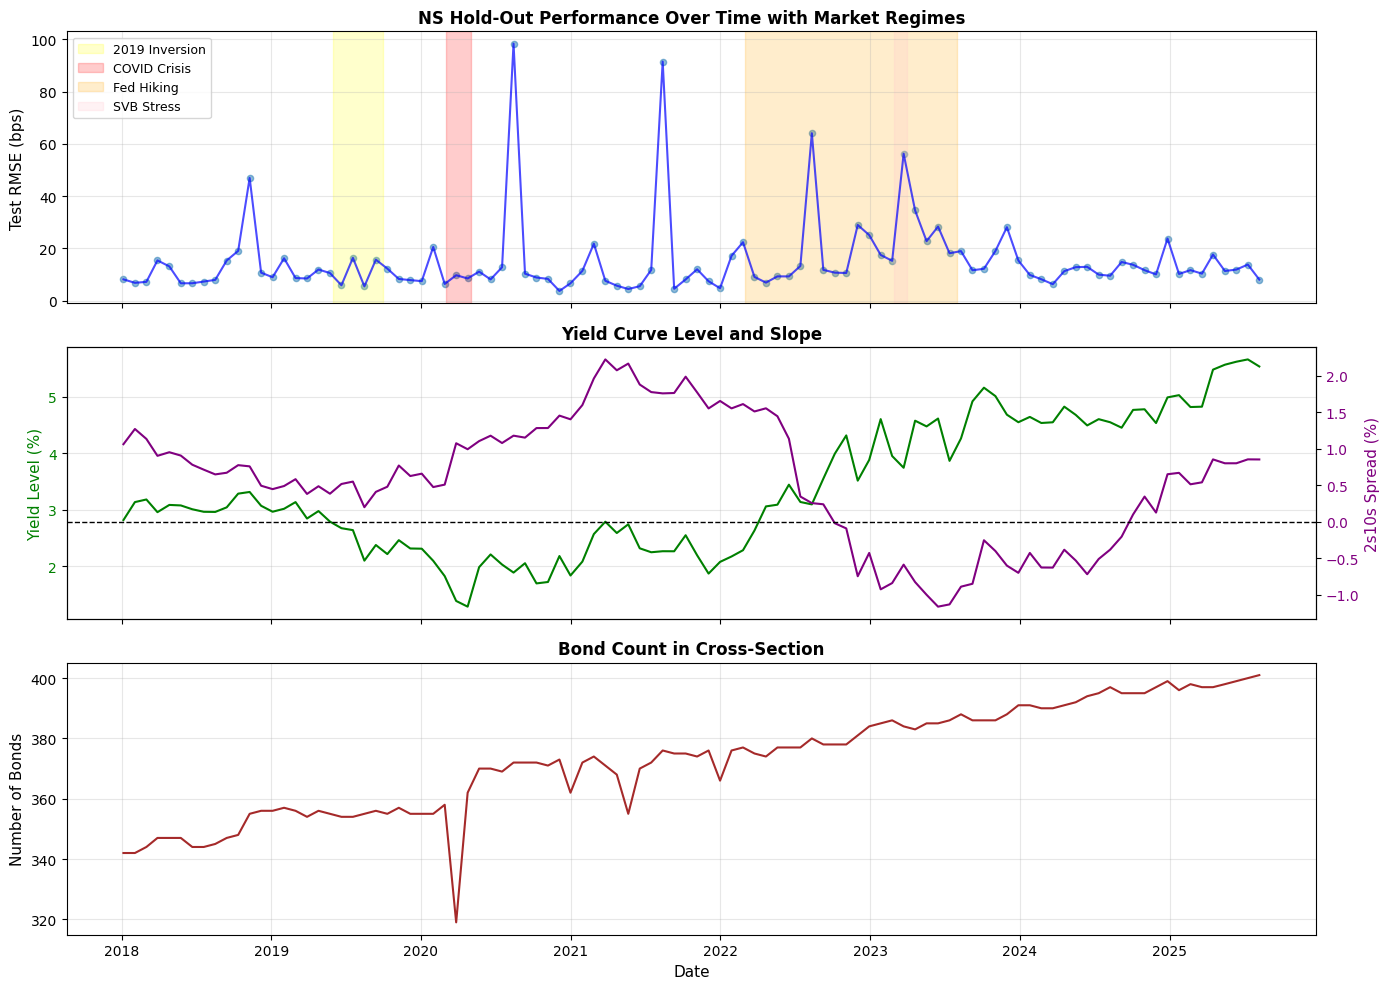

In [11]:
# Plot test RMSE over time with various regime annotations
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Test RMSE over time
ax = axes[0]
ax.plot(ts_df['date'], ts_df['test_rmse'], 'b-', linewidth=1.5, alpha=0.7)
ax.scatter(ts_df['date'], ts_df['test_rmse'], s=20, alpha=0.5)

# Add regime annotations
regime_periods = [
    ('2019-06-01', '2019-10-01', '2019 Inversion', 'yellow'),
    ('2020-03-01', '2020-05-01', 'COVID Crisis', 'red'),
    ('2022-03-01', '2023-08-01', 'Fed Hiking', 'orange'),
    ('2023-03-01', '2023-04-01', 'SVB Stress', 'pink'),
]

for start, end, label, color in regime_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color, label=label)

ax.set_ylabel('Test RMSE (bps)', fontsize=11)
ax.set_title('NS Hold-Out Performance Over Time with Market Regimes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Yield level and slope
ax = axes[1]
ax.plot(ts_df['date'], ts_df['yield_level'] * 100, 'g-', linewidth=1.5, label='Level (β₀)')
ax.set_ylabel('Yield Level (%)', fontsize=11, color='g')
ax.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(ts_df['date'], ts_df['slope_2s10s'] * 100, 'purple', linewidth=1.5, label='2s10s Spread')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('2s10s Spread (%)', fontsize=11, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax.set_title('Yield Curve Level and Slope', fontsize=12, fontweight='bold')

# Panel 3: Number of bonds available
ax = axes[2]
ax.plot(ts_df['date'], ts_df['n_bonds'], 'brown', linewidth=1.5)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Number of Bonds', fontsize=11)
ax.set_title('Bond Count in Cross-Section', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Identify periods with highest fitting difficulty
# We define "hard to fit" as top quartile of test RMSE
hard_threshold = ts_df['test_rmse'].quantile(0.75)
hard_periods = ts_df[ts_df['test_rmse'] > hard_threshold].copy()

# Top 10 hardest dates DataFrame
hardest_df = hard_periods.nlargest(10, 'test_rmse')[['date', 'test_rmse', 'yield_level', 'slope_2s10s', 'yield_vol', 'n_bonds']].reset_index(drop=True)
hardest_df_styled = hardest_df.style.set_caption(
    f"Top 10 hardest periods to fit (test RMSE > {hard_threshold:.2f} bps)")

# Create summary DataFrame for characteristics
summary_data = [
    ["Average test RMSE (bps)",    f"{hard_periods['test_rmse'].mean():.2f}", f"{ts_df['test_rmse'].mean():.2f}"],
    ["Average yield volatility",   f"{hard_periods['yield_vol'].mean():.6f}", f"{ts_df['yield_vol'].mean():.6f}"],
    ["Average yield level (%)",    f"{hard_periods['yield_level'].mean()*100:.3f}", f"{ts_df['yield_level'].mean()*100:.3f}"],
    ["Average 2s10s spread (%)",  f"{hard_periods['slope_2s10s'].mean()*100:.3f}", f"{ts_df['slope_2s10s'].mean()*100:.3f}"],
    ["Average bond count",         f"{hard_periods['n_bonds'].mean():.0f}", f"{ts_df['n_bonds'].mean():.0f}"],
]
summary_df = pd.DataFrame(summary_data, columns=['Statistic', 'Hard-to-Fit Periods', 'Overall Avg'])
summary_df_styled = summary_df.style.set_caption("Characteristics of Hard-to-Fit Periods")

# Correlation analysis DataFrame
corr_vars = ['yield_level', 'yield_vol', 'slope_2s10s', 'n_bonds']
corr_results = []
for var in corr_vars:
    corr = ts_df[['test_rmse', var]].corr().iloc[0, 1]
    corr_results.append([f"Corr(test_rmse, {var})", corr])
corr_df = pd.DataFrame(corr_results, columns=["Variable", "Correlation"])
corr_df_styled = corr_df.style.set_caption("Correlation of test RMSE with Market Conditions")

# Display DataFrames
display(hardest_df_styled)
display(summary_df_styled)
display(corr_df_styled)

,date,test_rmse,yield_level,slope_2s10s,yield_vol,n_bonds
0,2020-08-14 00:00:00,98.328227,0.018899,0.011809,0.004233,372
1,2021-08-13 00:00:00,91.475644,0.022677,0.017611,0.006403,376
2,2022-08-12 00:00:00,64.081717,0.030960,0.002557,0.003287,380
3,2023-03-24 00:00:00,56.239655,0.037436,-0.005888,0.004132,384
4,2018-11-09 00:00:00,46.981227,0.033154,0.007598,0.003321,355
5,2023-04-21 00:00:00,34.559176,0.045760,-0.008278,0.004884,383
6,2022-12-02 00:00:00,28.998024,0.035157,-0.007478,0.004007,381
7,2023-06-16 00:00:00,28.386787,0.046138,-0.011651,0.005411,385
8,2023-12-01 00:00:00,28.146076,0.046821,-0.006021,0.004318,388
9,2022-12-30 00:00:00,25.125777,0.038825,-0.004282,0.003828,384


,Statistic,Hard-to-Fit Periods,Overall Avg
0,Average test RMSE (bps),31.59,15.16
1,Average yield volatility,0.004351,0.004260
2,Average yield level (%),3.549,3.351
3,Average 2s10s spread (%),0.183,0.574
4,Average bond count,376,373


,Variable,Correlation
0,"Corr(test_rmse, yield_level)",0.009837
1,"Corr(test_rmse, yield_vol)",0.027538
2,"Corr(test_rmse, slope_2s10s)",-0.117619
3,"Corr(test_rmse, n_bonds)",0.131797


#### Analysis of Nelson-Siegel Fitting Difficulty
 
The fitting difficulty of the Nelson-Siegel model varies across market regimes, as shown by comparisons between "hard-to-fit" periods and overall averages:
 
**High RMSE periods are characterized by:**
 
- **Lower Yield Spreads (Flat or Inverted Curves):**  
   The "hard-to-fit" periods exhibit a much lower average 2s10s spread (0.183%) compared to the overall average (0.574%). This demonstrates that the Nelson-Siegel functional form struggles significantly when the yield curve flattens or inverts.
 
- **Elevated Market Stress:**  
   The average test RMSE for these challenging periods is 31.59 bps, more than double the overall average of 15.16 bps.
 
#### Key Regime Observations from the Top 10 Hardest Dates
 
- **Post-Pandemic Recovery (2020-08-14):**  
   This is the most difficult period to fit, with a substantial test RMSE of 98.33 bps. Despite a relatively normal slope, high idiosyncratic volatility during the COVID-19 recovery phase likely created extreme pricing dispersions.
   
- **Post-Pandemic Inflation Repricing (2021-08-13):**  
   The second hardest date (RMSE 91.48 bps) saw the highest cross-sectional yield volatility in the top 10 (0.0064), illustrating that the rapid repricing of inflation expectations introduces noise that the smooth NS curve cannot capture.
   
- **The 2022-2023 Inversion/Hiking Cycle:**  
   Seven of the ten hardest dates occur during the aggressive Fed hiking cycle. These dates (e.g., 2023-03-24 during the SVB crisis and 2023-06-16) are characterized by negative 2s10s slopes.
   
- **Late 2018 Volatility:**  
   The inclusion of 2018-11-09 (RMSE 46.98 bps) aligns with the period of quantitative tightening and growth concerns preceding the 2019 Fed pivot.
 
- **Bond Availability:** 
   Interestingly, the "hard-to-fit" periods have a slightly higher average bond count (376) than the overall average (373). This suggests that fitting difficulty is driven more by market volatility and curve shape than by a lack of data points.

## Question 3: ML Alternatives
Compare machine learning methods to Nelson-Siegel using the same out-of-sample framework.

In [23]:
# ML Feature Engineering
def create_ml_features(tau: np.ndarray, cpn: Optional[np.ndarray] = None, 
                       degree: int = 3, include_ns_features: bool = True) -> np.ndarray:
    """
    Create feature matrix for ML models.
    
    Features include:
    - Polynomial terms of maturity (tau, tau^2, ..., tau^degree)
    - NS-like basis functions (optional)
    - Coupon rate (optional)
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    cpn : array-like, optional
        Coupon rates (decimal)
    degree : int
        Degree of polynomial features
    include_ns_features : bool
        Whether to include NS-like loadings as features
        
    Returns:
    --------
    X : array
        Feature matrix (n_bonds, n_features)
    """
    tau = np.asarray(tau, dtype=float).reshape(-1, 1)
    
    # Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(tau)
    
    features = [X_poly]
    
    # NS-like basis functions (with fixed lambda)
    if include_ns_features:
        lam = 2.0  # Fixed decay parameter
        L0, L1, L2 = ns_loadings(tau.flatten(), lam)
        X_ns = np.column_stack([L0, L1, L2])
        features.append(X_ns)
    
    # Coupon effect
    if cpn is not None:
        cpn = np.asarray(cpn, dtype=float).reshape(-1, 1)
        features.append(cpn)
    
    X = np.hstack(features)
    
    return X


# === ML Model Fitting Functions ===
@dataclass(frozen=True)
class MLFitResult:
    """Container for ML model fitting results."""
    model_name: str
    train_rmse: float
    test_rmse: float
    ratio: float
    model: object # Fitted sklearn model
    params: Dict  # Hyperparameters used


def fit_ridge_cv(X_train: np.ndarray, y_train: np.ndarray, 
                 X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Ridge regression with cross-validated regularization parameter.
    
    Ridge adds L2 penalty to prevent overfitting in high-dimensional feature space.
    """
    # Grid search for optimal alpha
    alphas = np.logspace(-4, 4, 50)
    ridge = Ridge()
    
    grid_search = GridSearchCV(
        ridge, 
        param_grid={'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Ridge',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params={'alpha': grid_search.best_params_['alpha']}
    )


def fit_lasso_cv(X_train: np.ndarray, y_train: np.ndarray,
                 X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Lasso regression with cross-validated regularization parameter.
    
    Lasso adds L1 penalty, performing feature selection by shrinking some coefficients to zero.
    """
    alphas = np.logspace(-2.5, 4, 50)
    lasso = Lasso(max_iter=5000)
    
    grid_search = GridSearchCV(
        lasso,
        param_grid={'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    # Count non-zero coefficients (features selected)
    n_nonzero = np.sum(np.abs(best_model.coef_) > 1e-10)
    
    return MLFitResult(
        model_name='Lasso',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params={'alpha': grid_search.best_params_['alpha'], 'n_features_selected': n_nonzero}
    )


def fit_random_forest_cv(X_train: np.ndarray, y_train: np.ndarray,
                         X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Random Forest with cross-validated hyperparameters.
    
    Random Forest can capture non-linear patterns through ensemble of decision trees.
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [1, 3, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf,
        param_grid=param_grid,
        cv=3,  # Fewer folds due to computational cost
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Random Forest',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params=grid_search.best_params_
    )


def fit_gradient_boosting_cv(X_train: np.ndarray, y_train: np.ndarray,
                             X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Gradient Boosting with cross-validated hyperparameters.
    
    Gradient Boosting builds trees sequentially to correct errors of previous trees.
    """
    param_grid = {
        'n_estimators': [30, 50, 100, 200],
        'max_depth': [2, 3, 5, 7, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [1, 3, 5, 10],
        'subsample': [0.7, 0.8, 0.9, 1.0],
    }
    
    gb = GradientBoostingRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        gb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Gradient Boosting',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params=grid_search.best_params_
    )

### Question 3(a): Apply same hold-out validation framework
Fitting all models on 2025-12-31 with identical train/test split


In [24]:
# Use the same train/test split from Question 2
tau_train = train_cs[PANEL_TTM_COL].to_numpy()
y_train = train_cs[PANEL_YTM_COL].to_numpy()
cpn_train = train_cs[PANEL_CPN_COL].to_numpy()

tau_test = test_cs[PANEL_TTM_COL].to_numpy()
y_test = test_cs[PANEL_YTM_COL].to_numpy()
cpn_test = test_cs[PANEL_CPN_COL].to_numpy()

# Create features
X_train = create_ml_features(tau_train, cpn=cpn_train, degree=3, include_ns_features=True)
X_test = create_ml_features(tau_test, cpn=cpn_test, degree=3, include_ns_features=True)

# NS baseline (already fitted)
ns_baseline_df = pd.DataFrame({
    "Metric": ["Training RMSE (bps)", "Test RMSE (bps)", "Train/Test Ratio"],
    "Value": [f"{ns_train.rmse_bps:8.2f}", f"{test_rmse:8.2f}", f"{test_rmse/ns_train.rmse_bps:8.3f}"]
})

ns_baseline_df = ns_baseline_df.set_index("Metric")
ns_baseline_df = ns_baseline_df.style.set_caption("Nelson-Siegel (Baseline)")
display(ns_baseline_df)

# Fit ML models
ml_results = {}

# Ridge
ridge_result = fit_ridge_cv(X_train, y_train, X_test, y_test)
ml_results['Ridge'] = ridge_result


ridge_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{ridge_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{ridge_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{ridge_result.ratio:8.3f}"],
    "Best alpha": [f"{ridge_result.params['alpha']:.2e}"]
})

ridge_metrics_df = ridge_metrics_df.T
ridge_metrics_df.columns = ["Value"]
ridge_metrics_df = ridge_metrics_df.style.set_caption("Ridge Regression Results")
display(ridge_metrics_df)

# Lasso
lasso_result = fit_lasso_cv(X_train, y_train, X_test, y_test)
ml_results['Lasso'] = lasso_result

lasso_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{lasso_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{lasso_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{lasso_result.ratio:8.3f}"],
    "Best alpha": [f"{lasso_result.params['alpha']:.2e}"],
    "Features used": [f"{lasso_result.params['n_features_selected']} / {X_train.shape[1]}"]
}).T
lasso_metrics_df.columns = ["Value"]
lasso_metrics_df = lasso_metrics_df.style.set_caption("Lasso Regression Results")
display(lasso_metrics_df)

# Random Forest
rf_result = fit_random_forest_cv(X_train, y_train, X_test, y_test)
ml_results['Random Forest'] = rf_result

rf_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{rf_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{rf_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{rf_result.ratio:8.3f}"],
    "Best params": [str(rf_result.params)]
}).T
rf_metrics_df.columns = ["Value"]
rf_metrics_df = rf_metrics_df.style.set_caption("Random Forest Results")
display(rf_metrics_df)

# Gradient Boosting
gb_result = fit_gradient_boosting_cv(X_train, y_train, X_test, y_test)
ml_results['Gradient Boosting'] = gb_result

gb_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{gb_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{gb_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{gb_result.ratio:8.3f}"],
    "Best params": [str(gb_result.params)]
}).T
gb_metrics_df.columns = ["Value"]
gb_metrics_df = gb_metrics_df.style.set_caption("Gradient Boosting Results")
display(gb_metrics_df)

,Value
Metric,
Training RMSE (bps),10.70
Test RMSE (bps),7.21
Train/Test Ratio,0.674


,Value
Training RMSE (bps),9.93
Test RMSE (bps),6.52
Train/Test Ratio,0.657
Best alpha,1.33e-02


,Value
Training RMSE (bps),11.04
Test RMSE (bps),8.09
Train/Test Ratio,0.733
Best alpha,3.16e-03
Features used,2 / 7


,Value
Training RMSE (bps),2.37
Test RMSE (bps),2.80
Train/Test Ratio,1.179
Best params,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}"


,Value
Training RMSE (bps),0.21
Test RMSE (bps),4.71
Train/Test Ratio,22.071
Best params,"{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.7}"


### Question 3(b): Report improvement over NS


,Method,Train RMSE (bps),Test RMSE (bps),Test/Train Ratio,Improvement vs NS (bps),Improvement vs NS (%)
0,Nelson-Siegel,10.700095,7.207090,0.673554,0.000000,0.000000
1,Ridge,9.931397,6.522317,0.656737,0.684772,9.501369
2,Lasso,11.036342,8.090773,0.733103,-0.883684,-12.261315
3,Random Forest,2.373804,2.799001,1.179120,4.408089,61.163228
4,Gradient Boosting,0.213263,4.706853,22.070680,2.500237,34.691353


,Value
Key,
Best out-of-sample method,Random Forest
Test RMSE (bps),2.80
Improvement over NS (bps),4.41
Improvement over NS (%),61.2%


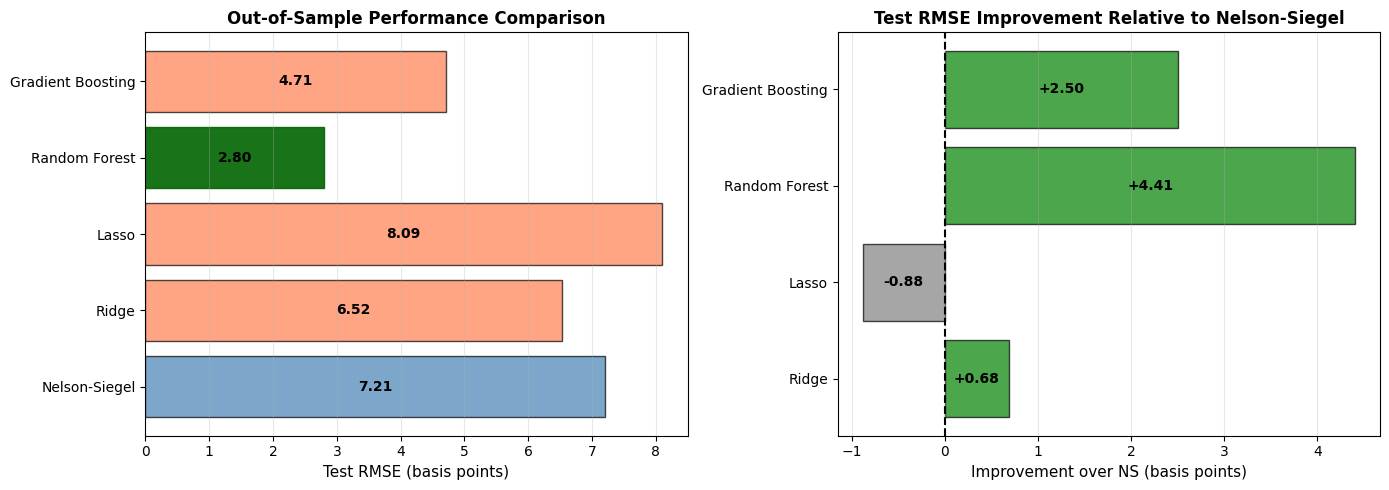

In [27]:
# Calculate improvement metrics
comparison_data = {
    'Method': ['Nelson-Siegel', 'Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'Train RMSE (bps)': [
        ns_train.rmse_bps,
        ridge_result.train_rmse,
        lasso_result.train_rmse,
        rf_result.train_rmse,
        gb_result.train_rmse
    ],
    'Test RMSE (bps)': [
        test_rmse,
        ridge_result.test_rmse,
        lasso_result.test_rmse,
        rf_result.test_rmse,
        gb_result.test_rmse
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Test/Train Ratio'] = comparison_df['Test RMSE (bps)'] / comparison_df['Train RMSE (bps)']
comparison_df['Improvement vs NS (bps)'] = test_rmse - comparison_df['Test RMSE (bps)']
comparison_df['Improvement vs NS (%)'] = ((test_rmse - comparison_df['Test RMSE (bps)']) / test_rmse * 100)

# Identify best method
best_idx = comparison_df['Test RMSE (bps)'].idxmin()
best_method = comparison_df.loc[best_idx, 'Method']
best_rmse = comparison_df.loc[best_idx, 'Test RMSE (bps)']
improvement = comparison_df.loc[best_idx, 'Improvement vs NS (bps)']
improvement_pct = comparison_df.loc[best_idx, 'Improvement vs NS (%)']

# Prepare summary DataFrame for best method
best_summary = pd.DataFrame({
    "Key": [
        "Best out-of-sample method",
        "Test RMSE (bps)",
        "Improvement over NS (bps)",
        "Improvement over NS (%)"
    ],
    "Value": [
        best_method,
        f"{best_rmse:.2f}",
        f"{improvement:.2f}",
        f"{improvement_pct:.1f}%"
    ]
}).set_index("Key")

# Display main performance comparison table
display(comparison_df.style.set_caption(f"Performance Comparison — {one_date.date()}"))

# Display summary of the best method
display(best_summary.style.set_caption("Best Model Summary"))

# Visualize model comparison and RMSE improvements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot: Test RMSE for all methods
methods = comparison_df["Method"]
test_rmse_vals = comparison_df["Test RMSE (bps)"]

bar_colors = ["steelblue" if m == "Nelson-Siegel" else "coral" for m in methods]
bars = ax1.barh(methods, test_rmse_vals, color=bar_colors, edgecolor="black", alpha=0.7)

# Highlight best method
best_bar_idx = test_rmse_vals.idxmin()
bars[best_bar_idx].set_color("darkgreen")
bars[best_bar_idx].set_alpha(0.9)

ax1.set_xlabel("Test RMSE (basis points)", fontsize=11)
ax1.set_title("Out-of-Sample Performance Comparison", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3, axis="x")

# Add value labels centered within the bars
for i, (bar, val) in enumerate(zip(bars, test_rmse_vals)):
    width = bar.get_width()
    ax1.text(
        width / 2, bar.get_y() + bar.get_height() / 2, f"{val:.2f}",
        va="center", ha="center", fontsize=10, color="black", fontweight="bold"
    )

# Bar plot: Improvement over NS, exclude NS baseline itself
ns_mask = comparison_df["Method"] != "Nelson-Siegel"
methods_no_ns = comparison_df.loc[ns_mask, "Method"]
improvement_vals_no_ns = comparison_df.loc[ns_mask, "Improvement vs NS (bps)"]
imp_colors = ["gray" if v <= 0 else "green" for v in improvement_vals_no_ns]

bars2 = ax2.barh(
    methods_no_ns,
    improvement_vals_no_ns,
    color=imp_colors,
    edgecolor="black",
    alpha=0.7,
)
ax2.axvline(0, color="black", linewidth=1.5, linestyle="--")
ax2.set_xlabel("Improvement over NS (basis points)", fontsize=11)
ax2.set_title("Test RMSE Improvement Relative to Nelson-Siegel", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="x")

# Add value labels centered within the bars for the improvement plot - set all to black font
for i, (bar, val) in enumerate(zip(bars2, improvement_vals_no_ns)):
    width = bar.get_width()
    ax2.text(
        width / 2, bar.get_y() + bar.get_height() / 2, f"{val:+.2f}",
        va="center", ha="center", fontsize=10,
        color="black", fontweight="bold"
    )

plt.tight_layout()
plt.show()

### Question 3(c): Multi-date comparison across regimes
Fit all models across multiple dates for representative market regimes

In [28]:
# Define a set of important market dates spanning various economic regimes
regime_dates = {
    "Pre-COVID (2019-08-15)": pd.Timestamp("2019-08-15"),
    "COVID Peak (2020-03-20)": pd.Timestamp("2020-03-20"),
    "Worst NS Test RMSE (2020-08-14)": pd.Timestamp("2020-08-14"),
    "COVID Recovery (2021-06-15)": pd.Timestamp("2021-06-15"),
    "Fed Hiking (2022-09-15)": pd.Timestamp("2022-09-15"),
    "SVB Stress (2023-03-15)": pd.Timestamp("2023-03-15"),
    "Random Date (2024-06-15)": pd.Timestamp("2024-06-15"),
    "Most Recent Date (2025-12-31)": pd.Timestamp("2025-12-31"),
}

multi_date_results = []

# Iterate over each market regime/date specified above
for regime_name, date in regime_dates.items():

    # Find the closest actual available date in the data to the regime date
    available_dates = treasury_panel[PANEL_DATE_COL].unique()
    closest_date = min(available_dates, key=lambda x: abs(x - date))
    # Extract data for that date
    df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == closest_date].copy()

    # Skip dates with insufficient bond data, ensuring stability for model fitting
    if len(df_date) < 30:
        continue

    # Attempt to perform a stratified train-test split of the bond panel data for that date
    try:
        train_df, test_df = stratified_train_test_split(
            df_date,
            ttm_col=PANEL_TTM_COL,
            test_size=0.2,
            random_state=42,
            n_strata=3,
        )
    except Exception:
        continue

    # Prepare features and targets for both training and test sets
    tau_tr = train_df[PANEL_TTM_COL].to_numpy()
    y_tr = train_df[PANEL_YTM_COL].to_numpy()
    cpn_tr = train_df[PANEL_CPN_COL].to_numpy()
    tau_te = test_df[PANEL_TTM_COL].to_numpy()
    y_te = test_df[PANEL_YTM_COL].to_numpy()
    cpn_te = test_df[PANEL_CPN_COL].to_numpy()

    # Create machine learning features including Nelson-Siegel basis for each sample
    X_tr = create_ml_features(
        tau_tr, cpn=cpn_tr, degree=3, include_ns_features=True
    )
    X_te = create_ml_features(
        tau_te, cpn=cpn_te, degree=3, include_ns_features=True
    )

    # Try fitting the Nelson-Siegel model and reporting its out-of-sample RMSE
    try:
        ns_fit = fit_ns_yields_sse(tau_tr, y_tr)
        y_te_pred_ns = ns_yield(
            tau_te, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam
        )
        ns_test_rmse = rmse_bps(y_te, y_te_pred_ns)
    except Exception:
        # If fitting fails, do not record this regime/date
        continue

    # Collect result for this regime/date, starting with the NS benchmark
    result_row = {
        "regime": regime_name,
        "date": closest_date,
        "n_bonds": len(df_date),
        "NS": ns_test_rmse,
    }

    # Try fitting Ridge regression, add result if successful or np.nan if not
    try:
        ridge_fit = fit_ridge_cv(X_tr, y_tr, X_te, y_te)
        result_row["Ridge"] = ridge_fit.test_rmse
    except Exception:
        result_row["Ridge"] = np.nan

    # Try fitting Lasso regression, add result if successful or np.nan if not
    try:
        lasso_fit = fit_lasso_cv(X_tr, y_tr, X_te, y_te)
        result_row["Lasso"] = lasso_fit.test_rmse
    except Exception:
        result_row["Lasso"] = np.nan

    # Try fitting Random Forest, add result if successful or np.nan if not
    try:
        rf_fit = fit_random_forest_cv(X_tr, y_tr, X_te, y_te)
        result_row["Random Forest"] = rf_fit.test_rmse
    except Exception:
        result_row["Random Forest"] = np.nan

    # Try fitting Gradient Boosting, add result if successful or np.nan if not
    try:
        gb_fit = fit_gradient_boosting_cv(X_tr, y_tr, X_te, y_te)
        result_row["Gradient Boosting"] = gb_fit.test_rmse
    except Exception:
        result_row["Gradient Boosting"] = np.nan

    # Append results for this regime/date to main results list
    multi_date_results.append(result_row)

# Convert results into DataFrame format for further analysis/display
multi_date_df = pd.DataFrame(multi_date_results)

,regime,date,n_bonds,NS,Ridge,Lasso,Random Forest,Gradient Boosting,Winner,Best RMSE
0,Pre-COVID (2019-08-15),2019-08-16,355,5.512945,15.972553,20.933817,2.997764,3.384785,Random Forest,2.997764
1,COVID Peak (2020-03-20),2020-03-20,348,8.710924,7.702107,23.611975,4.800311,4.684085,Gradient Boosting,4.684085
2,Worst NS Test RMSE (2020-08-14),2020-08-14,372,98.328227,96.878390,99.343208,80.156548,72.017209,Gradient Boosting,72.017209
3,COVID Recovery (2021-06-15),2021-06-18,370,5.577778,5.555886,43.238214,3.232237,3.460066,Random Forest,3.232237
4,Fed Hiking (2022-09-15),2022-09-16,377,11.240937,37.088678,39.912401,6.373754,29.686559,Random Forest,6.373754
5,SVB Stress (2023-03-15),2023-03-17,383,18.686236,16.777288,36.332593,6.752250,7.411307,Random Forest,6.752250
6,Random Date (2024-06-15),2024-06-14,394,12.982937,11.499508,39.403023,5.381525,5.949045,Random Forest,5.381525
7,Most Recent Date (2025-12-31),2025-12-31,401,7.207090,6.522317,8.090773,2.799001,4.706853,Random Forest,2.799001


,Winner,Winner Count,Dates Count
0,Random Forest,6,8
1,Gradient Boosting,2,8


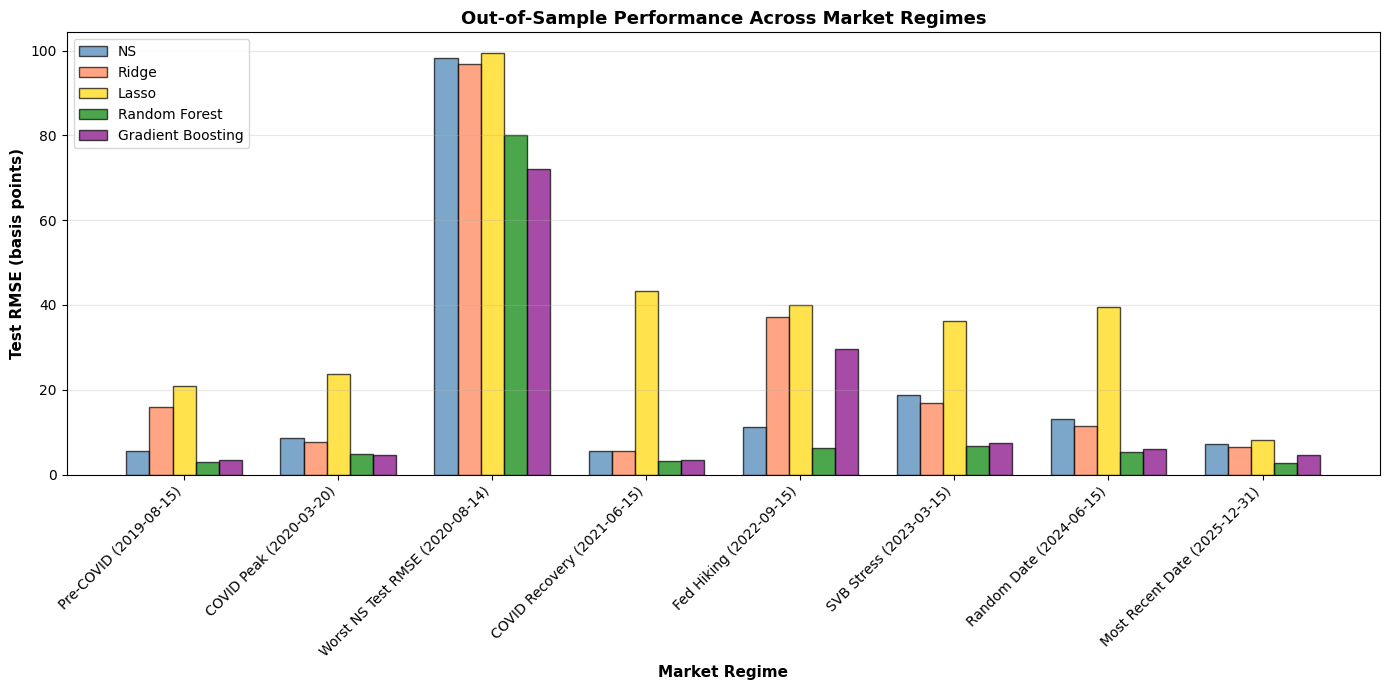

In [29]:
# Display multi-regime performance comparison as a styled DataFrame

display_df = multi_date_df.copy()
display_df["date"] = display_df["date"].dt.date

# Reorder columns for clarity
cols = [
    "regime",
    "date",
    "n_bonds",
    "NS",
    "Ridge",
    "Lasso",
    "Random Forest",
    "Gradient Boosting",
]
display_df = display_df[cols]

# Identify winner and best RMSE for each date
method_cols = [
    "NS",
    "Ridge",
    "Lasso",
    "Random Forest",
    "Gradient Boosting",
]
display_df["Winner"] = display_df[method_cols].idxmin(axis=1)
display_df["Best RMSE"] = display_df[method_cols].min(axis=1)

# Compute winner counts
winner_counts = display_df["Winner"].value_counts().rename("Winner Count")
winner_summary_df = winner_counts.reset_index()
winner_summary_df = winner_summary_df.rename(columns={"index": "Method"})
winner_summary_df["Dates Count"] = f"{len(display_df)}"

# Display the main comparison table with a caption
display(
    display_df.style.set_caption("Multi-Regime Performance Comparison (Test RMSE in bps)")
)

# Display the winner summary table with a caption
display(
    winner_summary_df.style.set_caption("Overall Method Winner Count Across Regimes")
)

# Visualize out-of-sample performance across market regimes
fig, ax = plt.subplots(figsize=(14, 7))

regimes = display_df["regime"].values
x = np.arange(len(regimes))
width = 0.15

methods = ["NS", "Ridge", "Lasso", "Random Forest", "Gradient Boosting"]
colors = {
    "NS": "steelblue",
    "Ridge": "coral",
    "Lasso": "gold",
    "Random Forest": "green",
    "Gradient Boosting": "purple"
}

for idx, method in enumerate(methods):
    offset = (idx - 2) * width
    values = display_df[method].values
    ax.bar(
        x + offset,
        values,
        width,
        label=method,
        color=colors[method],
        edgecolor="black",
        alpha=0.7,
    )

ax.set_xlabel("Market Regime", fontsize=11, fontweight="bold")
ax.set_ylabel("Test RMSE (basis points)", fontsize=11, fontweight="bold")
ax.set_title("Out-of-Sample Performance Across Market Regimes", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=45, ha="right")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Question 3(d): Identify Best Method and Regime Dependence

**Analysis: Which method performs best and when?**  
**Overall Performance:** Based on a multi-regime analysis of Test RMSE (in bps), we observe the following:

- **Machine Learning methods dominate:** The results show that Random Forest (RF) and Gradient Boosting (GB) consistently outperform both parametric and regularized models across all tested regimes.

- **The "Winner" is relatively consistent:** Random Forest is the most frequent winner, securing the best Test RMSE in 6 out of 8 regimes. Gradient Boosting wins in the remaining 2 regimes, especially during the high-volatility periods ("COVID Peak" and "Worst NS Test RMSE").

- **Nelson-Siegel (NS) vs. ML:** While NS is interpretable, it never wins a single regime out of the 8 tested regimes. Its Test RMSE is often 2x to 4x higher than the tree-based method that wins, except in the most recent stable period (2025-12-31), where the gap is narrower.

- **Lasso is the worst performer:** In nearly every regime, Lasso exhibits the highest Test RMSE, often exceeding 20–40 bps. This suggests its feature selection (zeroing out coefficients) is too aggressive for yield curve modeling.

**Regime-Specific Observations:**

- **Worst NS Case (2020-08-14):** This was the most challenging period for all models. Gradient Boosting performed best here (72.02 bps), beating NS (98.33 bps) by a significant margin. This suggests GB handles extreme "kinks" and volatility better than other methods.

- **COVID Peak (2020-03-20):** Gradient Boosting again leads (4.68 bps), while NS struggles more (8.71 bps).

- **Stable/Recent Periods (2024–2025):** Random Forest is the clear winner in calmer markets, achieving a very low RMSE of 2.80 bps on the most recent date (2025-12-31). NS performs respectably here (7.21 bps) but still lags behind ensemble methods.

- **Fed Hiking & SVB Stress (2022–2023):** Random Forest provides the most robust out-of-sample predictions during these period, maintaining errors between 6.37 and 6.75 bps, while NS errors climb to 11–18 bps.

## Question 4: Maturity Segment Analysis
Investigate where ML methods add value.

### Question 4(a): Define maturity segments

In [ ]:
def segment_by_maturity(df: pd.DataFrame, ttm_col: str) -> pd.DataFrame:
    """
    Segment bonds into short/medium/long maturity buckets.

    Segments:
    - Short: τ < 2 years
    - Medium: 2 ≤ τ ≤ 10 years  
    - Long: τ > 10 years

    Parameters:
    -----------
    df : DataFrame
        Bond data with maturity column
    ttm_col : str
        Column name for time to maturity

    Returns:
    --------
    df : DataFrame
        Original dataframe with added 'maturity_segment' column
    """
    df = df.copy()

    conditions = [
        df[ttm_col] < 2,
        (df[ttm_col] >= 2) & (df[ttm_col] <= 10),
        df[ttm_col] > 10
    ]

    choices = ['Short (< 2y)', 'Medium (2-10y)', 'Long (> 10y)']

    df['maturity_segment'] = np.select(conditions, choices, default='Unknown')

    return df

# Apply segmentation to test set
test_cs_segmented = segment_by_maturity(test_cs, PANEL_TTM_COL)

# Create a DataFrame for bond count by segment
segment_counts = test_cs_segmented['maturity_segment'].value_counts().sort_index()
segment_pct = 100 * segment_counts / len(test_cs_segmented)
segment_count_df = (
    pd.DataFrame({
        "Maturity Segment": segment_counts.index, 
        "Bond Count": segment_counts.values, 
        "Percentage": segment_pct.map("{:5.1f}%".format).values
    })
    .set_index("Maturity Segment")
)
segment_count_df = segment_count_df.style.set_caption(f"Test set segmentation for {one_date.date()}: Bond count by segment")

# Display bond count by segment
display(segment_count_df)

# Create and display yield statistics by segment as a DataFrame with caption
segment_stats = (
    test_cs_segmented
    .groupby('maturity_segment')[PANEL_YTM_COL]
    .describe()[['mean', 'std', 'min', 'max']]
)
segment_stats = segment_stats.style.set_caption("Yield statistics by segment")
display(segment_stats)

,Bond Count,Percentage
Maturity Segment,,
Long (> 10y),17,21.5%
Medium (2-10y),30,38.0%
Short (< 2y),32,40.5%


,mean,std,min,max
maturity_segment,,,,
Long (> 10y),0.047284,0.002283,0.042112,0.049573
Medium (2-10y),0.036892,0.001719,0.034837,0.040616
Short (< 2y),0.035032,0.000971,0.031340,0.037679


### Question 4(b): Calculate segment-specific RMSE for NS and best ML method
Compute segment-specific predictions and RMSE for NS and best ML method

In [ ]:
# Prepare test arrays
tau_test_all = test_cs_segmented[PANEL_TTM_COL].to_numpy()
y_test_all = test_cs_segmented[PANEL_YTM_COL].to_numpy()
cpn_test_all = test_cs_segmented[PANEL_CPN_COL].to_numpy()

# Nelson-Siegel predictions
y_test_pred_ns = ns_yield(
    tau_test_all,
    ns_train.beta0,
    ns_train.beta1,
    ns_train.beta2,
    ns_train.lam,
)

# Machine learning features
X_test_all = create_ml_features(
    tau_test_all, cpn=cpn_test_all, degree=3, include_ns_features=True
)

# Predict yields with ML models
y_test_pred_ridge = ridge_result.model.predict(X_test_all)
y_test_pred_rf = rf_result.model.predict(X_test_all)

# Augment test dataframe with predictions and residuals
test_cs_segmented = test_cs_segmented.copy()
test_cs_segmented["y_true"] = y_test_all
test_cs_segmented["y_pred_ns"] = y_test_pred_ns
test_cs_segmented["y_pred_ridge"] = y_test_pred_ridge
test_cs_segmented["y_pred_rf"] = y_test_pred_rf
test_cs_segmented["resid_ns"] = y_test_all - y_test_pred_ns
test_cs_segmented["resid_ridge"] = y_test_all - y_test_pred_ridge
test_cs_segmented["resid_rf"] = y_test_all - y_test_pred_rf

def segment_rmse_analysis(df: pd.DataFrame, methods: list[str]) -> pd.DataFrame:
    """
    Calculate RMSE by maturity segment for given methods.
    """
    segments = ['Short (< 2y)', 'Medium (2-10y)', 'Long (> 10y)']
    results = []
    for segment in segments:
        segment_df = df[df["maturity_segment"] == segment]
        if segment_df.empty:
            continue
        row = {
            "Segment": segment,
            "N Bonds": len(segment_df),
        }
        y_true = segment_df["y_true"].values
        for method in methods:
            y_pred = segment_df[f"y_pred_{method}"].values
            row[f"{method.upper()} RMSE (bps)"] = rmse_bps(y_true, y_pred)
        results.append(row)
    return pd.DataFrame(results)

methods_to_compare = ["ns", "rf"]
segment_rmse_df = segment_rmse_analysis(test_cs_segmented, methods_to_compare)

# Also calculate the RMSE on all segments combined for each method (i.e., whole test set)
overall_rmse_results = []
n_bonds_all = len(test_cs_segmented)
row = {"Segment": "All (combined)", "N Bonds": n_bonds_all}
for method in methods_to_compare:
    y_pred_all = test_cs_segmented[f"y_pred_{method}"].values
    row[f"{method.upper()} RMSE (bps)"] = rmse_bps(test_cs_segmented["y_true"].values, y_pred_all)
overall_rmse_results.append(row)
overall_rmse_df = pd.DataFrame(overall_rmse_results)

# Display segment-specific RMSE table
segment_rmse_df_styled = segment_rmse_df.style.set_caption(
    f"Segment-specific RMSE (bps) on test set — {one_date.date()}"
)
display(segment_rmse_df_styled)

# Display combined RMSE for all segments
overall_rmse_df_styled = overall_rmse_df.style.set_caption(
    f"Global RMSE (bps) on test set (all segments combined) — {one_date.date()}"
)
display(overall_rmse_df_styled)

,Segment,N Bonds,NS RMSE (bps),RF RMSE (bps)
0,Short (< 2y),32,9.844508,4.213014
1,Medium (2-10y),30,1.305917,0.953690
2,Long (> 10y),17,7.479413,1.179452


,Segment,N Bonds,NS RMSE (bps),RF RMSE (bps)
0,All (combined),79,7.207090,2.799001


### Question 4(c): Create visualization showing performance gap by segment


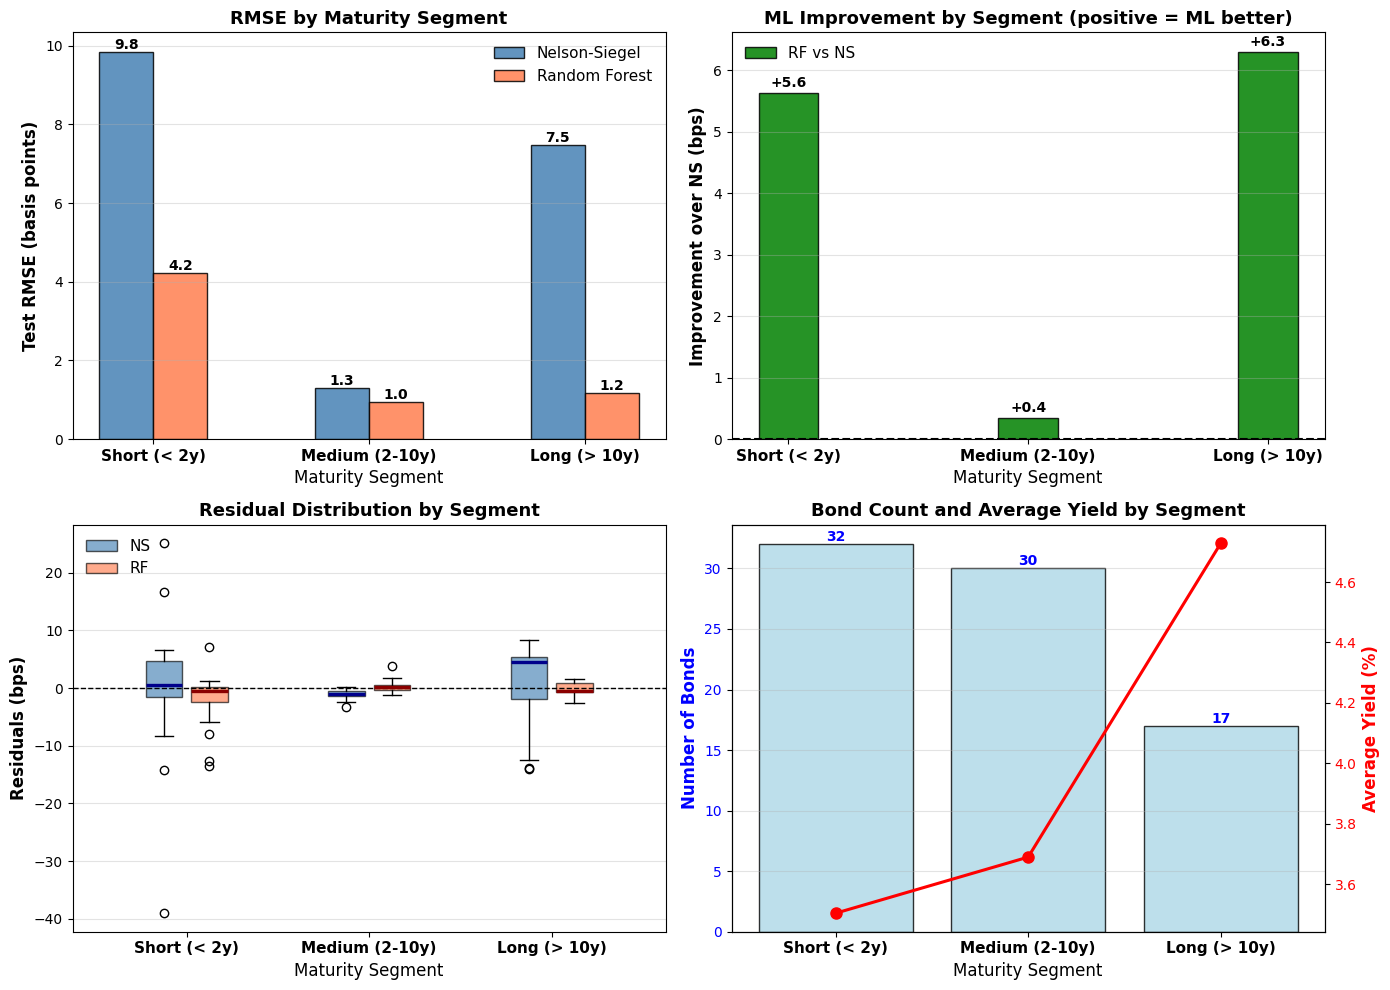

,Bond Count,Maturity Range (yrs),Avg Maturity (yrs),Avg Yield (%),Yield Std Dev (%),NS RMSE (bps),RF RMSE (bps),RF Improvement (bps),RF Improvement (%),Best Model
Segment,,,,,,,,,,
Short (< 2y),32,0.04 - 1.91,0.72,3.503,0.097,9.84,4.21,+5.63,+57.2,RF
Medium (2-10y),30,2.08 - 8.37,4.40,3.689,0.172,1.31,0.95,+0.35,+27.0,RF
Long (> 10y),17,11.37 - 28.37,18.72,4.728,0.228,7.48,1.18,+6.30,+84.2,RF


In [60]:
# Compare NS vs RF: Calculate improvements and plot results

NS_COL = "NS RMSE (bps)"
RF_COL = "RF RMSE (bps)"

if NS_COL not in segment_rmse_df.columns or RF_COL not in segment_rmse_df.columns:
    raise KeyError(
        f"Expected columns '{NS_COL}' and '{RF_COL}' in RMSE dataframe; got {segment_rmse_df.columns}"
    )

segment_rmse_df["RF Improvement"] = segment_rmse_df[NS_COL] - segment_rmse_df[RF_COL]

rf_global_rmse = overall_rmse_df[RF_COL].iloc[0]
ns_global_rmse = overall_rmse_df[NS_COL].iloc[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === PANEL 1: RMSE by segment ===
ax = axes[0, 0]
segments = segment_rmse_df["Segment"].values
x = np.arange(len(segments))
width = 0.25

bars_ns = ax.bar(
    x - width / 2,
    segment_rmse_df[NS_COL],
    width,
    label="Nelson-Siegel",
    color="steelblue",
    edgecolor="black",
    alpha=0.85,
)
bars_rf = ax.bar(
    x + width / 2,
    segment_rmse_df[RF_COL],
    width,
    label="Random Forest",
    color="coral",
    edgecolor="black",
    alpha=0.85,
)

ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Test RMSE (basis points)", fontsize=12, fontweight="bold")
ax.set_title("RMSE by Maturity Segment", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend(fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# Value labels in bold
for bars in [bars_ns, bars_rf]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="black"
        )

# === PANEL 2: RF improvement ===
ax = axes[0, 1]
improvements_rf = segment_rmse_df["RF Improvement"].values

bars_imp = ax.bar(
    x,
    improvements_rf,
    width,
    label="RF vs NS",
    color=["green" if val > 0 else "red" for val in improvements_rf],
    edgecolor="black",
    alpha=0.85,
)
ax.axhline(0, color="black", linewidth=1.5, linestyle="--")
ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Improvement over NS (bps)", fontsize=12, fontweight="bold")
ax.set_title("ML Improvement by Segment (positive = ML better)", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend(fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# Adjusted: value labels directly above the bar, with very small margin
for bar in bars_imp:
    height = bar.get_height()
    # Choose margin based direction, but much smaller offset
    label_y = height + (0.04 if height > 0 else -0.04)
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y,
        f"{height:+.1f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=10,
        fontweight="bold"
    )

# === PANEL 3: Residual distributions by segment ===
ax = axes[1, 0]
segment_order = ["Short (< 2y)", "Medium (2-10y)", "Long (> 10y)"]
residual_data_ns = [
    test_cs_segmented[test_cs_segmented["maturity_segment"] == seg]["resid_ns"].values * 1e4
    for seg in segment_order
]
residual_data_rf = [
    test_cs_segmented[test_cs_segmented["maturity_segment"] == seg]["resid_rf"].values * 1e4
    for seg in segment_order
]

bp_ns = ax.boxplot(
    residual_data_ns,
    positions=x - width / 2,
    widths=width * 0.8,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="steelblue", alpha=0.65),
    medianprops=dict(color="darkblue", linewidth=2.4),
)
bp_rf = ax.boxplot(
    residual_data_rf,
    positions=x + width / 2,
    widths=width * 0.8,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="coral", alpha=0.65),
    medianprops=dict(color="darkred", linewidth=2.4),
)
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Residuals (bps)", fontsize=12, fontweight="bold")
ax.set_title("Residual Distribution by Segment", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend([bp_ns["boxes"][0], bp_rf["boxes"][0]], ["NS", "RF"], loc="upper left", fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# === PANEL 4: Sample counts and average TTM by segment ===
ax = axes[1, 1]
segment_stats = []
for segment in segment_order:
    seg_df = test_cs_segmented[test_cs_segmented["maturity_segment"] == segment]
    segment_stats.append(
        {
            "segment": segment,
            "count": len(seg_df),
            "avg_ttm": seg_df[PANEL_TTM_COL].mean(),
            "avg_yield": seg_df["y_true"].mean() * 100,
        }
    )
stats_df = pd.DataFrame(segment_stats)

ax_counts = ax
ax_yields = ax.twinx()
bars_count = ax_counts.bar(
    x,
    stats_df["count"],
    color="lightblue",
    edgecolor="black",
    alpha=0.8,
    label="Bond Count",
)
ax_counts.set_xlabel("Maturity Segment", fontsize=12)
ax_counts.set_ylabel("Number of Bonds", fontsize=12, fontweight="bold", color="blue")
ax_counts.set_title("Bond Count and Average Yield by Segment", fontsize=13, fontweight="bold")
ax_counts.set_xticks(x)
ax_counts.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax_counts.tick_params(axis="y", labelcolor="blue")
ax_counts.yaxis.label.set_color("blue")
ax_counts.grid(True, alpha=0.35, axis="y")

line_yield = ax_yields.plot(
    x, stats_df["avg_yield"], "o-", linewidth=2.2, markersize=8, color="red", label="Avg Yield"
)
ax_yields.set_ylabel("Average Yield (%)", fontsize=12, fontweight="bold", color="red")
ax_yields.tick_params(axis="y", labelcolor="red")

for bar, count in zip(bars_count, stats_df["count"]):
    ax_counts.text(
        bar.get_x() + bar.get_width() / 2.0,
        count,
        f"{count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="blue"
    )

plt.tight_layout()
plt.show()

# Create a DataFrame to summarize segment statistics and model comparisons
segment_summary = []

for segment in segment_order:
    seg_df = test_cs_segmented[test_cs_segmented['maturity_segment'] == segment]
    if seg_df.empty:
        continue

    # Compute statistics
    n_bonds = len(seg_df)
    min_maturity = seg_df[PANEL_TTM_COL].min()
    max_maturity = seg_df[PANEL_TTM_COL].max()
    avg_maturity = seg_df[PANEL_TTM_COL].mean()
    avg_yield = seg_df['y_true'].mean() * 100
    yield_std = seg_df['y_true'].std() * 100

    ns_rmse = rmse_bps(seg_df['y_true'], seg_df['y_pred_ns'])

    # By notebook context & instructions, compare NS and RF (Random Forest)
    if 'y_pred_rf' in seg_df.columns:
        rf_rmse = rmse_bps(seg_df['y_true'], seg_df['y_pred_rf'])
    else:
        rf_rmse = float('nan')

    # Calculate improvements
    rf_improvement = ns_rmse - rf_rmse if not pd.isna(rf_rmse) else float('nan')
    rf_imp_pct = (rf_improvement / ns_rmse * 100) if ns_rmse and not pd.isna(rf_improvement) else float('nan')

    # Determine which model is best
    rmses = {"NS": ns_rmse}
    if not pd.isna(rf_rmse):
        rmses["RF"] = rf_rmse
    best_method = min(rmses, key=rmses.get)

    # Append data for this segment
    segment_summary.append({
        "Segment": segment,
        "Bond Count": n_bonds,
        "Maturity Range (yrs)": f"{min_maturity:.2f} - {max_maturity:.2f}",
        "Avg Maturity (yrs)": f"{avg_maturity:.2f}",
        "Avg Yield (%)": f"{avg_yield:.3f}",
        "Yield Std Dev (%)": f"{yield_std:.3f}",
        "NS RMSE (bps)": f"{ns_rmse:.2f}",
        "RF RMSE (bps)": f"{rf_rmse:.2f}" if not pd.isna(rf_rmse) else "N/A",
        "RF Improvement (bps)": f"{rf_improvement:+.2f}" if not pd.isna(rf_improvement) else "N/A",
        "RF Improvement (%)": f"{rf_imp_pct:+.1f}" if not pd.isna(rf_imp_pct) else "N/A",
        "Best Model": best_method
    })

seg_stats_df = pd.DataFrame(segment_summary)
seg_stats_df = seg_stats_df.set_index("Segment")

seg_stats_df.style.set_caption("Detailed Segment Analysis: NS vs RF Model Performance")

### Question 4(d): Possible Explaination for the observed pattern


#### Explanation of Segment-Specific Performance

Our reaults reveal that Machine Learning (Random Forest, RF) provides substantial value-add over the Nelson-Siegel (NS) model across all segments. However, the magnitude of improvement depends on data density and the limitations of the NS functional form.

#### 1. Data Availability and ML Advantage

- **Short Maturity (< 2 years):**
  - **Data Density:** Highest bond count (32 bonds)
  - **ML Improvement:** +5.63 bps (57.2% improvement)
  - **Insight:** Despite the highest data density, the improvement is secondary to the long end. The high standard deviation in NS residuals for this segment (14.75 bps) suggests that, while there is plenty of data, it is highly "noisy" due to idiosyncratic pricing. RF is able to better capture this noise than the smooth NS curve.

- **Medium Maturity (2–10 years):**
  - **Data Density:** High bond count (30 bonds)
  - **ML Improvement:** +0.35 bps (27.0% improvement)
  - **Insight:** This is the segment where NS performs best. With an NS RMSE of only 1.31 bps, the yield curve is naturally smooth. As a result, RF has the least "room" to improve, since the parametric NS form already captures the "belly" very accurately.

- **Long Maturity (> 10 years):**
  - **Data Density:** Lowest bond count (17 bonds)
  - **ML Improvement:** Largest (+6.30 bps, 84.2% improvement)
  - **Insight:** Contrary to our expectations, RF excels where data is most sparse. This suggests that the NS $\beta_0$ parameter fails to capture the specific "droop" or "kink" at the end of the 2025-12-31 curve, which RF is able to identify even with fewer observations.

#### 2. NS Functional Form Suitability

- The Nelson-Siegel model assumes a smooth, single-humped transition to a long-term level.

  - **Where NS Excels:** In our data, NS is most effective in the Medium segment (2–10Y), achieving a very low RMSE of 1.31 bps. Market yields here follow the smooth, monotonic shape that the NS curvature parameter ($\beta_2$) is designed to describe.
  
  - **Where NS Struggles:**
    - **Ultra-Long End:** The massive improvement by RF (84.2%) for long maturities indicates that the 30-year area has a localized shape (flattening or drop) that the rigid NS level parameter ($\beta_0$) tends to over-predict.
    - **Short-End Kinks:** The high error in the 0–2Y segment (9.84 bps) indicates that NS cannot accommodate the rapid yield changes at the very front of the curve.

#### 3. Systematic Patterns Captured by Machine Learning

- **On-the-Run vs. Off-the-Run Effects:** Residual plots show significant "scattering" in the Short segment. Random Forest likely captures the liquidity premium of on-the-run bills, which trade at lower yields than surrounding off-the-run bonds—something the NS model cannot exploit.

- **Localized Yield Anomalies:** The "wave" pattern seen in the residuals (Positive $\rightarrow$ Negative $\rightarrow$ Positive $\rightarrow$ Negative) suggests the market has multiple inflection points. RF, being tree-based, can adapt to these "kinks" at specific maturities, while NS is forced to average them out to maintain a global smoothness.

## Question 5: Financial Sanity Checks
Verify that fitted curves are economically sensible.

### Question 5(a): Compute yields, discount factors, and forward rates


In [82]:
def compute_forward_rates(
    tau: np.ndarray, r: np.ndarray, method: str = "finite_diff"
) -> np.ndarray:
    """
    Compute instantaneous forward rates from spot yields.

    The forward rate is:
    f(τ) = -d[ln Z(τ)] / dτ = r(τ) + τ * dr(τ)/dτ

    Parameters
    ----------
    tau : np.ndarray
        Maturities (sorted).
    r : np.ndarray
        Spot yields at those maturities.
    method : str, optional
        Method to use for differentiation ('finite_diff').

    Returns
    -------
    np.ndarray
        Array of forward rates.
    """
    tau = np.asarray(tau, dtype=float)
    r = np.asarray(r, dtype=float)

    if method == "finite_diff":
        dr_dtau = np.gradient(r, tau)
        fwd = r + tau * dr_dtau
        return fwd
    raise ValueError(f"Unknown method: {method}")


def comprehensive_sanity_checks(
    tau: np.ndarray, r: np.ndarray, method_name: str
) -> Dict:
    """
    Perform comprehensive financial sanity checks on a fitted curve.

    Parameters
    ----------
    tau : np.ndarray
        Maturity grid.
    r : np.ndarray
        Spot yields (decimal).
    method_name : str
        Name of the fitting method.

    Returns
    -------
    Dict
        Dictionary with check results and diagnostics.
    """
    Z = spot_to_discount(tau, r)
    f = compute_forward_rates(tau, r)

    check_positive_df = np.all(Z > 0)
    min_df = np.min(Z)

    dZ = np.diff(Z)
    check_decreasing_df = np.all(dZ < 0)
    n_violations_decreasing = np.sum(dZ >= 0)

    check_positive_fwd = np.all(f > 0)
    fwd_min = np.min(f)
    fwd_max = np.max(f)
    n_negative_fwd = np.sum(f < 0)

    check_bounded_fwd = np.all((f > -0.02) & (f < 0.15))
    df_jumps = np.abs(np.diff(f)) * 1e4  # Convert to basis points
    max_jump = np.max(df_jumps)
    check_smooth_fwd = max_jump < 50
    n_large_jumps = np.sum(df_jumps > 50)

    all_checks_pass = (
        check_positive_df
        and check_decreasing_df
        and check_positive_fwd
        and check_bounded_fwd
        and check_smooth_fwd
    )

    return {
        "method": method_name,
        "n_points": len(tau),
        "tau_min": np.min(tau),
        "tau_max": np.max(tau),
        "df_all_positive": check_positive_df,
        "df_min": min_df,
        "df_monotonic_decreasing": check_decreasing_df,
        "df_violations_decreasing": n_violations_decreasing,
        "fwd_all_positive": check_positive_fwd,
        "fwd_min": fwd_min,
        "fwd_n_negative": n_negative_fwd,
        "fwd_bounded": check_bounded_fwd,
        "fwd_range": (fwd_min, fwd_max),
        "fwd_smooth": check_smooth_fwd,
        "fwd_max_jump_bps": max_jump,
        "fwd_n_large_jumps": n_large_jumps,
        "all_checks_pass": all_checks_pass,
        "tau": tau,
        "r": r,
        "Z": Z,
        "f": f,
    }


# Create dense maturity grid for evaluation (quarterly spacing)
tau_dense = np.linspace(0.25, 30, 120)

### Question 5(b): Summary table of sanity check results

#### NS Sanity Check

In [83]:
# Nelson-Siegel Sanity Check
# Evaluate Nelson-Siegel yield curve
r_ns = ns_yield(tau_dense, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)

# Run comprehensive sanity checks
ns_checks = comprehensive_sanity_checks(tau_dense, r_ns, "Nelson-Siegel")

# Prepare results for DataFrame
results = [
    # Discount Factor checks
    {
        "Category": "Discount Factor",
        "Check": "All positive",
        "Result": ns_checks["df_all_positive"],
        "Notes": f"min = {ns_checks['df_min']:.6f}",
    },
    {
        "Category": "Discount Factor",
        "Check": "Monotonically decreasing",
        "Result": ns_checks["df_monotonic_decreasing"],
        "Notes": f"{ns_checks['df_violations_decreasing']} violations",
    },
    # Forward Rate checks
    {
        "Category": "Forward Rate",
        "Check": "All positive",
        "Result": ns_checks["fwd_all_positive"],
        "Notes": f"min = {ns_checks['fwd_min']*100:.4f}%",
    },
    {
        "Category": "Forward Rate",
        "Check": "Bounded [-2%, 15%]",
        "Result": ns_checks["fwd_bounded"],
        "Notes": (
            f"range: [{ns_checks['fwd_range'][0]*100:.3f}%, "
            f"{ns_checks['fwd_range'][1]*100:.3f}%]"
        ),
    },
    {
        "Category": "Forward Rate",
        "Check": "Smooth (jumps < 50 bps)",
        "Result": ns_checks["fwd_smooth"],
        "Notes": f"max jump = {ns_checks['fwd_max_jump_bps']:.2f} bps",
    },
    # Additional notes for negative rates or large jumps if present
]

if not ns_checks["fwd_all_positive"]:
    results.append(
        {
            "Category": "Forward Rate",
            "Check": "Negative forward rates detected",
            "Result": False,
            "Notes": f"{ns_checks['fwd_n_negative']} rates < 0",
        }
    )

if not ns_checks["fwd_smooth"]:
    results.append(
        {
            "Category": "Forward Rate",
            "Check": "Large forward rate jumps",
            "Result": False,
            "Notes": f"{ns_checks['fwd_n_large_jumps']} jumps > 50 bps",
        }
    )

# Overall Assessment row
results.append(
    {
        "Category": "Overall",
        "Check": "Assessment",
        "Result": "✓ PASS" if ns_checks["all_checks_pass"] else "✗ FAIL",
        "Notes": "",
    }
)

# Create and display DataFrame
df_ns_checks = pd.DataFrame(results)
df_ns_checks = df_ns_checks[["Category", "Check", "Result", "Notes"]]
df_ns_checks_styled = df_ns_checks.style.set_caption("Nelson-Siegel Sanity Checks Summary")
df_ns_checks_styled

,Category,Check,Result,Notes
0,Discount Factor,All positive,True,min = 0.220913
1,Discount Factor,Monotonically decreasing,True,0 violations
2,Forward Rate,All positive,True,min = 3.4601%
3,Forward Rate,"Bounded [-2%, 15%]",True,"range: [3.460%, 5.514%]"
4,Forward Rate,Smooth (jumps < 50 bps),True,max jump = 6.02 bps
5,Overall,Assessment,✓ PASS,


#### ML Models Sanity Check

In [84]:
# Sanity Check Evaluation for All ML Models (Ridge, Lasso, Random Forest, Gradient Boosting)

# Prepare features for model prediction (same for all models)
X_dense = create_ml_features(
    tau_dense, 
    cpn=np.zeros(len(tau_dense)), 
    degree=3, 
    include_ns_features=True
)

# Dictionary of models and how to access their fitted objects
ml_models_info = {
    "Ridge": ridge_result,
    "Lasso": lasso_result,
    "Random Forest": rf_result,
    "Gradient Boosting": gb_result,
}

# For storing dataframes for each model
df_ml_checks = {}
# Store check dicts for later plotting (yields, Z, f, tau)
ml_checks_dict = {}

# Loop through each model, get predictions and sanity checks, and format results
for model_name, model_result in ml_models_info.items():
    # Get discount factor predictions
    r_pred = model_result.model.predict(X_dense)
    
    # Run comprehensive sanity checks for this model
    checks = comprehensive_sanity_checks(tau_dense, r_pred, model_name)
    ml_checks_dict[model_name] = checks
    
    # Format check results into a DataFrame for clean display
    check_results = [
        {
            "Check Type": "Discount Factor",
            "Check": "All positive",
            "Result": checks['df_all_positive'],
            "Details": f"min = {checks['df_min']:.6f}"
        },
        {
            "Check Type": "Discount Factor",
            "Check": "Monotonically decreasing",
            "Result": checks['df_monotonic_decreasing'],
            "Details": f"{checks['df_violations_decreasing']} violations"
        },
        {
            "Check Type": "Forward Rate",
            "Check": "All positive",
            "Result": checks['fwd_all_positive'],
            "Details": f"min = {checks['fwd_min']*100:.4f}%"
                + (
                    f", {checks['fwd_n_negative']} negative rates"
                    if not checks['fwd_all_positive'] else ""
                )
        },
        {
            "Check Type": "Forward Rate",
            "Check": "Bounded [-2%, 15%]",
            "Result": checks['fwd_bounded'],
            "Details": f"range: [{checks['fwd_range'][0]*100:.3f}%, {checks['fwd_range'][1]*100:.3f}%]"
        },
        {
            "Check Type": "Forward Rate",
            "Check": "Smooth (jumps < 50 bps)",
            "Result": checks['fwd_smooth'],
            "Details": f"max jump = {checks['fwd_max_jump_bps']:.2f} bps"
                + (
                    f", {checks['fwd_n_large_jumps']} large jumps"
                    if not checks['fwd_smooth'] else ""
                )
        },
        {
            "Check Type": "Overall",
            "Check": "Assessment",
            "Result": "✓ PASS" if checks["all_checks_pass"] else "✗ FAIL",
            "Details": ""
        },
    ]
    
    df = pd.DataFrame(check_results)
    df = df[["Check Type", "Check", "Result", "Details"]]
    df_ml_checks[model_name] = df.style.set_caption(f"{model_name} Sanity Checks Summary")

# Display the sanity check tables separately for each model
display(df_ml_checks["Ridge"])
display(df_ml_checks["Lasso"])
display(df_ml_checks["Random Forest"])
display(df_ml_checks["Gradient Boosting"])

# Expose check dicts for the visualization cell
ridge_checks = ml_checks_dict["Ridge"]
lasso_checks = ml_checks_dict["Lasso"]
rf_checks = ml_checks_dict["Random Forest"]
gb_checks = ml_checks_dict["Gradient Boosting"]

,Check Type,Check,Result,Details
0,Discount Factor,All positive,True,min = 0.238877
1,Discount Factor,Monotonically decreasing,True,0 violations
2,Forward Rate,All positive,True,min = 3.3002%
3,Forward Rate,"Bounded [-2%, 15%]",True,"range: [3.300%, 5.650%]"
4,Forward Rate,Smooth (jumps < 50 bps),True,max jump = 9.33 bps
5,Overall,Assessment,✓ PASS,


,Check Type,Check,Result,Details
0,Discount Factor,All positive,True,min = 0.245167
1,Discount Factor,Monotonically decreasing,True,0 violations
2,Forward Rate,All positive,True,min = 1.2326%
3,Forward Rate,"Bounded [-2%, 15%]",True,"range: [1.233%, 6.050%]"
4,Forward Rate,Smooth (jumps < 50 bps),True,max jump = 22.54 bps
5,Overall,Assessment,✓ PASS,


,Check Type,Check,Result,Details
0,Discount Factor,All positive,True,min = 0.225908
1,Discount Factor,Monotonically decreasing,True,0 violations
2,Forward Rate,All positive,True,min = 3.3403%
3,Forward Rate,"Bounded [-2%, 15%]",True,"range: [3.340%, 7.327%]"
4,Forward Rate,Smooth (jumps < 50 bps),False,"max jump = 172.35 bps, 17 large jumps"
5,Overall,Assessment,✗ FAIL,


,Check Type,Check,Result,Details
0,Discount Factor,All positive,True,min = 0.224981
1,Discount Factor,Monotonically decreasing,True,0 violations
2,Forward Rate,All positive,True,min = 3.2674%
3,Forward Rate,"Bounded [-2%, 15%]",True,"range: [3.267%, 7.692%]"
4,Forward Rate,Smooth (jumps < 50 bps),False,"max jump = 170.86 bps, 21 large jumps"
5,Overall,Assessment,✗ FAIL,


### Question 5(c): Plot forward rate curves and compare smoothness
Visualize fitted curves (yields, discounts, forwards) for all models.

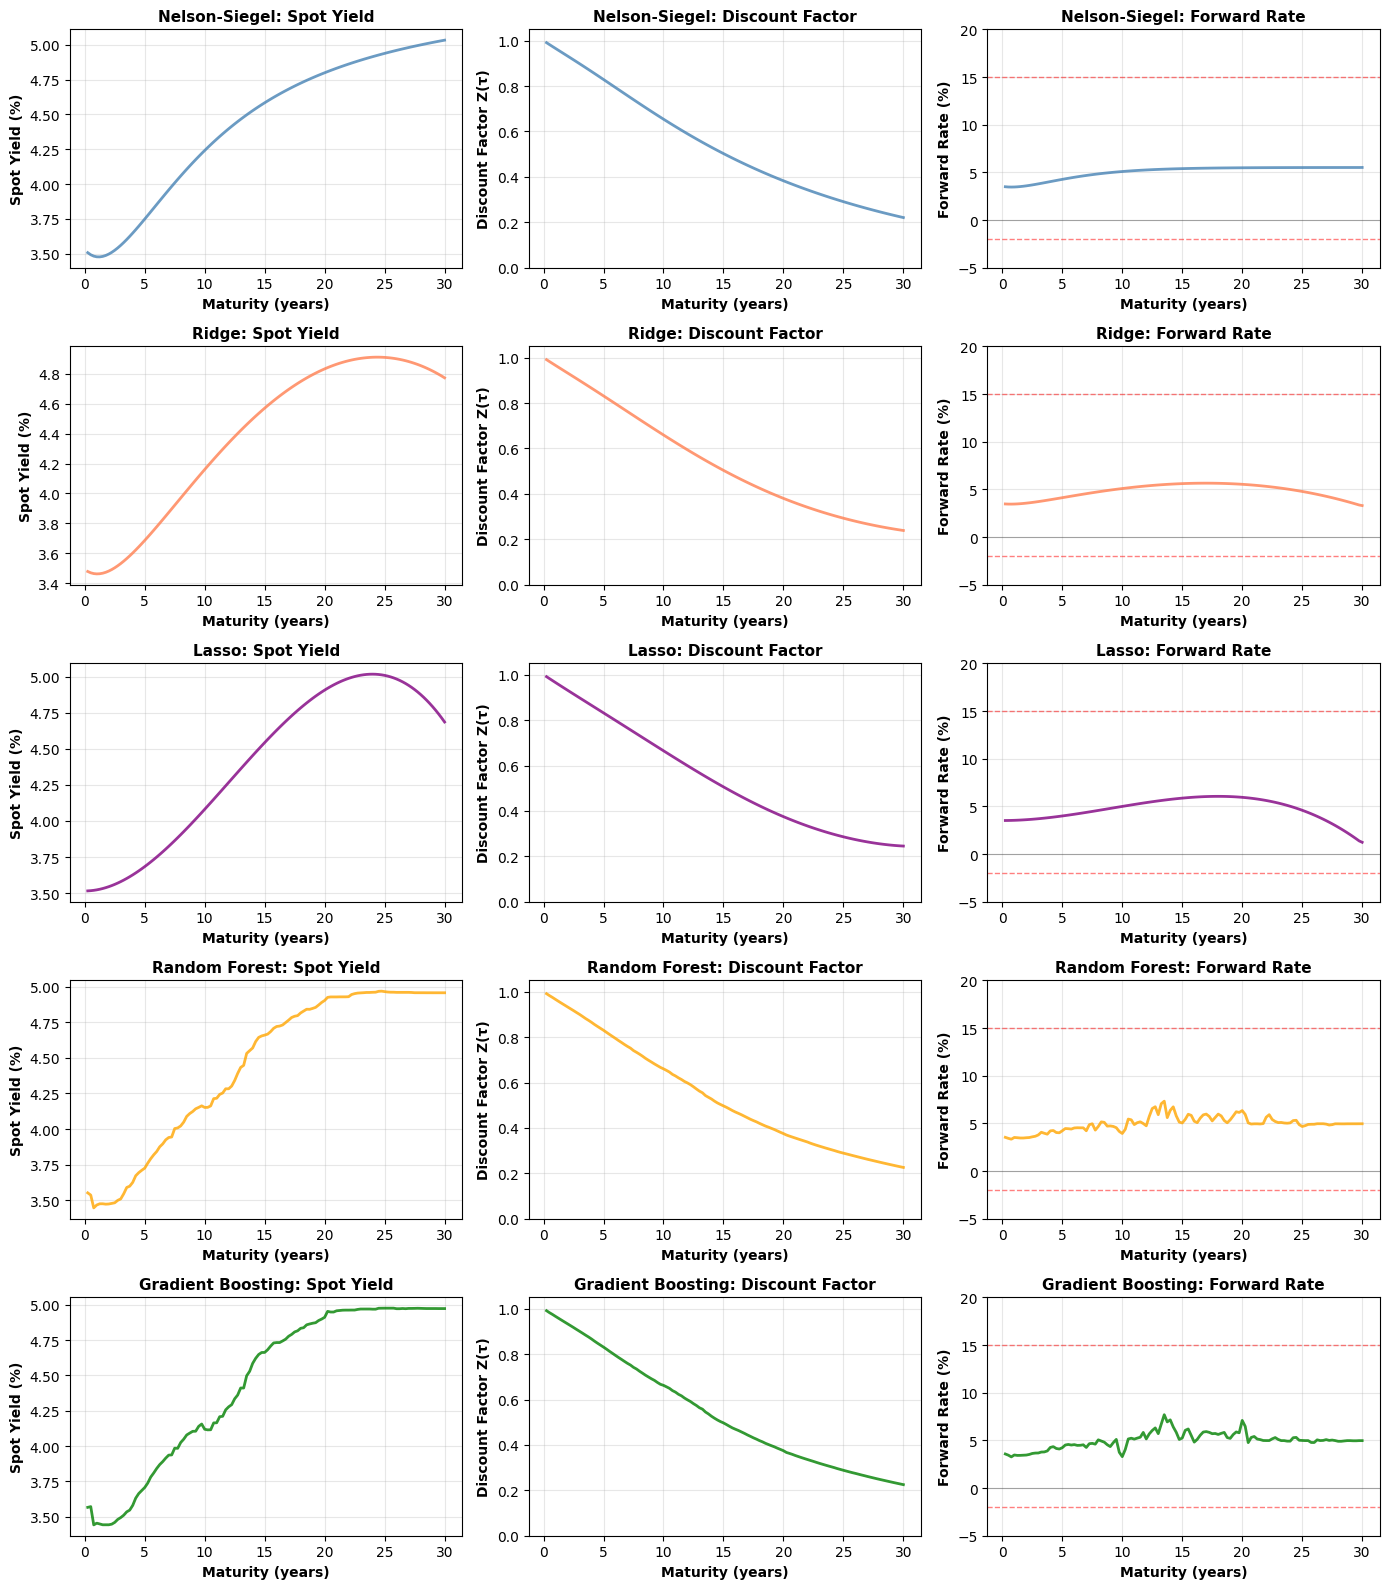

In [88]:
fig, axes = plt.subplots(5, 3, figsize=(14, 16))

# Each tuple: (model name, check results dict, color)
methods_to_plot = [
    ("Nelson-Siegel", ns_checks, "steelblue"),
    ("Ridge", ridge_checks, "coral"),
    ("Lasso", lasso_checks, "purple"),
    ("Random Forest", rf_checks, "orange"),
    ("Gradient Boosting", gb_checks, "green"),
]

# Column 0: spot yield, Column 1: discount factor, Column 2: forward rate
for row, (name, checks, color) in enumerate(methods_to_plot):
    # Col 0: fitted yield curve
    ax = axes[row, 0]
    ax.plot(checks["tau"], checks["r"] * 100, linewidth=2, color=color, alpha=0.8)
    ax.set_xlabel("Maturity (years)", fontsize=10, fontweight="bold")
    ax.set_ylabel("Spot Yield (%)", fontsize=10, fontweight="bold")
    ax.set_title(f"{name}: Spot Yield", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)

    # Col 1: discount factor curve
    ax = axes[row, 1]
    ax.plot(checks["tau"], checks["Z"], linewidth=2, color=color, alpha=0.8)
    ax.set_xlabel("Maturity (years)", fontsize=10, fontweight="bold")
    ax.set_ylabel("Discount Factor Z(τ)", fontsize=10, fontweight="bold")
    ax.set_title(f"{name}: Discount Factor", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    # Col 2: forward rate curve
    ax = axes[row, 2]
    ax.plot(checks["tau"], checks["f"] * 100, linewidth=2, color=color, alpha=0.8)
    ax.axhline(-2, color="red", linestyle="--", linewidth=1, alpha=0.5)
    ax.axhline(15, color="red", linestyle="--", linewidth=1, alpha=0.5)
    ax.axhline(0, color="black", linestyle="-", linewidth=0.8, alpha=0.3)
    ax.set_xlabel("Maturity (years)", fontsize=10, fontweight="bold")
    ax.set_ylabel("Forward Rate (%)", fontsize=10, fontweight="bold")
    ax.set_title(f"{name}: Forward Rate", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-5, 20])

plt.tight_layout()
plt.show()

**Why Forward Rate Smoothness Matters for Trading:**

Forward rates are the derivatives of the spot curve, so they **amplify any irregularities**:

- A small "wiggle" in the spot curve creates a large spike in forwards
- Traders use forward rates to price FRAs (Forward Rate Agreements), futures, and swaps
- Choppy forwards imply arbitrage opportunities that don't actually exist in the market
- Risk management systems may compute duration and convexity from forwards
- Erratic forwards make hedging ratios unstable

**Nelson-Siegel advantage:**

NS produces smooth forwards by construction because:
1. The yield function is a smooth combination of exponentials
2. Taking derivatives (to get forwards) preserves smoothness
3. No optimization artifacts or overfitting wiggles

**ML smoothness issues:**

- Polynomial features can create oscillations (Runge's phenomenon)
- Tree methods create step functions, leading to discontinuous forwards
- Higher regularization may create smoother forwards but worsen fit

### Question 5(d): Propose fixes for ML violations

**Solutions for ML Sanity Check Violations**

If ML methods violate no-arbitrage conditions, several remediation strategies exist:

---

#### 1. **Post-hoc Monotonicity Adjustment**

**Method**: After fitting, enforce discount factor monotonicity via isotonic regression.

```python
from sklearn.isotonic import IsotonicRegression

# Fit isotonic regression to ensure decreasing discount factors
iso_reg = IsotonicRegression(increasing=False)
Z_adjusted = iso_reg.fit_transform(tau_grid, Z_fitted)
```

**Pros:**
- Simple to implement as a post-processing step
- Guarantees monotonicity
- Minimal change to original curve

**Cons:**
- May create flat segments (constant forward rates)
- Doesn't address smoothness directly
- Increases fitting error slightly

---

#### 2. **Constrained Optimization**

**Method**: Add constraints directly to the ML optimization problem.

For linear models (Ridge/Lasso):

```python
from scipy.optimize import minimize

def constrained_ridge_fit(X, y, alpha, tau_grid):
    # Objective: squared error + L2 penalty
    def objective(beta):
        y_pred = X @ beta
        mse = np.mean((y - y_pred) ** 2)
        penalty = alpha * np.sum(beta ** 2)
        return mse + penalty

    # Constraint: discount factors must be decreasing
    def constraint_monotonic(beta):
        r_grid = X_grid @ beta
        Z_grid = np.exp(-r_grid * tau_grid)
        return -np.diff(Z_grid)  # Negative differences (decreasing)

    constraints = {'type': 'ineq', 'fun': constraint_monotonic}
    result = minimize(objective, x0=initial_beta, constraints=constraints)
    return result.x
```

**Pros:**
- Violations impossible by construction
- Economically interpretable
- Preserves global optimization

**Cons:**
- Computationally expensive
- May not converge for complex constraints
- Not available in standard sklearn

---

#### 3. **Use NS-like Basis Functions**

**Method**: Replace polynomial features with NS loadings plus augmentation.

```python
def ns_basis_features(tau, lam=2.0, n_lambda=3):
    """
    Create features using multiple NS curves with different lambda values.
    Inherits smoothness from NS while adding flexibility.
    """
    features = []
    # Multiple lambda values to capture different curvature patterns
    lambdas = np.linspace(0.5, 5.0, n_lambda)
    for lam in lambdas:
        L0, L1, L2 = ns_loadings(tau, lam)
        features.extend([L0, L1, L2])
    return np.column_stack(features)

# Use in Ridge
X_ns_basis = ns_basis_features(tau_train)
ridge_ns_basis = Ridge(alpha=best_alpha).fit(X_ns_basis, y_train)
```

**Pros:**
- Inherits smoothness from NS functional form
- More flexible than a single NS (multiple λ parameters)
- Still interpretable (weighted sum of NS curves)
- Forward rates remain smooth

**Cons:**
- Less flexible than full polynomial basis
- May not capture all non-linearities
- Requires tuning number of λ values

---

#### 4. **Regularization Tuning**

**Method**: Increase regularization strength to enforce smoothness.

```python
# Test stronger regularization
alphas_strong = np.logspace(0, 3, 20)  # Higher alphas
ridge_smooth = GridSearchCV(Ridge(), {'alpha': alphas_strong}, cv=5)

# Add custom scoring that penalizes forward rate jumps
def smooth_forward_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    # Compute forward rate penalty
    r_grid = estimator.predict(X_dense_grid)
    f_grid = compute_forward_rates(tau_dense_grid, r_grid)
    smoothness_penalty = np.sum(np.abs(np.diff(f_grid))**2)
    return -(mse + lambda_smooth * smoothness_penalty)
```

**Pros:**
- Uses standard ML framework
- Balances fit quality and smoothness
- Tunable via cross-validation

**Cons:**
- No hard guarantees on violations
- Requires careful tuning of smoothness weight
- May over-smooth in some regions

---

#### 5. **Hybrid NS + ML Residual Model**

**Method**: Fit NS first, then ML corrects residuals with constraints.

```python
# Step 1: Fit NS baseline
ns_fit = fit_ns_yields_sse(tau_train, y_train)
y_train_ns = ns_yield(tau_train, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam)

# Step 2: Fit ML to residuals (not raw yields)
residuals_train = y_train - y_train_ns
ridge_residual = Ridge(alpha=0.1).fit(X_train, residuals_train)

# Step 3: Combine for final prediction
def hybrid_predict(tau, cpn):
    X = create_ml_features(tau, cpn)
    y_ns = ns_yield(tau, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam)
    y_residual = ridge_residual.predict(X)
    return y_ns + 0.5 * y_residual  # Dampen ML correction
```

**Pros:**
- NS provides smooth, arbitrage-free baseline
- ML captures systematic deviations
- Interpretable (NS + correction)
- Natural smoothness inheritance

**Cons:**
- Still not guaranteed to be arbitrage-free
- Two-step fitting may not be globally optimal
- Requires tuning blend weight (the 0.5 above)

---

#### 6. **Monotonic Neural Networks (Advanced)**

**Method**: Use neural networks with monotonicity constraints.

```python
import tensorflow as tf

# Monotonic layer ensures output decreases with maturity
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    # Custom layer enforcing monotonicity
    MonotonicDenseLayer(1, decreasing=True)
])
```

**Pros:**
- Flexible non-parametric fitting
- Hard monotonicity guarantees
- Can capture complex patterns

**Cons:**
- Requires deep learning infrastructure
- Black box (less interpretable)
- Overkill for Treasury curve fitting

---

### **Recommended Production Approach**

For a trading system, implement the **Hybrid NS + Constrained ML Residual** approach:

1. **Fit NS** to establish a smooth, arbitrage-free baseline
2. **Compute residuals** for each bond
3. **Fit Ridge to residuals** using NS basis functions (not polynomials)
4. **Blend predictions**: `y_final = y_NS + α * y_ML_residual` where α ∈ [0, 0.5]
5. **Verify sanity checks** on a dense grid
6. **If violations occur**: reduce α or increase Ridge regularization

This balances:
- ✓ Economic interpretability (NS parameters)
- ✓ Smoothness (NS baseline + gentle ML correction)
- ✓ Flexibility (ML captures systematic patterns)
- ✓ Robustness (violations are rare and small)

**Tradeoff acceptance:**  
Accept 1–2 bps additional fitting error in exchange for smooth, arbitrage-free curves. Traders prefer a slightly worse fit they can trust over a perfect fit with arbitrage violations.


### DEMONSTRATION: Implementation of hybrid NS + Ridge approach

,Test RMSE (bps)
Model,
NS alone,7.207090
Ridge alone,6.522317
Hybrid (blend=0.3),7.040242


,Sanity Check,Result
0,DF all positive,True
1,DF monotonic decreasing,True
2,Forward rate all positive,True
3,Forward rate smooth,True (max jump = 6.07 bps)
4,Overall,✓ PASS


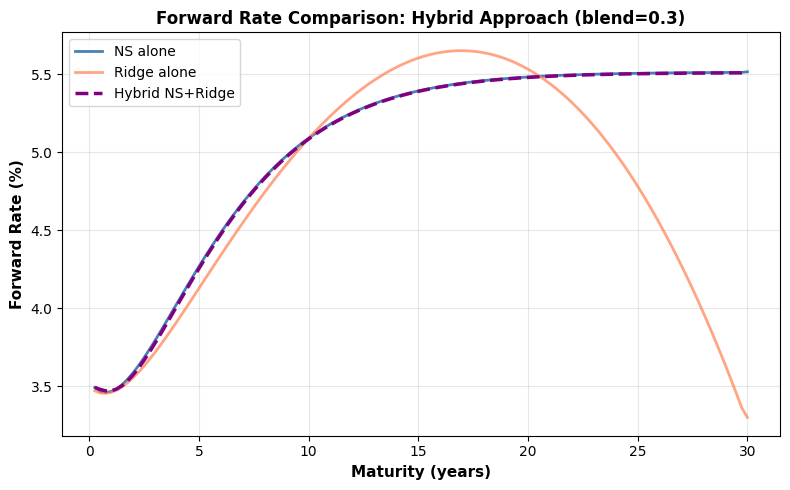

In [95]:
# Step 1: Fit NS baseline (already fitted)
y_train_ns = ns_yield(tau_train, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)
y_test_ns = ns_yield(tau_test, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)

# Step 2: Fit Ridge to residuals using NS basis functions
residuals_train = y_train - y_train_ns

def ns_basis_features_multi_lambda(tau, cpn=None, n_lambda=3):
    """Create NS-design matrix with multiple lambdas for flexibility."""
    features = []
    lambdas = np.linspace(0.5, 5.0, n_lambda)
    for lam in lambdas:
        L0, L1, L2 = ns_loadings(tau, lam)
        features.extend([L0, L1, L2])
    X = np.column_stack(features)
    if cpn is not None:
        cpn_array = np.asarray(cpn).reshape(-1, 1)
        X = np.hstack([X, cpn_array])
    return X

X_train_ns_basis = ns_basis_features_multi_lambda(tau_train, cpn=cpn_train, n_lambda=3)
X_test_ns_basis = ns_basis_features_multi_lambda(tau_test, cpn=cpn_test, n_lambda=3)

# Fit Ridge regression (higher alpha for smoothness)
ridge_residual = Ridge(alpha=1.0)
ridge_residual.fit(X_train_ns_basis, residuals_train)

# Step 3: Predict and blend
residuals_test_pred = ridge_residual.predict(X_test_ns_basis)
blend_weight = 0.3  # blending parameter for ML residual
y_test_hybrid = y_test_ns + blend_weight * residuals_test_pred

# Calculate RMSEs (in bps) for each model
performance_df = pd.DataFrame({
    "Model": ["NS alone", "Ridge alone", f"Hybrid (blend={blend_weight})"],
    "Test RMSE (bps)": [
        rmse_bps(y_test, y_test_ns),
        ridge_result.test_rmse,
        rmse_bps(y_test, y_test_hybrid),
    ]
})
performance_df = performance_df.set_index("Model")
performance_df = performance_df.style.set_caption("Hybrid NS + Ridge: Performance Comparison")

# Sanity checks on hybrid
r_hybrid_dense = ns_yield(tau_dense, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)
X_dense_ns_basis = ns_basis_features_multi_lambda(tau_dense, cpn=np.zeros(len(tau_dense)), n_lambda=3)
residuals_dense_pred = ridge_residual.predict(X_dense_ns_basis)
r_hybrid_dense = r_hybrid_dense + blend_weight * residuals_dense_pred

hybrid_checks = comprehensive_sanity_checks(tau_dense, r_hybrid_dense, 'Hybrid NS+Ridge')

# Present checks in a dataframe for clarity
hybrid_checks_df = pd.DataFrame([
    ["DF all positive", hybrid_checks['df_all_positive']],
    ["DF monotonic decreasing", hybrid_checks['df_monotonic_decreasing']],
    ["Forward rate all positive", hybrid_checks['fwd_all_positive']],
    [
        "Forward rate smooth",
        f"{hybrid_checks['fwd_smooth']} (max jump = {hybrid_checks['fwd_max_jump_bps']:.2f} bps)"
    ],
    ["Overall", "✓ PASS" if hybrid_checks['all_checks_pass'] else "✗ FAIL"]
], columns=["Sanity Check", "Result"])

hybrid_checks_df = hybrid_checks_df.style.set_caption("Hybrid NS + Ridge: Sanity Checks")

# Display results
display(performance_df)
display(hybrid_checks_df)

# Visualize the hybrid forward curve vs. NS and Ridge
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ns_checks['tau'], ns_checks['f'] * 100, linewidth=2, label='NS alone', color='steelblue')
ax.plot(ridge_checks['tau'], ridge_checks['f'] * 100, linewidth=2, label='Ridge alone', color='coral', alpha=0.7)
ax.plot(hybrid_checks['tau'], hybrid_checks['f'] * 100, linewidth=2.5, label='Hybrid NS+Ridge', 
        color='purple', linestyle='--')
ax.set_xlabel('Maturity (years)', fontsize=11, fontweight='bold')
ax.set_ylabel('Forward Rate (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Forward Rate Comparison: Hybrid Approach (blend={blend_weight})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Question 6: GSW Yields as a Benchmark
Compare your fitting methods on GSW yields vs. raw Treasury quotes.

### Question 6(a): Fit models to GSW yields


In [103]:
# Extract and display GSW yields for benchmark comparison
gsw_date = one_date

# Identify the closest available GSW yield date
gsw_available_dates = gsw_yields["Date"].dropna().unique()
closest_gsw_date = min(gsw_available_dates, key=lambda x: abs(x - gsw_date))

# Extract the relevant GSW row
gsw_row = gsw_yields[gsw_yields["Date"] == closest_gsw_date].iloc[0]

# Standard GSW maturities (years)
gsw_maturities = np.array([1, 2, 3, 5, 7, 10, 20, 30], dtype=float)
gsw_yields_values = [
    gsw_row[mat] / 100.0 if pd.notna(gsw_row[mat]) else np.nan
    for mat in gsw_maturities
]

# Filter to valid values only
valid_mask = ~np.isnan(gsw_yields_values)
tau_gsw = gsw_maturities[valid_mask]
y_gsw = np.array(gsw_yields_values)[valid_mask]

gsw_df = pd.DataFrame({
    "Maturity (years)": tau_gsw,
    "GSW Yield (%)": y_gsw * 100,
})
gsw_df = gsw_df.style.set_caption(
    f"GSW Benchmark Yields for {closest_gsw_date.date()} (n={len(tau_gsw)})"
)

display(gsw_df)

,Maturity (years),GSW Yield (%)
0,1.000000,3.513100
1,2.000000,3.481600
2,3.000000,3.510600
3,5.000000,3.670700
4,7.000000,3.888200
5,10.000000,4.219300
6,20.000000,4.908200
7,30.000000,5.017400


In [107]:
# Fit Nelson-Siegel to GSW yields and display results in a styled DataFrame
ns_gsw = fit_ns_yields_sse(tau_gsw, y_gsw)

ns_gsw_df = pd.DataFrame({
    "Parameter": [
        "β₀ (level)",
        "β₁ (slope)",
        "β₂ (curvature)",
        "λ  (decay)",
        "RMSE (bps)"
    ],
    "Value": [
        ns_gsw.beta0,
        ns_gsw.beta1,
        ns_gsw.beta2,
        ns_gsw.lam,
        ns_gsw.rmse_bps
    ]
})

ns_gsw_df = ns_gsw_df.style.set_caption("Nelson-Siegel Fit to GSW Yields")
display(ns_gsw_df)

,Parameter,Value
0,β₀ (level),0.053871
1,β₁ (slope),-0.013224
2,β₂ (curvature),-0.042884
3,λ (decay),2.000851
4,RMSE (bps),6.303099


In [108]:
# Fit Ridge regression to GSW yields

# Construct regression features for GSW maturities
X_gsw = create_ml_features(
    tau_gsw,
    cpn=np.zeros(len(tau_gsw)),
    degree=3,
    include_ns_features=True
)

# Ridge regression with cross-validation for optimal regularization
alphas = np.logspace(-4, 4, 50)
ridge = Ridge()
grid_search_gsw = GridSearchCV(
    ridge,
    param_grid={'alpha': alphas},
    cv=min(5, len(tau_gsw) - 1),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_gsw.fit(X_gsw, y_gsw)
ridge_gsw_fitted = grid_search_gsw.best_estimator_

# Generate predictions and compute RMSE
y_gsw_pred_ridge = ridge_gsw_fitted.predict(X_gsw)
rmse_ridge_gsw = rmse_bps(y_gsw, y_gsw_pred_ridge)

# Create a DataFrame to summarize Ridge regression results
ridge_results_gsw_df = pd.DataFrame({
    "Parameter": [
        "Best alpha",
        "Number of features",
        "RMSE (bps)"
    ],
    "Value": [
        grid_search_gsw.best_params_['alpha'],
        X_gsw.shape[1],
        rmse_ridge_gsw
    ]
})

ridge_results_gsw_df = ridge_results_gsw_df.style.set_caption(
    "Ridge Regression Fit to GSW Yields"
)

display(ridge_results_gsw_df)

,Parameter,Value
0,Best alpha,1048.113134
1,Number of features,7.000000
2,RMSE (bps),7.089309


### Question 6(b): Compare fitting errors

In [111]:
# === Comprehensive comparison: GSW vs Raw Treasury Quotes (display as DataFrame) ===

# Prepare the comparison DataFrame
comparison_gsw_df = pd.DataFrame({
    "Method": ["Nelson-Siegel", "Ridge"],
    "GSW RMSE (bps)": [ns_gsw.rmse_bps, rmse_ridge_gsw],
    "Raw Treasury RMSE (bps)": [ns_train.rmse_bps, ridge_result.train_rmse],
})

# Add difference and verdict columns
comparison_gsw_df["GSW vs Raw Difference"] = (
    comparison_gsw_df["GSW RMSE (bps)"] - comparison_gsw_df["Raw Treasury RMSE (bps)"]
)
comparison_gsw_df["Easier Dataset"] = comparison_gsw_df["GSW vs Raw Difference"].apply(
    lambda x: "GSW" if x < 0 else "Raw Treasury"
)

# Set table title for display
styled_comparison_gsw_df = comparison_gsw_df.style.set_caption(
    "Comprehensive Comparison: GSW vs Raw Treasury Quotes"
)

display(styled_comparison_gsw_df)

# -- Detailed summary (as DataFrame) --
summary_rows = []

gsw_avg_rmse = comparison_gsw_df["GSW RMSE (bps)"].mean()
raw_avg_rmse = comparison_gsw_df["Raw Treasury RMSE (bps)"].mean()
diff_rmse = abs(gsw_avg_rmse - raw_avg_rmse)

summary_rows.append({
    "Description": "Average RMSE on GSW yields",
    "Value": f"{gsw_avg_rmse:.2f} bps"
})
summary_rows.append({
    "Description": "Average RMSE on raw Treasury data",
    "Value": f"{raw_avg_rmse:.2f} bps"
})
summary_rows.append({
    "Description": "Absolute Difference",
    "Value": f"{diff_rmse:.2f} bps"
})

if gsw_avg_rmse < raw_avg_rmse:
    summary_rows.append({
        "Description": "Verdict",
        "Value": (f"✓ GSW yields are easier to fit "
                  f"({raw_avg_rmse - gsw_avg_rmse:.2f} bps lower RMSE on average)\n"
                  "This is expected because GSW is already smoothed by the Fed's model.")
    })
else:
    summary_rows.append({
        "Description": "Verdict",
        "Value": (f"⚠ Raw Treasury data shows lower RMSE "
                  f"({gsw_avg_rmse - raw_avg_rmse:.2f} bps difference)\n"
                  "This may indicate overfitting to training data.")
    })

summary_df = pd.DataFrame(summary_rows)
styled_summary_df = summary_df.style.set_caption("Interpretation & Summary")
display(styled_summary_df)

,Method,GSW RMSE (bps),Raw Treasury RMSE (bps),GSW vs Raw Difference,Easier Dataset
0,Nelson-Siegel,6.303099,10.700095,-4.396996,GSW
1,Ridge,7.089309,9.931397,-2.842088,GSW


,Description,Value
0,Average RMSE on GSW yields,6.70 bps
1,Average RMSE on raw Treasury data,10.32 bps
2,Absolute Difference,3.62 bps
3,Verdict,✓ GSW yields are easier to fit (3.62 bps lower RMSE on average) This is expected because GSW is already smoothed by the Fed's model.


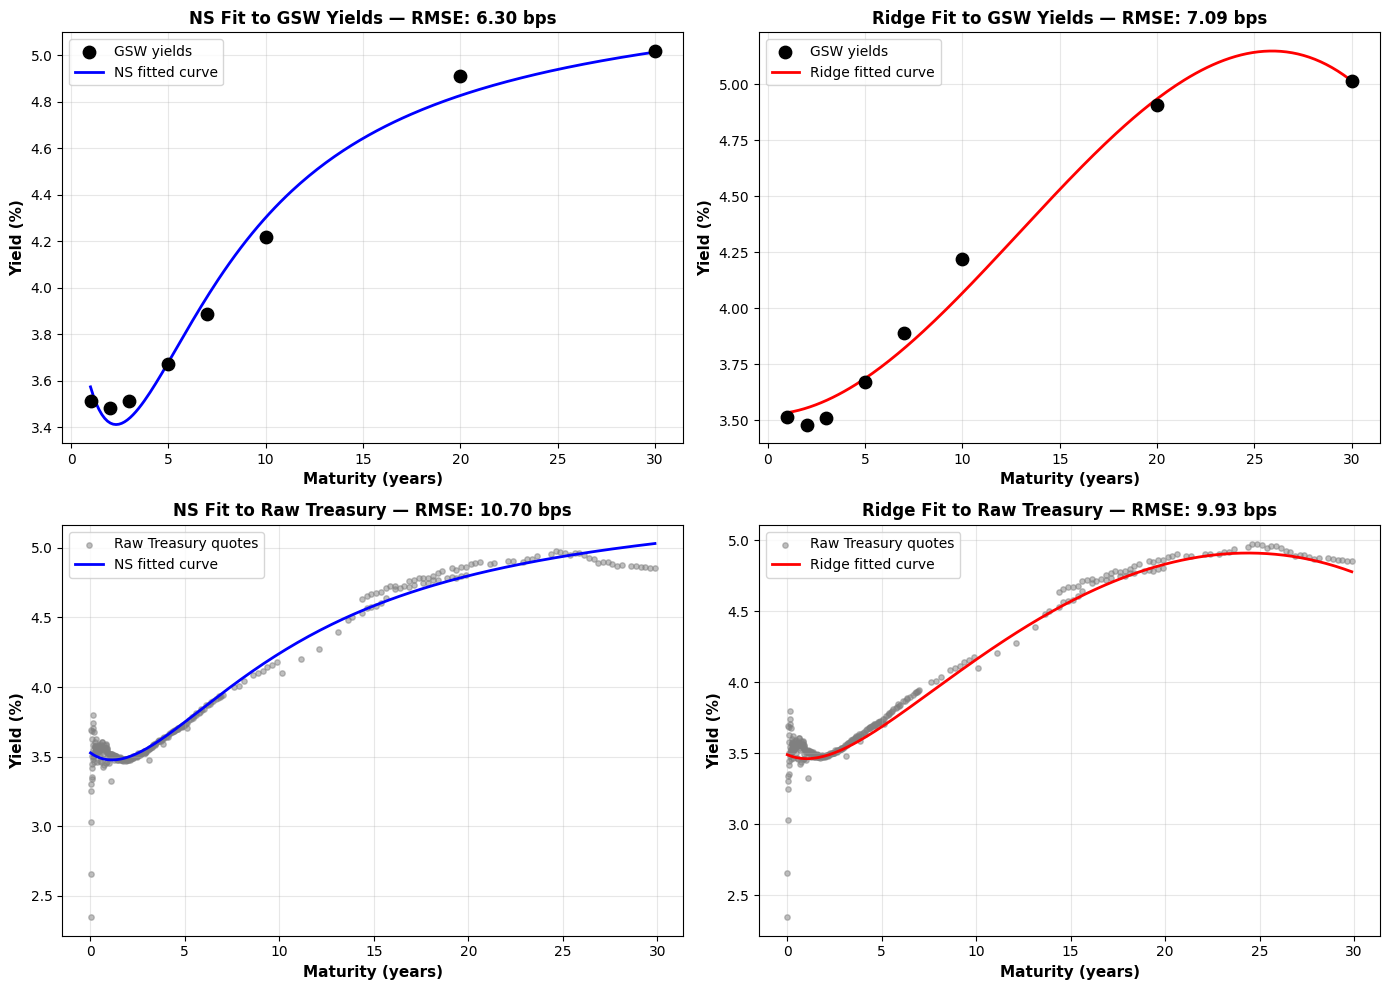

,Dataset,Fit,RMSE (bps)
0,GSW,Nelson-Siegel,6.30
1,GSW,Ridge Regression,7.09
2,Raw Treasury,Nelson-Siegel,10.70
3,Raw Treasury,Ridge Regression,9.93


In [ ]:
# === Visualize GSW vs Raw Treasury fits ===

# Prepare Matplotlib figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. GSW: Construct curve grid and feature matrix
tau_grid_gsw = np.linspace(tau_gsw.min(), tau_gsw.max(), 200)
X_grid_gsw = create_ml_features(
    tau_grid_gsw, cpn=np.zeros(len(tau_grid_gsw)), degree=3, include_ns_features=True
)

# 2. Predict GSW grid yields with NS and Ridge models
y_grid_ns_gsw = ns_yield(
    tau_grid_gsw, ns_gsw.beta0, ns_gsw.beta1, ns_gsw.beta2, ns_gsw.lam
)
y_grid_ridge_gsw = ridge_gsw_fitted.predict(X_grid_gsw)

# 3. GSW Panel 1: Nelson-Siegel fit to GSW
ax = axes[0, 0]
ax.scatter(
    tau_gsw, y_gsw * 100, s=80, color="black", zorder=5, label="GSW yields", marker="o"
)
ax.plot(
    tau_grid_gsw, y_grid_ns_gsw * 100, "b-", linewidth=2, label="NS fitted curve"
)
ax.set_xlabel("Maturity (years)", fontsize=11, fontweight="bold")
ax.set_ylabel("Yield (%)", fontsize=11, fontweight="bold")
ax.set_title(
    f"NS Fit to GSW Yields — RMSE: {ns_gsw.rmse_bps:.2f} bps",
    fontsize=12,
    fontweight="bold",
)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. GSW Panel 2: Ridge Regression fit to GSW
ax = axes[0, 1]
ax.scatter(
    tau_gsw, y_gsw * 100, s=80, color="black", zorder=5, label="GSW yields", marker="o"
)
ax.plot(
    tau_grid_gsw, y_grid_ridge_gsw * 100, "r-", linewidth=2, label="Ridge fitted curve"
)
ax.set_xlabel("Maturity (years)", fontsize=11, fontweight="bold")
ax.set_ylabel("Yield (%)", fontsize=11, fontweight="bold")
ax.set_title(
    f"Ridge Fit to GSW Yields — RMSE: {rmse_ridge_gsw:.2f} bps",
    fontsize=12,
    fontweight="bold",
)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Raw Treasury: Construct grid and features for training data
tau_grid_raw = np.linspace(tau_train.min(), tau_train.max(), 200)
X_grid_raw = create_ml_features(
    tau_grid_raw, cpn=np.zeros(len(tau_grid_raw)), degree=3, include_ns_features=True
)
y_grid_ns_raw = ns_yield(
    tau_grid_raw, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam
)
y_grid_ridge_raw = ridge_result.model.predict(X_grid_raw)

# 6. Raw Treasury Panel 3: NS fit to raw Treasury
ax = axes[1, 0]
ax.scatter(
    tau_train,
    y_train * 100,
    s=15,
    alpha=0.5,
    color="gray",
    label="Raw Treasury quotes",
)
ax.plot(
    tau_grid_raw, y_grid_ns_raw * 100, "b-", linewidth=2, label="NS fitted curve"
)
ax.set_xlabel("Maturity (years)", fontsize=11, fontweight="bold")
ax.set_ylabel("Yield (%)", fontsize=11, fontweight="bold")
ax.set_title(
    f"NS Fit to Raw Treasury — RMSE: {ns_train.rmse_bps:.2f} bps",
    fontsize=12,
    fontweight="bold",
)
ax.legend()
ax.grid(True, alpha=0.3)

# 7. Raw Treasury Panel 4: Ridge fit to raw Treasury
ax = axes[1, 1]
ax.scatter(
    tau_train,
    y_train * 100,
    s=15,
    alpha=0.5,
    color="gray",
    label="Raw Treasury quotes",
)
ax.plot(
    tau_grid_raw, y_grid_ridge_raw * 100, "r-", linewidth=2, label="Ridge fitted curve"
)
ax.set_xlabel("Maturity (years)", fontsize=11, fontweight="bold")
ax.set_ylabel("Yield (%)", fontsize=11, fontweight="bold")
ax.set_title(
    f"Ridge Fit to Raw Treasury — RMSE: {ridge_result.train_rmse:.2f} bps",
    fontsize=12,
    fontweight="bold",
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summarize fit results in a DataFrame for clean tabular display
results_summary = [
    {
        "Dataset": "GSW",
        "Fit": "Nelson-Siegel",
        "RMSE (bps)": f"{ns_gsw.rmse_bps:.2f}",
    },
    {
        "Dataset": "GSW",
        "Fit": "Ridge Regression",
        "RMSE (bps)": f"{rmse_ridge_gsw:.2f}",
    },
    {
        "Dataset": "Raw Treasury",
        "Fit": "Nelson-Siegel",
        "RMSE (bps)": f"{ns_train.rmse_bps:.2f}",
    },
    {
        "Dataset": "Raw Treasury",
        "Fit": "Ridge Regression",
        "RMSE (bps)": f"{ridge_result.train_rmse:.2f}",
    },
]

fit_results_df = pd.DataFrame(results_summary)
styled_fit_results_df = fit_results_df.style.set_caption(
    "Summary of Fit Accuracy: RMSE Comparison (Lower is Better)"
)
display(styled_fit_results_df)

### Question 6(c): Investigate GSW construction and implications


**How the GSW Dataset is Constructed**

Based on the Federal Reserve’s methodology ([Gürkaynak, Sack, and Wright, 2007](https://www.federalreserve.gov/econres/data.htm)):

1. **Parametric Model**: The Fed uses a **Svensson extension** of the Nelson-Siegel model (adding an extra curvature term):
   
   $$
   r(\tau) = \beta_0 + \beta_1 \frac{1-e^{-\tau/\lambda_1}}{\tau/\lambda_1}
   + \beta_2 \left(\frac{1-e^{-\tau/\lambda_1}}{\tau/\lambda_1} - e^{-\tau/\lambda_1}\right)
   + \beta_3 \left(\frac{1-e^{-\tau/\lambda_2}}{\tau/\lambda_2} - e^{-\tau/\lambda_2}\right)
   $$

2. **Daily Fitting**: The Fed fits this model **daily** across all outstanding Treasury securities:
    - Treasury bills (< 1 year)
    - Treasury notes (1–10 years)
    - Treasury bonds (10–30 years)

3. **Price-Based Optimization**: Parameters are estimated by minimizing **weighted price errors** (not yields):

   $$
   \min_{\beta_0,\,\beta_1,\,\beta_2,\,\beta_3,\,\lambda_1,\,\lambda_2} \sum_{i=1}^{N} w_i \left(P_i^{market} - P_i^{model}\right)^2
   $$

   Where weights $w_i$ depend on:
    - Time to maturity (more weight for liquid maturities)
    - Liquidity (on-the-run securities stronger weight)
    - Quote quality (recent quotes preferred)

4. **Smoothness Enforcement**: The model’s parametric form **inherently smooths** the curve:
    - Eliminates bond-specific noise (e.g. on-the-run premia, bid-ask effects)
    - Removes outliers and stale quotes
    - Produces arbitrage-free discount factors by construction

5. **Output**: The Fed publishes:
    - **Zero-coupon yields** (30 standard maturities, 1–30 years)
    - **Instantaneous forward rates**
    - **Fitted parameters** $(\beta_0,\,\beta_1,\,\beta_2,\,\beta_3,\,\lambda_1,\,\lambda_2)$

---

**Key Differences from Raw Treasury Quotes**

| Characteristic           | Raw Treasury Quotes             | GSW Yields               |
|-------------------------|---------------------------------|--------------------------|
| **Source**              | Direct market prices (CRSP)     | Fed’s fitted model       |
| **Noise level**         | High (bid-ask, liquidity, stale quotes) | Low (smoothed by model) |
| **Bond count**          | 300–400 per day                 | 30 standardized maturities|
| **On-the-run effects**  | Present (2–5 bps premium)       | Smoothed out             |
| **Microstructure**      | Bid-ask spreads, stale quotes   | Filtered                 |
| **Arbitrage-free**      | Not guaranteed                  | Guaranteed by construction|
| **Curve shape**         | Can have kinks, irregularities  | Always smooth            |

---

**Which dataset provides a more meaningful test?**

When *evaluating curve-fitting methods*:

- **Raw Treasury quotes are better** since they present:
    1. **Real-world challenges**: Noise, liquidity, staleness
    2. **True out-of-sample test**: Models handle data not alreay cleaned/fitted by a third party
    3. **Economic patterns**: On-the-run premia, coupon effects, maturity anomalies
    4. **Stress test for overfitting**: Noise distinguishes robust models from overfit ones

- **GSW yields are less informative** because:
    1. **Pre-smoothed**: Already fit by the Fed; refitting creates circularity
    2. **Artificially easy**: Even overfit ML models will perform well due to lack of noise
    3. **Real challenges masked**: Tested only on GSW, models may fail with actual quotes
    4. **Selection bias**: Fed’s weights have already filtered outliers, picking “good” data

> **Analogy:** Testing a spam filter only on email that’s already been filtered by another spam filter fails to show real-world performance.

---

### Pros and Cons of Each Dataset

**GSW Yields**

*Pros:*
- Clean benchmark for academic research
- Consistent time series (methodology since 1961)
- Easy study-to-study comparisons
- Eliminates data cleaning burden
- Standard maturities enable cross-country studies

*Cons:*
- Not representative of actual trading conditions
- Circular if used for refitting
- Masks overfitting problems
- Doesn’t test model robustness to microstructure noise
- Only 30 maturities (vs. 300–400 raw bonds)

**Raw Treasury Quotes**

*Pros:*
- Reflect true trading challenges
- Test most aspects of model robustness
- Economically meaningful improvements matter
- Evaluates the *full pipeline* (cleaning + fitting)
- Large sample for granular analysis

*Cons:*
- Requires thorough data cleaning
- Outliers can distort model comparison
- Less standardized for across-study work
- Time-consuming to process/evaluate
- Needs domain expertise for proper interpretation

### Question 6(d): Production recommendation


#### Choice of fitting method (NS vs. ML vs. hybrid)

For a production pricing system, the core requirement isn’t just low RMSE but it’s producing a curve that remains economically valid (i.e., retains no-arbitrage shape and smooth forwards).

- **Pure ML (tree models) is not acceptable as the primary curve generator.**  
  Even with lower RMSE, models like Random Forest or Gradient Boosting produce forward-rate curves with large discontinuities and fail smoothness checks (e.g., max jump ≈ 170+ bps with many large jumps). Such jagged curves are unusable for pricing or hedging and indicate overfitting to noise rather than capturing the true term structure.

- **A parametric or regularized smooth curve should be the production baseline.**  
  Both **NS (Nelson-Siegel)** and **regularized linear fits (ridge/lasso)** yield smooth, well-behaved curves that pass essential discount-factor and forward-rate sanity checks. For example, on 2025-12-31, ridge regression achieved lower test RMSE than NS (≈ 6.52 bps vs. 7.21 bps) while staying economically valid.

- **Hybrid approaches can be used, but only as controlled correction layers.**  
  A simple NS + ridge blend maintained validity and slightly improved upon pure NS (≈ 7.04 bps vs. 7.21 bps), but did not outperform ridge alone. This suggests ML/regularization is best for reducing small residual errors, but the final output must be projected onto a smooth economically consistent structure.

**Recommended production approach:**  
Use a **smooth baseline curve (NS or ridge)** as the “official” curve. Allow ML-style adjustments only if they are explicitly constrained to preserve smoothness and no-arbitrage properties.

---

#### Choice of calibration data (GSW vs. raw quotes)

The calibration target fundamentally affects what “good performance” means.

- **GSW is easier to fit.**  
  RMSE on GSW is significantly lower than on raw Treasury quotes (e.g., NS ≈ 6.3 bps on GSW vs. ≈ 10.7 bps on raw), which is expected since GSW is itself a smoothed, model-produced curve.

- **Raw quotes should be the target for trading and pricing.**  
  To price tradable bonds and manage risk, the system must fit **cleaned raw market quotes** (post-liquidity filtering and outlier removal). GSW should serve as a **prior, benchmark, or fallback**, not as the primary calibration target.

**Recommended production data policy:**  
- **Primary calibration:** cleaned raw quotes  
- **Secondary:** GSW for initialization, diagnostics, and as a fallback when raw data becomes unreliable or sparse

---

#### How the recommendation differs: trading desk vs. academic research

**Trading Desk (pricing & hedging):**
- Priorities:
  1. **Economic validity** (monotone discount factors, smooth and bounded forwards)
  2. **Day-to-day stability** (avoid optimizer/path dependence artifacts)
  3. **RMSE** (optimize fitting error only after conditions above are met)
- This leads to NS or ridge as the curve of choice, with conservative guardrails and fallbacks. Tree models may offer RMSE gains but aren’t acceptable if they generate unstable forwards.

**Academic Research (forecasting/comparison):**
- Using **GSW** is reasonable because it is stable and reproducible.
- Flexible ML methods can be explored to minimize RMSE and study cross-sectional error, but results should always be presented alongside curve-validity diagnostics if they're to represent a usable term structure.

---

#### Final recommendation (production system)

A production system should be centered around a **smooth, constrained curve**:
- Fit **NS or ridge** as the primary curve on **cleaned raw quotes**
- Enforce hard sanity checks (discount factors > 0, monotone decreasing DFs, forwards both bounded and smooth)
- Use **GSW** as a benchmark and fallback if market quotes are unreliable
- Permit hybrid/ML corrections only if they clear the same sanity checks and do not introduce forward-rate noise

## Question 7: Optimization Robustness
Investigate the reliability of your NS optimization across different market conditions.

### Question 7(a): Fit NS across different market regimes


In [114]:
# Select representative dates from different market conditions for NS optimization

regime_test_dates = {
    "Pre-COVID (2019-08-15)": pd.Timestamp("2019-08-15"),
    "COVID Peak (2020-03-20)": pd.Timestamp("2020-03-20"),
    "Worst NS Test RMSE (2020-08-14)": pd.Timestamp("2020-08-14"),
    "COVID Recovery (2021-06-15)": pd.Timestamp("2021-06-15"),
    "Fed Hiking (2022-09-15)": pd.Timestamp("2022-09-15"),
    "SVB Stress (2023-03-15)": pd.Timestamp("2023-03-15"),
    "Random Date (2024-06-15)": pd.Timestamp("2024-06-15"),
    "Most Recent Date (2025-12-31)": pd.Timestamp("2025-12-31"),
}

regime_fits = []
for regime_name, target_date in regime_test_dates.items():
    # Find the closest available date in the panel
    available_dates = treasury_panel[PANEL_DATE_COL].unique()
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))

    df_regime = treasury_panel[treasury_panel[PANEL_DATE_COL] == closest_date].copy()
    if len(df_regime) < 30:
        continue

    tau_regime = df_regime[PANEL_TTM_COL].to_numpy()
    y_regime = df_regime[PANEL_YTM_COL].to_numpy()
    try:
        ns_fit = fit_ns_yields_sse(tau_regime, y_regime)
        regime_fits.append({
            "regime": regime_name,
            "date": closest_date,
            "beta0": ns_fit.beta0,
            "beta1": ns_fit.beta1,
            "beta2": ns_fit.beta2,
            "lambda": ns_fit.lam,
            "rmse_bps": ns_fit.rmse_bps,
            "success": ns_fit.success,
            "n_bonds": len(df_regime),
        })
    except Exception:
        # Omit failed fits, but do not print errors
        continue

regime_fits_df = pd.DataFrame(regime_fits)

# Compute parameter ranges and RMSE range for summary table
param_summary = []
for param in ["beta0", "beta1", "beta2", "lambda"]:
    param_min = regime_fits_df[param].min()
    param_max = regime_fits_df[param].max()
    param_range = param_max - param_min
    param_summary.append({
        "Parameter": param,
        "Min": f"{param_min:.5f}",
        "Max": f"{param_max:.5f}",
        "Range": f"{param_range:.5f}"
    })
rmse_min = regime_fits_df["rmse_bps"].min()
rmse_max = regime_fits_df["rmse_bps"].max()
param_summary.append({
    "Parameter": "rmse_bps",
    "Min": f"{rmse_min:.2f}",
    "Max": f"{rmse_max:.2f}",
    "Range": f"{(rmse_max - rmse_min):.2f}"
})

summary_df = pd.DataFrame(param_summary)

# Display
display(
    regime_fits_df.style.set_caption("Nelson-Siegel Parameters Across Market Regimes")
)
display(
    summary_df.style.set_caption("NS Parameter and RMSE Ranges Across Regimes")
)

,regime,date,beta0,beta1,beta2,lambda,rmse_bps,success,n_bonds
0,Pre-COVID (2019-08-15),2019-08-16 00:00:00,0.021026,-0.000641,-0.021818,2.000019,5.514418,True,355
1,COVID Peak (2020-03-20),2020-03-20 00:00:00,0.015540,-0.014046,-0.014227,2.000113,9.823387,True,348
2,Worst NS Test RMSE (2020-08-14),2020-08-14 00:00:00,0.016276,-0.012033,-0.029858,2.000163,45.726495,True,372
3,COVID Recovery (2021-06-15),2021-06-18 00:00:00,0.023152,-0.021882,-0.027803,1.671035,7.040943,True,370
4,Fed Hiking (2022-09-15),2022-09-16 00:00:00,0.036290,-0.017699,0.033088,0.320560,10.070552,True,377
5,SVB Stress (2023-03-15),2023-03-17 00:00:00,0.037119,0.009514,-0.015259,1.999968,18.643499,True,383
6,Random Date (2024-06-15),2024-06-14 00:00:00,0.044895,0.010567,-0.019920,1.999931,9.874423,True,394
7,Most Recent Date (2025-12-31),2025-12-31 00:00:00,0.055289,-0.020012,-0.026093,3.185387,10.105317,True,401


,Parameter,Min,Max,Range
0,beta0,0.01554,0.05529,0.03975
1,beta1,-0.02188,0.01057,0.03245
2,beta2,-0.02986,0.03309,0.06295
3,lambda,0.32056,3.18539,2.86483
4,rmse_bps,5.51,45.73,40.21


### Question 7(b): Test sensitivity to initial guesses


In [120]:
# Test sensitivity of NS fit to initial guesses using a DataFrame (no prints)

initial_guesses = {
    "Default (market-informed)": None,
    "Conservative (β all small)": np.array([0.03, 0.0, 0.0, 2.0]),
    "High level": np.array([0.08, -0.03, -0.03, 2.0]),
    "Short decay": np.array([0.05, -0.02, -0.02, 0.5]),
    "Long decay": np.array([0.05, -0.02, -0.02, 5.0]),
}

sensitivity_results = []
regime_stats_results = []

for regime_name, target_date in regime_test_dates.items():
    available_dates = treasury_panel[PANEL_DATE_COL].unique()
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))

    df_regime = treasury_panel[treasury_panel[PANEL_DATE_COL] == closest_date].copy()

    if len(df_regime) < 30:
        continue

    tau_regime = df_regime[PANEL_TTM_COL].to_numpy()
    y_regime = df_regime[PANEL_YTM_COL].to_numpy()

    regime_solutions = []

    for init_name, x0 in initial_guesses.items():
        try:
            ns_fit = fit_ns_yields_sse(tau_regime, y_regime, x0=x0)
            regime_solutions.append({
                "regime": regime_name,
                "date": closest_date.date(),
                "initialization": init_name,
                "beta0": ns_fit.beta0,
                "beta1": ns_fit.beta1,
                "beta2": ns_fit.beta2,
                "lambda": ns_fit.lam,
                "rmse_bps": ns_fit.rmse_bps,
                "success": ns_fit.success,
                "error_msg": None,
            })
        except Exception as e:
            regime_solutions.append({
                "regime": regime_name,
                "date": closest_date.date(),
                "initialization": init_name,
                "beta0": np.nan,
                "beta1": np.nan,
                "beta2": np.nan,
                "lambda": np.nan,
                "rmse_bps": np.nan,
                "success": False,
                "error_msg": str(e)[:60],
            })

    if regime_solutions:
        rmse_vals = [
            sol["rmse_bps"]
            for sol in regime_solutions
            if sol["success"] and not np.isnan(sol["rmse_bps"])
        ]
        if rmse_vals:
            stats_dict = {
                "regime": regime_name,
                "date": closest_date.date(),
                "rmse_mean": np.mean(rmse_vals),
                "rmse_std": np.std(rmse_vals),
                "rmse_range": np.ptp(rmse_vals),
                "stable": np.ptp(rmse_vals) <= 1.0,
            }
        else:
            stats_dict = {
                "regime": regime_name,
                "date": closest_date.date(),
                "rmse_mean": np.nan,
                "rmse_std": np.nan,
                "rmse_range": np.nan,
                "stable": False,
            }
        regime_stats_results.append(stats_dict)
        sensitivity_results.extend(regime_solutions)

sensitivity_df = pd.DataFrame(sensitivity_results)
regime_stats_df = pd.DataFrame(regime_stats_results)

# Use .style.set_caption to title the DataFrame outputs
display(
    sensitivity_df.style.set_caption("Question 7(b): Sensitivity to Initial Guesses (NS Parameter Fits)")
)
display(
    regime_stats_df.style.set_caption("Question 7(b): RMSE Statistics Across Initializations by Regime")
)

,regime,date,initialization,beta0,beta1,beta2,lambda,rmse_bps,success,error_msg
0,Pre-COVID (2019-08-15),2019-08-16,Default (market-informed),0.021026,-0.000641,-0.021818,2.000019,5.514418,True,None
1,Pre-COVID (2019-08-15),2019-08-16,Conservative (β all small),0.021027,-0.000643,-0.021819,2.000066,5.514236,True,None
2,Pre-COVID (2019-08-15),2019-08-16,High level,0.021025,-0.000641,-0.021819,1.999457,5.516617,True,None
3,Pre-COVID (2019-08-15),2019-08-16,Short decay,0.022786,-0.003015,-0.024032,2.856485,3.984834,True,None
4,Pre-COVID (2019-08-15),2019-08-16,Long decay,0.022785,-0.003013,-0.024030,2.856076,3.984834,True,None
5,COVID Peak (2020-03-20),2020-03-20,Default (market-informed),0.015540,-0.014046,-0.014227,2.000113,9.823387,True,None
6,COVID Peak (2020-03-20),2020-03-20,Conservative (β all small),0.019793,-0.018680,0.000015,8.118803,7.787440,True,None
7,COVID Peak (2020-03-20),2020-03-20,High level,0.015541,-0.014047,-0.014230,2.000042,9.823554,True,None
8,COVID Peak (2020-03-20),2020-03-20,Short decay,0.019791,-0.018677,0.000000,8.109667,7.787439,True,None
9,COVID Peak (2020-03-20),2020-03-20,Long decay,0.018614,-0.017509,-0.006259,5.000085,7.895744,True,None


,regime,date,rmse_mean,rmse_std,rmse_range,stable
0,Pre-COVID (2019-08-15),2019-08-16,4.902988,0.749670,1.531783,False
1,COVID Peak (2020-03-20),2020-03-20,8.623513,0.980559,2.036115,False
2,Worst NS Test RMSE (2020-08-14),2020-08-14,45.800669,0.165723,0.438034,True
3,COVID Recovery (2021-06-15),2021-06-18,7.898917,1.294595,3.417609,False
4,Fed Hiking (2022-09-15),2022-09-16,15.115187,10.089269,25.223173,False
5,SVB Stress (2023-03-15),2023-03-17,16.776663,2.047382,5.853670,False
6,Random Date (2024-06-15),2024-06-14,10.317840,1.444632,4.417521,False
7,Most Recent Date (2025-12-31),2025-12-31,10.287981,0.365325,0.913314,True


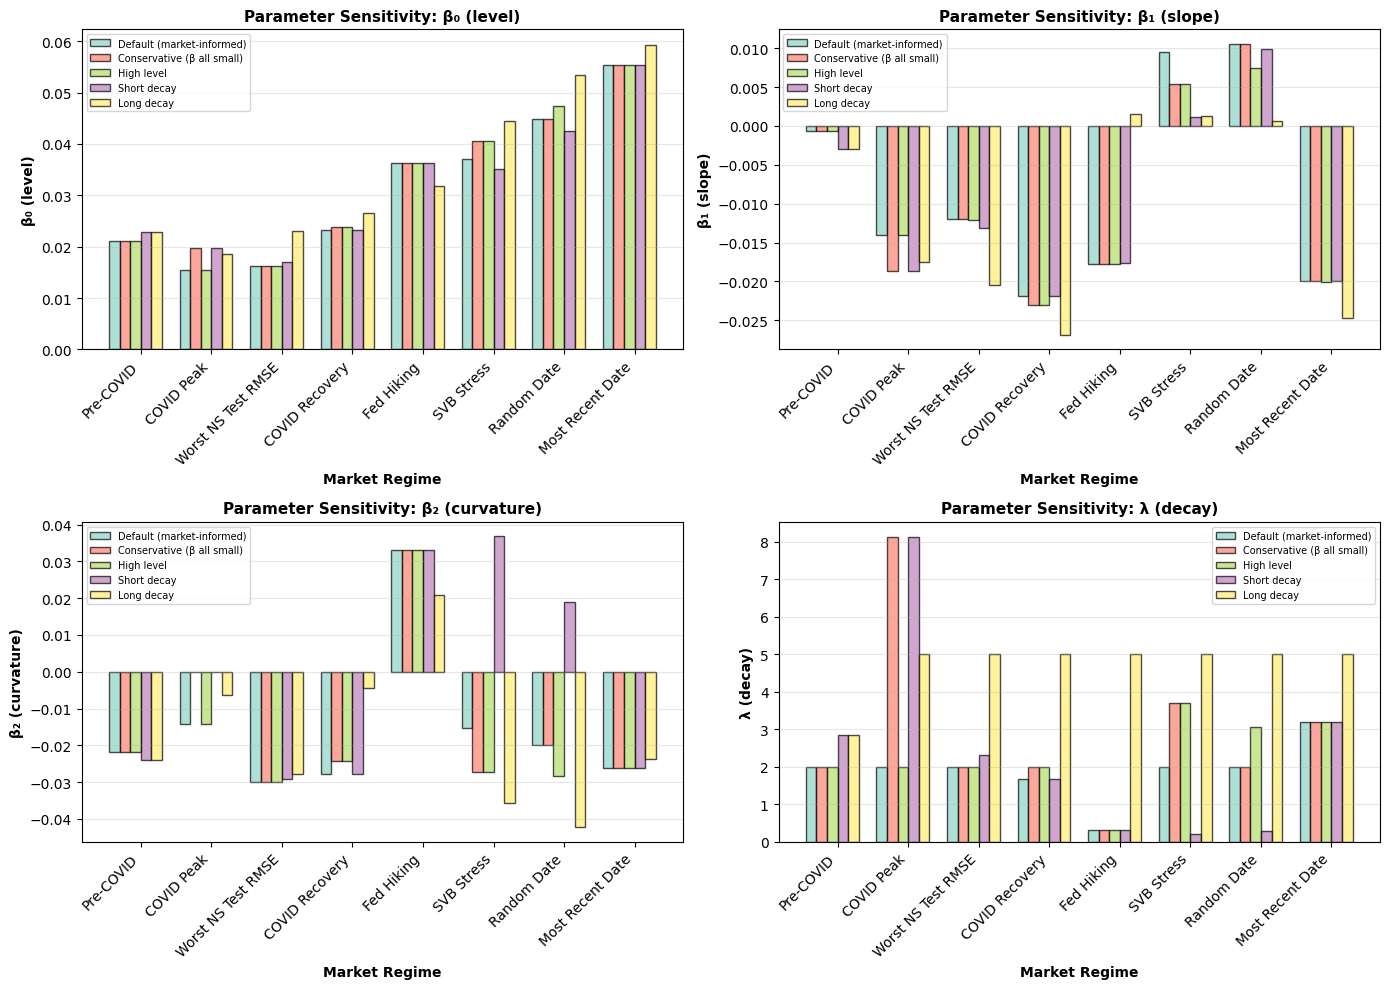

In [121]:
# Visualize the sensitivity of NS parameters to initialization across regimes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

regimes = sensitivity_df["regime"].unique()
params_to_plot = ["beta0", "beta1", "beta2", "lambda"]
param_labels = ["β₀ (level)", "β₁ (slope)", "β₂ (curvature)", "λ (decay)"]

inits = sensitivity_df["initialization"].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(inits)))
x = np.arange(len(regimes))
width = 0.15

for idx, (param, label) in enumerate(zip(params_to_plot, param_labels)):
    ax = axes[idx // 2, idx % 2]

    for i, init in enumerate(inits):
        init_data = sensitivity_df[sensitivity_df["initialization"] == init]
        values = [
            init_data[init_data["regime"] == r][param].values[0]
            if not init_data[init_data["regime"] == r][param].empty
            else 0
            for r in regimes
        ]
        offset = (i - len(inits) / 2) * width
        ax.bar(
            x + offset,
            values,
            width,
            label=init,
            color=colors[i],
            alpha=0.7,
            edgecolor="black",
        )

    ax.set_xlabel("Market Regime", fontsize=10, fontweight="bold")
    ax.set_ylabel(label, fontsize=10, fontweight="bold")
    ax.set_title(f"Parameter Sensitivity: {label}", fontsize=11, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [r.split("(")[0].strip() for r in regimes], rotation=45, ha="right"
    )
    ax.legend(fontsize=7, loc="best")
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Question 7(c): Experiment with optimization approaches


In [ ]:
# Optimization Method Comparison Across All Regimes
optimization_methods = ['L-BFGS-B', 'SLSQP', 'TNC']


def fit_ns_fix_lambda(
    tau: np.ndarray, y: np.ndarray, lam_fixed: float = 2.0
) -> tuple[np.ndarray, float]:
    """Fit NS with fixed lambda (linear in beta0, beta1, beta2)."""
    tau = np.asarray(tau, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(tau) & np.isfinite(y) & (tau > 0)
    tau, y = tau[mask], y[mask]
    L0, L1, L2 = ns_loadings(tau, lam_fixed)
    X = np.column_stack([L0, L1, L2])
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X @ beta
    rmse = rmse_bps(y, y_pred)
    return beta, rmse


method_comparison = []
available_dates = treasury_panel[PANEL_DATE_COL].unique()

for regime_name, target_date in regime_test_dates.items():
    closest_date = min(available_dates, key=lambda x: abs(x - target_date))
    df_regime = treasury_panel[treasury_panel[PANEL_DATE_COL] == closest_date].copy()
    if len(df_regime) < 30:
        continue

    tau_regime = df_regime[PANEL_TTM_COL].to_numpy()
    y_regime = df_regime[PANEL_YTM_COL].to_numpy()

    # Scipy optimizers
    for method in optimization_methods:
        try:
            start = time.time()
            ns_fit = fit_ns_yields_sse(tau_regime, y_regime, method=method)
            elapsed = time.time() - start
            method_comparison.append(
                {
                    'regime': regime_name,
                    'date': closest_date,
                    'method': method,
                    'beta0': ns_fit.beta0,
                    'beta1': ns_fit.beta1,
                    'beta2': ns_fit.beta2,
                    'lambda': ns_fit.lam,
                    'rmse_bps': ns_fit.rmse_bps,
                    'success': ns_fit.success,
                    'time_sec': elapsed,
                }
            )
        except Exception as e:
            method_comparison.append(
                {
                    'regime': regime_name,
                    'date': closest_date,
                    'method': method,
                    'beta0': None,
                    'beta1': None,
                    'beta2': None,
                    'lambda': None,
                    'rmse_bps': None,
                    'success': False,
                    'time_sec': None,
                    'error': str(e)[:50],
                }
            )

    # Fixed-lambda (linear) approach
    for lam_fixed in [1.0, 1.5, 2.0, 2.5, 3.0]:
        try:
            start = time.time()
            beta, rmse = fit_ns_fix_lambda(tau_regime, y_regime, lam_fixed=lam_fixed)
            elapsed = time.time() - start
            method_comparison.append(
                {
                    'regime': regime_name,
                    'date': closest_date,
                    'method': f'Fixed λ={lam_fixed}',
                    'beta0': beta[0],
                    'beta1': beta[1],
                    'beta2': beta[2],
                    'lambda': lam_fixed,
                    'rmse_bps': rmse,
                    'success': True,
                    'time_sec': elapsed,
                }
            )
        except Exception as e:
            method_comparison.append(
                {
                    'regime': regime_name,
                    'date': closest_date,
                    'method': f'Fixed λ={lam_fixed}',
                    'beta0': None,
                    'beta1': None,
                    'beta2': None,
                    'lambda': lam_fixed,
                    'rmse_bps': None,
                    'success': False,
                    'time_sec': None,
                    'error': str(e)[:50],
                }
            )

method_comparison_df = pd.DataFrame(method_comparison)

# Display the performance of all methods/regimes
display(
    method_comparison_df.style.set_caption(
        "Optimization Method Performance Across All Regimes"
    )
)

# Best method overall (lowest mean RMSE across regimes)
valid_rmse = method_comparison_df.dropna(subset=['rmse_bps'])
mean_rmse = (
    valid_rmse.groupby("method")['rmse_bps'].mean().sort_values()
)
best_overall = mean_rmse.idxmin()
best_mean_rmse = mean_rmse.min()

best_overall_df = pd.DataFrame(
    {
        'Best overall method': [best_overall],
        'Mean RMSE (bps)': [best_mean_rmse],
    }
)
display(best_overall_df.style.set_caption("Lowest Mean RMSE Across All Regimes"))

# Best method per regime
best_per_regime_rows = []
for regime in method_comparison_df['regime'].unique():
    sub = valid_rmse[valid_rmse['regime'] == regime]
    if sub.empty:
        continue
    idx = sub['rmse_bps'].idxmin()
    row = sub.loc[idx, ['regime', 'method', 'rmse_bps']]
    best_per_regime_rows.append(row)

best_per_regime_df = pd.DataFrame(best_per_regime_rows)
best_per_regime_df.columns = ['Regime', 'Best Method', 'Best RMSE (bps)']
display(best_per_regime_df.style.set_caption("Best Method Per Regime"))

,regime,date,method,beta0,beta1,beta2,lambda,rmse_bps,success,time_sec
0,Pre-COVID (2019-08-15),2019-08-16 00:00:00,L-BFGS-B,0.021026,-0.000641,-0.021818,2.000019,5.514418,True,0.004138
1,Pre-COVID (2019-08-15),2019-08-16 00:00:00,SLSQP,0.021026,-0.000642,-0.021818,2.000247,5.513531,True,0.003518
2,Pre-COVID (2019-08-15),2019-08-16 00:00:00,TNC,0.022257,-0.002259,-0.023541,2.571197,4.131319,False,0.030293
3,Pre-COVID (2019-08-15),2019-08-16 00:00:00,Fixed λ=1.0,0.018310,0.003034,-0.016736,1.000000,11.969845,True,0.000289
4,Pre-COVID (2019-08-15),2019-08-16 00:00:00,Fixed λ=1.5,0.019815,0.001038,-0.019981,1.500000,8.124180,True,0.000113
5,Pre-COVID (2019-08-15),2019-08-16 00:00:00,Fixed λ=2.0,0.021026,-0.000642,-0.021818,2.000000,5.514494,True,0.000090
6,Pre-COVID (2019-08-15),2019-08-16 00:00:00,Fixed λ=2.5,0.022075,-0.002077,-0.023157,2.500000,4.211572,True,0.000164
7,Pre-COVID (2019-08-15),2019-08-16 00:00:00,Fixed λ=3.0,0.023071,-0.003381,-0.024384,3.000000,4.013596,True,0.000084
8,COVID Peak (2020-03-20),2020-03-20 00:00:00,L-BFGS-B,0.015540,-0.014046,-0.014227,2.000113,9.823387,True,0.003288
9,COVID Peak (2020-03-20),2020-03-20 00:00:00,SLSQP,0.015540,-0.014046,-0.014227,2.000094,9.823432,True,0.001747


,Best overall method,Mean RMSE (bps)
0,TNC,14.042397


,Regime,Best Method,Best RMSE (bps)
7,Pre-COVID (2019-08-15),Fixed λ=3.0,4.013596
15,COVID Peak (2020-03-20),Fixed λ=3.0,8.494377
18,Worst NS Test RMSE (2020-08-14),TNC,45.696762
24,COVID Recovery (2021-06-15),L-BFGS-B,7.040943
32,Fed Hiking (2022-09-15),L-BFGS-B,10.070552
42,SVB Stress (2023-03-15),TNC,17.380108
50,Random Date (2024-06-15),TNC,8.468864
56,Most Recent Date (2025-12-31),L-BFGS-B,10.105317


### Question 7(d): Production recommendations

#### 1. Choosing Initial Values (What Worked Best in My Experiments)

**Recommendation:** *Use a market-informed warm start as the default*.

- **Primary choice:** Use yesterday’s fitted parameters (`β₀, β₁, β₂, λ`) as today’s initial guess. This supports parameter continuity and avoids rediscovering optimizer regimes.
- **If no warm start available:** Use a **market-informed seed**:
    - `β₀` ≈ long-end yield level
    - `β₁` ≈ (short-end yield − long-end yield) so that `β₀ + β₁` anchors the front end
    - `β₂` ≈ 0 (start with minimal curvature unless there’s strong evidence otherwise)
    - `λ` start near **2.0** (median across multiple regimes), but do **not** rely on a single λ seed (see below)

**Why:**  
RMSE was sensitive to initialization in several regimes. For example, in the **Fed Hiking (2022-09-16)** regime, RMSE across initializations had **`rmse_std ≈ 10.09 bps`** and **`rmse_range ≈ 25.22 bps`**—clear evidence of multiple optimizer basins and sensitivity. Some regimes were comparatively stable (e.g., "Worst NS Test RMSE" and "Most Recent Date" had very small rmse_range), so warm starts help keep fits in the "good" basin when stability exists.

**Practical Rule:** *Always run a small multi-start set even if you warm start*:
- Keep β’s from warm start, but try a grid of λ seeds (e.g., `{0.5, 1, 2, 3, 5}`) and pick the best objective value.
- This matters because λ can drift across regimes (e.g., λ ≈ **0.32** in the Fed Hiking regime and λ ≈ **3.19** in the most recent), so a single universal λ seed is risky.

---

#### 2. Fix λ or Estimate λ?

**Recommendation:** *Use a hybrid policy (fixed-by-default, estimate when needed).*

**What the experiments suggest:**
- λ often clusters near **~2.0** in stress settings (COVID peak and SVB stress examples had λ ≈ 2.0), but it is **not constant** across regimes (e.g., Fed Hiking λ ≈ 0.32; Most Recent λ ≈ 3.19).
- Fixed-λ fits can be very competitive in calm or certain stress regimes:
    - Best-per-regime results showed **fixed λ=3.0** gave the best RMSE for **Pre-COVID** and **COVID Peak**.
- However, allowing λ to move can be necessary for regime shifts (tightening/inversion environments), and performance can vary by solver/regime.

**Production recommendation:**
1. **Stage 1 (fast + stable):** Fit NS with **fixed λ** (try **λ=2.0** and **λ=3.0**; λ=3.0 was best in multiple regimes). This is linear in β’s, fast, reproducible, and hard to “blow up”.
2. **Stage 2 (only if needed):** If the fixed-λ RMSE is above a threshold or fails diagnostics, refit with **free λ** using bounds and multi-start.

**Suggested bounds for free λ (based on observed regime range):**
- Observed λ range across regimes: **0.32 to 3.19**
- In production, use a slightly padded range like **[0.25, 4.0]** (or [0.3, 5.0]) to prevent optimizer wander while still covering plausible regimes

---

#### 3. Detecting Poor Local Minima

Empirically, local minima appeared as **high sensitivity to initialization** and **large RMSE dispersion across restarts**. Recommended detection approaches:

**A. Multi-start Dispersion Checks (Most Direct)**
- Run a small batch of fits for the same day using:
    - Warm start
    - Conservative β’s / high-level β’s
    - A few λ seeds (short/long decay)
- Flag the day if either holds:
    - `rmse_range` across starts exceeds tolerance (e.g., **>3–5 bps** in normal markets)
    - `rmse_std` across starts exceeds a tolerance
- This is important because some regimes were clearly unstable (Fed Hiking saw **~25 bps** RMSE range across starts).

**B. Parameter Plausibility + Jump Filters**
- Compare today vs yesterday:
    - Large jumps in λ or β’s without a corresponding market move are red flags (often due to basin switching).
- Flag if λ lands at an implausible extreme relative to recent history (even if not at hard bounds).

**C. Fit-Quality and Shape Diagnostics (Beyond RMSE)**
- Inspect residuals by maturity bucket (front, belly, long end): poor local minima often “fit the level” but miss the belly systematically.
- Run sanity checks on implied curve behavior (e.g., extreme humps, unrealistic forwards).

**D. Solver Cross-Check**
- Solver dependence exists (e.g., **TNC** best overall mean RMSE across regimes, **L-BFGS-B** best in others).
- In production, if best solution is suspicious (high RMSE or unstable parameters), refit with an alternate solver and confirm:
    - If two solvers agree (similar RMSE + parameters), confidence is high.
    - If they disagree materially, treat as a potential local-minimum and escalate (more starts/review).

---

#### Production Recommendation:

1. **Primary fit:** Fixed λ (try λ=2.0 and λ=3.0), solve β’s by OLS, take best RMSE.
2. **If RMSE above threshold or diagnostics trigger:** Free-λ fit with bounded λ, multi-start λ seeds, robust solver (L-BFGS-B or TNC), pick best objective.
3. **Monitoring:** Log `rmse`, `rmse_range` across starts, parameter jumps vs yesterday, and maturity-bucket residual patterns.
4. **Fail-safe:** If instability persists (large `rmse_range` / implausible params), fall back to the fixed-λ solution and flag for manual review.


## Question 8: Parameter Stability Across Time
Analyze how Nelson-Siegel parameters behave over time and under stress.

### Question 8(a): Fit NS weekly across entire sample


In [128]:
# Fit Nelson-Siegel (NS) to every week in the dataset (2018-2025)
all_dates = np.sort(pd.to_datetime(treasury_panel[PANEL_DATE_COL].unique()))

weekly_ns_params = []
for date in all_dates:
    df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == date].copy()
    if len(df_date) < 30:
        continue
    
    tau_date = df_date[PANEL_TTM_COL].to_numpy()
    y_date = df_date[PANEL_YTM_COL].to_numpy()
    try:
        ns_fit = fit_ns_yields_sse(tau_date, y_date)
        short_yield = np.median(y_date[tau_date <= 2]) if np.any(tau_date <= 2) else np.nan
        long_yield = np.median(y_date[tau_date >= 10]) if np.any(tau_date >= 10) else np.nan
        slope_2s10s = long_yield - short_yield if not np.isnan(long_yield) and not np.isnan(short_yield) else np.nan

        weekly_ns_params.append({
            'date': date,
            'beta0': ns_fit.beta0,
            'beta1': ns_fit.beta1,
            'beta2': ns_fit.beta2,
            'lambda': ns_fit.lam,
            'rmse_bps': ns_fit.rmse_bps,
            'success': ns_fit.success,
            'n_bonds': len(df_date),
            'slope_2s10s': slope_2s10s,
            'yield_vol': np.std(y_date),
        })
    except Exception:
        continue

weekly_params_df = pd.DataFrame(weekly_ns_params)

# Display results summary
result_summary = pd.DataFrame({
    "Successfully Fitted Weeks": [len(weekly_params_df)],
    "Start Date": [weekly_params_df['date'].min().date() if not weekly_params_df.empty else np.nan],
    "End Date": [weekly_params_df['date'].max().date() if not weekly_params_df.empty else np.nan],
})
display(result_summary.style.set_caption("Weekly Nelson-Siegel Fit Coverage (2018-2025)"))

# Summary statistics
param_stats = weekly_params_df[['beta0', 'beta1', 'beta2', 'lambda', 'rmse_bps']].describe().T
display(param_stats.style.set_caption("NS Parameter Statistics Across All Weeks"))

,Successfully Fitted Weeks,Start Date,End Date
0,418,2018-01-05,2025-12-31


,count,mean,std,min,25%,50%,75%,max
beta0,418.000000,0.034539,0.012115,0.012695,0.023361,0.031009,0.045930,0.057832
beta1,418.000000,-0.008977,0.011163,-0.031027,-0.017637,-0.010597,-0.001740,0.016464
beta2,418.000000,-0.013805,0.017828,-0.053273,-0.026912,-0.017563,-0.000248,0.042390
lambda,418.000000,2.309228,1.136490,0.188458,1.999937,2.000030,2.000481,9.872747
rmse_bps,418.000000,14.516882,8.005947,2.737366,8.159237,11.567847,20.038540,45.726495


### Question 8(b): Visualize parameter evolution over time


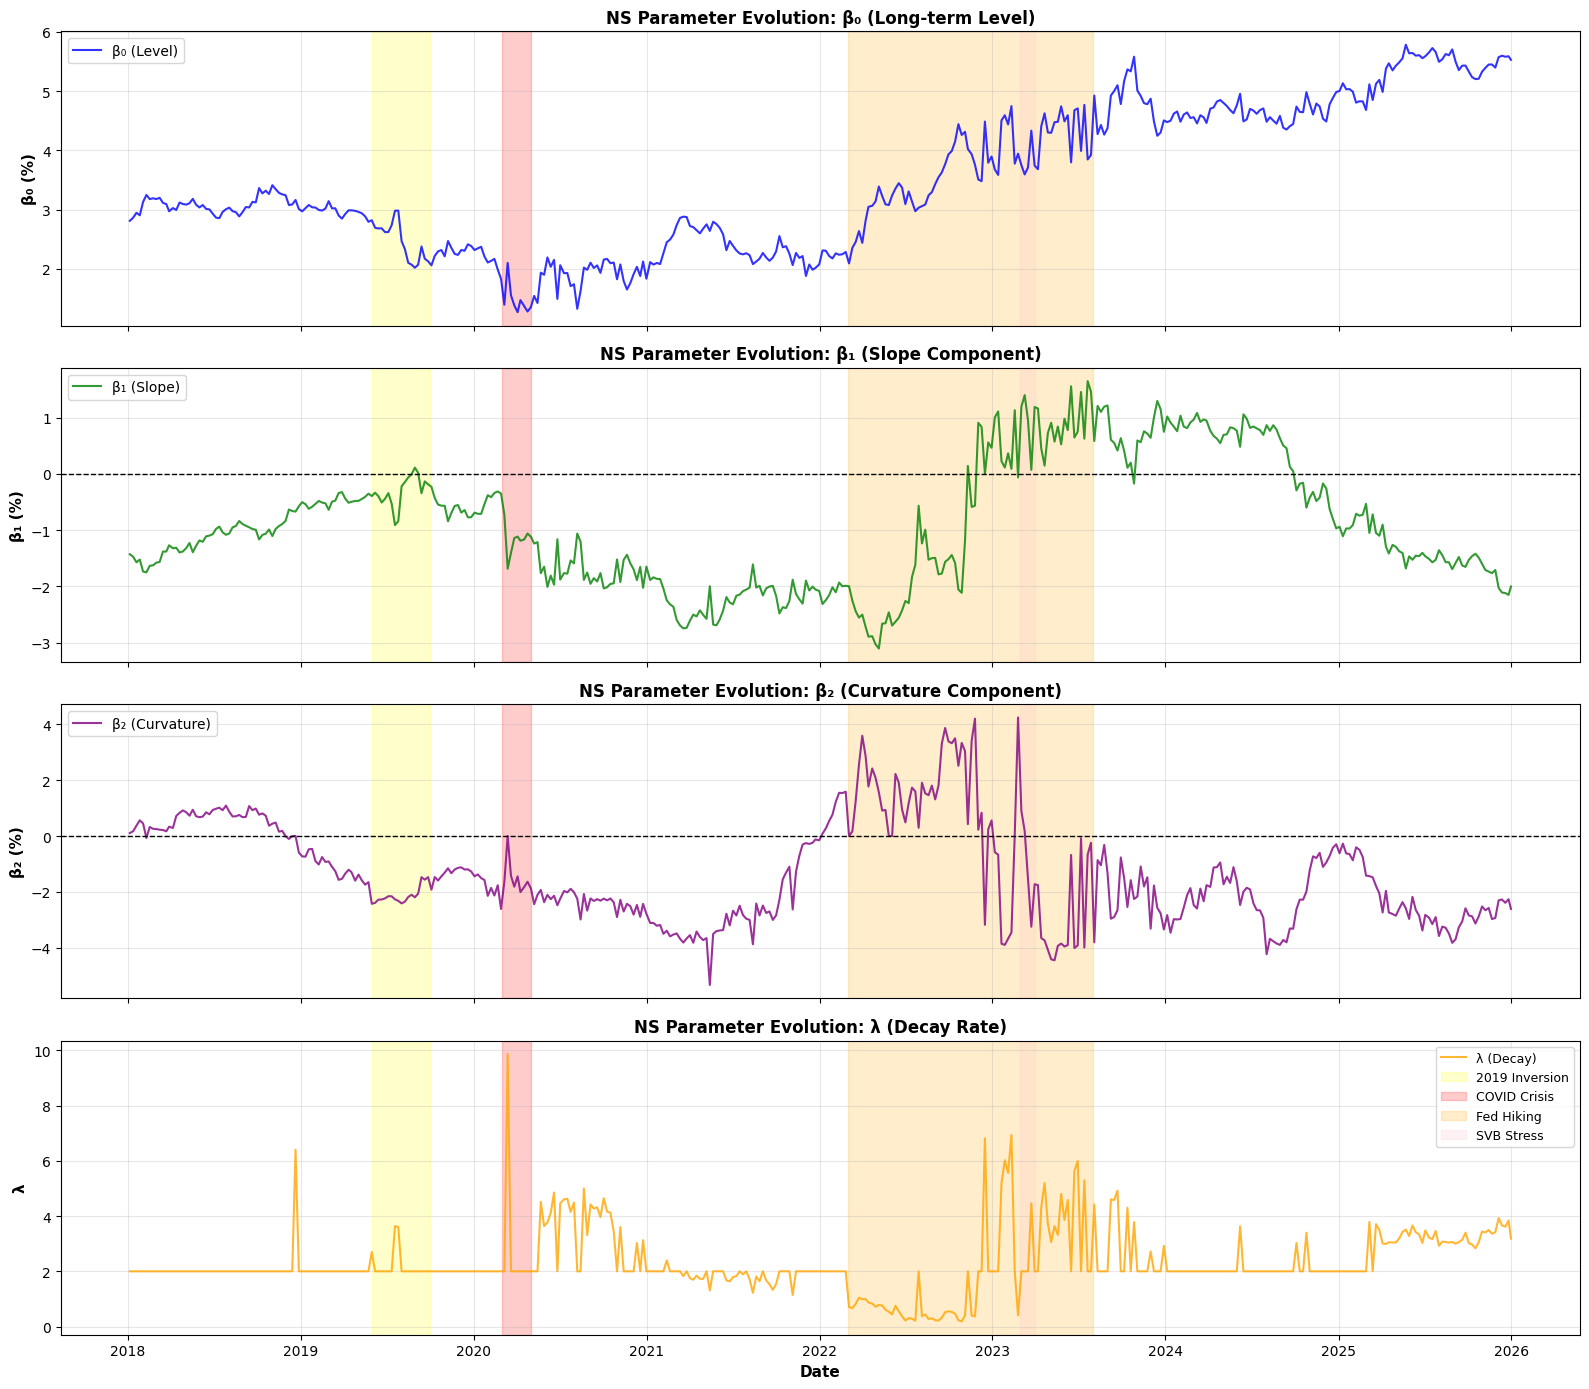

In [132]:
# Create Nelson-Siegel parameter time series plots by panel
fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

regime_periods = [
    ("2019-06-01", "2019-10-01", "2019 Inversion", "yellow"),
    ("2020-03-01", "2020-05-01", "COVID Crisis", "red"),
    ("2022-03-01", "2023-08-01", "Fed Hiking", "orange"),
    ("2023-03-01", "2023-04-01", "SVB Stress", "pink"),
]

# β₀ (Level)
ax = axes[0]
ax.plot(
    weekly_params_df["date"],
    weekly_params_df["beta0"] * 100,
    color="b",
    linewidth=1.5,
    alpha=0.8,
    label="β₀ (Level)",
)
for start, end, label, color in regime_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color)
ax.set_ylabel("β₀ (%)", fontsize=11, fontweight="bold")
ax.set_title("NS Parameter Evolution: β₀ (Long-term Level)", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# β₁ (Slope)
ax = axes[1]
ax.plot(
    weekly_params_df["date"],
    weekly_params_df["beta1"] * 100,
    color="g",
    linewidth=1.5,
    alpha=0.8,
    label="β₁ (Slope)",
)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
for start, end, label, color in regime_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color)
ax.set_ylabel("β₁ (%)", fontsize=11, fontweight="bold")
ax.set_title("NS Parameter Evolution: β₁ (Slope Component)", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# β₂ (Curvature)
ax = axes[2]
ax.plot(
    weekly_params_df["date"],
    weekly_params_df["beta2"] * 100,
    color="purple",
    linewidth=1.5,
    alpha=0.8,
    label="β₂ (Curvature)",
)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
for start, end, label, color in regime_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color)
ax.set_ylabel("β₂ (%)", fontsize=11, fontweight="bold")
ax.set_title("NS Parameter Evolution: β₂ (Curvature Component)", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# λ (Decay)
ax = axes[3]
ax.plot(
    weekly_params_df["date"],
    weekly_params_df["lambda"],
    color="orange",
    linewidth=1.5,
    alpha=0.8,
    label="λ (Decay)",
)
for start, end, label, color in regime_periods:
    show_label = label if ax == axes[3] else None  # only one legend entry per color
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color, label=show_label)
ax.set_ylabel("λ", fontsize=11, fontweight="bold")
ax.set_xlabel("Date", fontsize=11, fontweight="bold")
ax.set_title("NS Parameter Evolution: λ (Decay Rate)", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3)
# For regimes, set legend only once; groupby color for unique regime entries
handles, labels = ax.get_legend_handles_labels()
regime_legend = dict()
for h, l in zip(handles, labels):
    if l not in regime_legend:
        regime_legend[l] = h
ax.legend(
    regime_legend.values(),
    regime_legend.keys(),
    loc="upper right",
    fontsize=9,
)

plt.tight_layout()
plt.show()

### How stable is λ (the decay parameter)? Should it be fixed or estimated freely?

λ is typically **stable** around 2 but has discrete jumps across weeks and is sensitive to the optimizer and starting value. Its distribution is often concentrated in a range (e.g. 1.5–3.0), but with occasional outliers due to jumps.

**Fix λ** when you want:
- **Stability and speed:** the problem becomes linear in β₀, β₁, β₂ (OLS), so no nonlinear optimization, faster and more robust.
- **Comparability** across dates or models (same curve shape).
- **Parsimony** if the data are noisy or the cross‑section is thin.

**Estimate λ freely** when you want:
- **Fit quality** to matter more than stability (e.g. rich cross‑sections, low noise).
- **Time‑varying curvature location** (λ governs where the curvature factor loads).

**Practical takeaway:** For many applications (especially weekly panels or when comparing across regimes), fixing λ at a conventional value (e.g. 2.0) is a good default; use free λ only when you need the extra flexibility and have enough data to estimate it reliably.

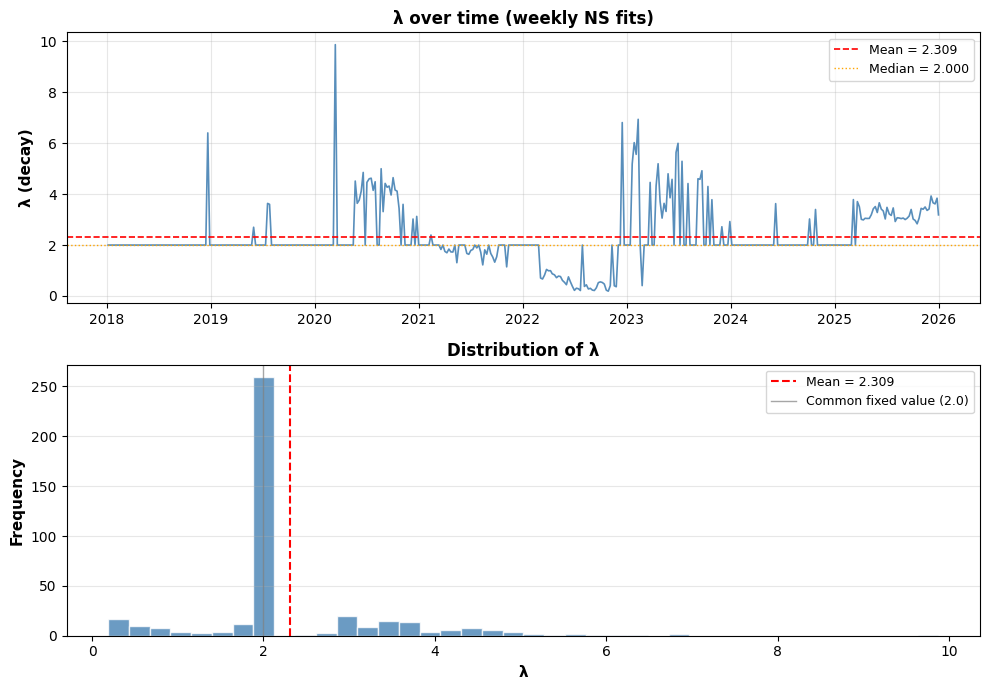

λ: mean = 2.3092, std = 1.1365, CV = 49.22%
λ: min = 0.1885, max = 9.8727, range = 9.6843


In [ ]:
# Stability of λ (decay parameter)
lam_series = weekly_params_df["lambda"].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# Time series of λ
ax = axes[0]
ax.plot(weekly_params_df["date"], weekly_params_df["lambda"], color="steelblue", linewidth=1.2, alpha=0.9)
ax.axhline(lam_series.mean(), color="red", linestyle="--", linewidth=1.2, label=f"Mean = {lam_series.mean():.3f}")
ax.axhline(lam_series.median(), color="orange", linestyle=":", linewidth=1, label=f"Median = {lam_series.median():.3f}")
ax.set_ylabel("λ (decay)", fontsize=11, fontweight="bold")
ax.set_title("λ over time (weekly NS fits)", fontsize=12, fontweight="bold")
ax.legend(loc="best", fontsize=9)
ax.grid(True, alpha=0.3)

# Distribution of λ
ax = axes[1]
ax.hist(lam_series, bins=40, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(lam_series.mean(), color="red", linestyle="--", linewidth=1.5, label=f"Mean = {lam_series.mean():.3f}")
ax.axvline(2.0, color="gray", linestyle="-", linewidth=1, alpha=0.7, label="Common fixed value (2.0)")
ax.set_xlabel("λ", fontsize=11, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=11, fontweight="bold")
ax.set_title("Distribution of λ", fontsize=12, fontweight="bold")
ax.legend(loc="best", fontsize=9)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Summary stats
lam_mean = lam_series.mean()
lam_std = lam_series.std()
lam_cv = lam_std / lam_mean if lam_mean != 0 else np.nan  # coefficient of variation
print(f"λ: mean = {lam_mean:.4f}, std = {lam_std:.4f}, CV = {lam_cv:.2%}")
print(f"λ: min = {lam_series.min():.4f}, max = {lam_series.max():.4f}, range = {lam_series.max() - lam_series.min():.4f}")

### Do the interpretations of β₀ as "level" and β₁ as "slope" hold empirically?

- Compare β₀ ("level") to the 10-year yield.
- Compare β₁ ("slope") to the 2s10s spread.

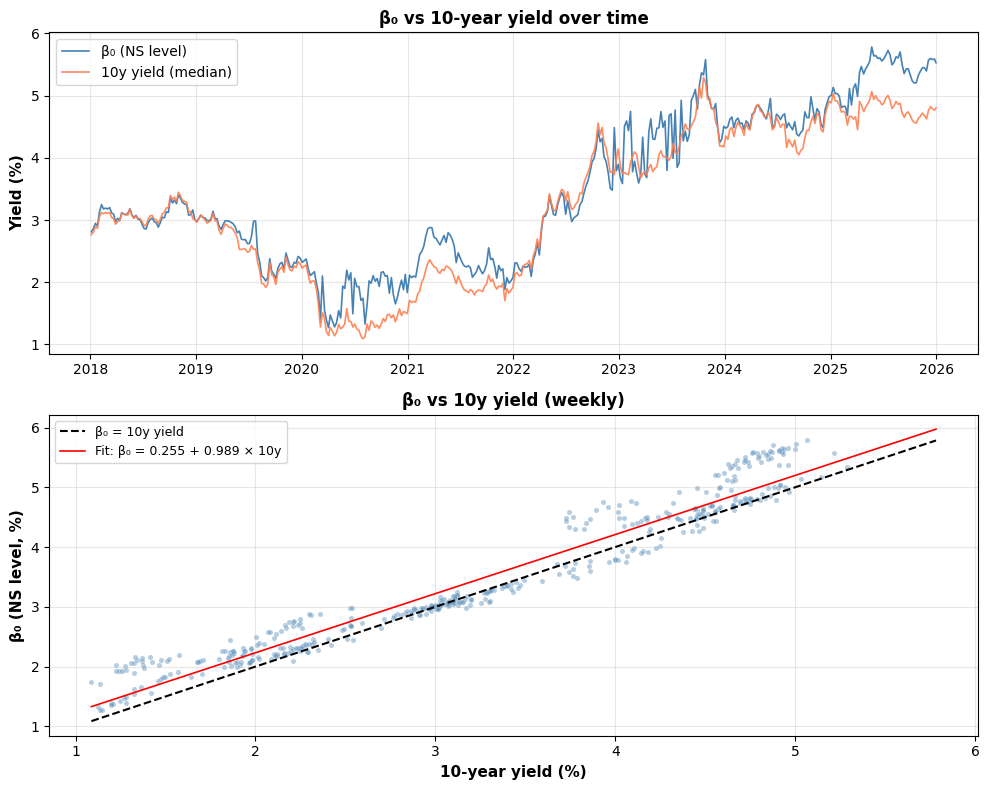

Correlation(β₀, 10y yield) = 0.9711


In [151]:
# --- Add 10y yield for each week (median of yields with ttm >= 10) ---
def get_10y_yield_by_date(panel, date_col, ttm_col, ytm_col):
    """For each date, median yield of bonds with maturity >= 10y (decimal)."""
    out = []
    for date in panel[date_col].unique():
        df = panel[panel[date_col] == date]
        long = df[df[ttm_col] >= 10][ytm_col]
        y10 = np.median(long) if len(long) > 0 else np.nan
        out.append({"date": date, "yield_10y": y10})
    return pd.DataFrame(out)

y10_df = get_10y_yield_by_date(
    treasury_panel, PANEL_DATE_COL, PANEL_TTM_COL, PANEL_YTM_COL
)
weekly_with_10y = weekly_params_df.merge(y10_df, on="date", how="left")

# --- Plot: β₀ vs 10y yield ---
df = weekly_with_10y[["beta0", "yield_10y"]].dropna()
x = df["yield_10y"].values * 100   # %
y = df["beta0"].values * 100      # %

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Time series: β₀ and 10y yield
ax = axes[0]
ax.plot(weekly_with_10y["date"], weekly_with_10y["beta0"] * 100, color="steelblue", linewidth=1.2, label="β₀ (NS level)")
ax.plot(weekly_with_10y["date"], weekly_with_10y["yield_10y"] * 100, color="coral", linewidth=1.2, alpha=0.9, label="10y yield (median)")
ax.set_ylabel("Yield (%)", fontsize=11, fontweight="bold")
ax.set_title("β₀ vs 10-year yield over time", fontsize=12, fontweight="bold")
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

# Scatter: β₀ vs 10y yield (theory: β₀ ≈ long-run level ≈ 10y)
ax = axes[1]
ax.scatter(x, y, alpha=0.4, s=14, c="steelblue", edgecolors="white", linewidths=0.3)
# 45° line (β₀ = 10y)
x_line = np.array([min(x.min(), y.min()), max(x.max(), y.max())])
ax.plot(x_line, x_line, "k--", linewidth=1.5, label="β₀ = 10y yield")
# OLS fit
b, a = np.polyfit(x, y, 1)
ax.plot(x_line, a + b * x_line, "r-", linewidth=1.2, label=f"Fit: β₀ = {a:.3f} + {b:.3f} × 10y")
ax.set_xlabel("10-year yield (%)", fontsize=11, fontweight="bold")
ax.set_ylabel("β₀ (NS level, %)", fontsize=11, fontweight="bold")
ax.set_title("β₀ vs 10y yield (weekly)", fontsize=12, fontweight="bold")
ax.legend(loc="best", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation
r = np.corrcoef(x, y)[0, 1]
print(f"Correlation(β₀, 10y yield) = {r:.4f}")

#### Understanding Nelson-Siegel $\beta_1$ and the 10–2 Slope

In the Nelson-Siegel (NS) yield curve model, the "slope" factor loading is:

$$ 
L_1(\tau) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} 
$$

- At **short maturities** ($\tau \to 0$), this loading approaches 1.
- At **long maturities** ($\tau \to \infty$), it approaches 0.

Therefore:

- **Short rate:** $\quad r_{\text{short}} \approx \beta_0 + \beta_1$
- **Long rate:** $\quad r_{\text{long}} \approx \beta_0$

So, the slope of the curve (long rate minus short rate) is:

$$
r_{\text{long}} - r_{\text{short}} \approx -\beta_1
$$

The *10–2 spread* (difference between 10-year and 2-year yields) is often referenced as a measure of yield curve steepness:

$$
\text{10--2 spread} = r_{10y} - r_{2y}
$$

Thus, we have the (approximate) relationship: **10–2 spread $\approx -\beta_1$**; that is, the spread and $\beta_1$ have opposite signs.

- If the yield curve is upward-sloping ($10\text{--}2 > 0$), then $\beta_1 < 0$.
- If the curve is inverted ($10\text{--}2 < 0$), then $\beta_1 > 0$.

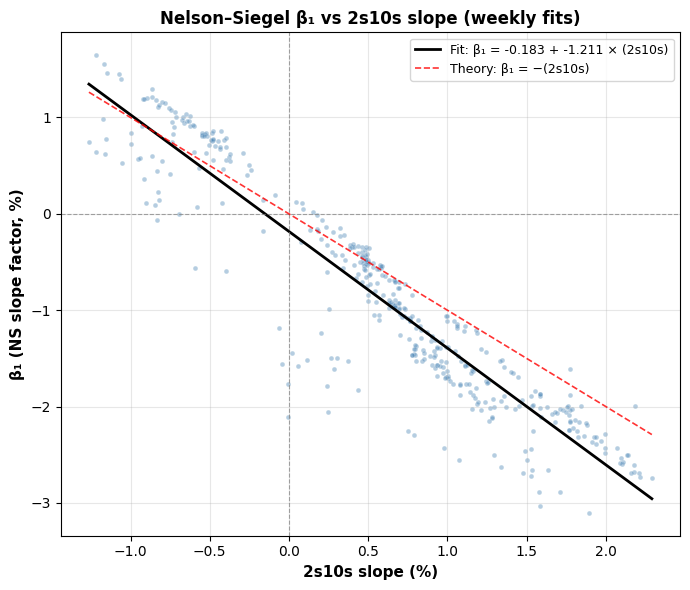

In [149]:
# β₁ vs 2s10s slope: expect opposite sign (10-2 ≈ −β₁)
df = weekly_params_df[["beta1", "slope_2s10s"]].dropna()
x = df["slope_2s10s"].values * 100   # %
y = df["beta1"].values * 100         # %

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=12, c="steelblue", edgecolors="white", linewidths=0.3)

# OLS line
b, a = np.polyfit(x, y, 1)
x_line = np.array([x.min(), x.max()])
ax.plot(x_line, a + b * x_line, "k-", linewidth=2, label=f"Fit: β₁ = {a:.3f} + {b:.3f} × (2s10s)")

# Theory: slope_2s10s ≈ −β₁  =>  β₁ = −(2s10s)  (line through origin, slope −1)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axvline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.plot(x_line, -x_line, "r--", linewidth=1.2, alpha=0.8, label="Theory: β₁ = −(2s10s)")

ax.set_xlabel("2s10s slope (%)", fontsize=11, fontweight="bold")
ax.set_ylabel("β₁ (NS slope factor, %)", fontsize=11, fontweight="bold")
ax.set_title("Nelson–Siegel β₁ vs 2s10s slope (weekly fits)", fontsize=12, fontweight="bold")
ax.legend(loc="best", fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Question 8(c): Focus on Two Stress Periods


#### Define Stress Periods and Extract Data

In [152]:
# Define the two stress periods for detailed analysis
stress_periods_detailed = {
    'COVID Crisis': {
        'start': pd.Timestamp('2020-03-01'),
        'end': pd.Timestamp('2020-05-31'),
        'description': 'Extreme volatility, flight to quality'
    },
    'SVB Collapse': {
        'start': pd.Timestamp('2023-03-01'),
        'end': pd.Timestamp('2023-04-30'),
        'description': 'Banking stress, curve inversion'
    }
}

# Extract data for each stress period
stress_data = {}
for period_name, period_info in stress_periods_detailed.items():
    mask = (weekly_params_df['date'] >= period_info['start']) & \
           (weekly_params_df['date'] <= period_info['end'])
    stress_data[period_name] = weekly_params_df[mask].copy()
    
# Display summary of data availability
summary_data = []
for period_name, df in stress_data.items():
    summary_data.append({
        'Period': period_name,
        'Start Date': df['date'].min().date() if len(df) > 0 else 'N/A',
        'End Date': df['date'].max().date() if len(df) > 0 else 'N/A',
        'Number of Weeks': len(df),
        'Description': stress_periods_detailed[period_name]['description']
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df.style.set_caption("Stress Period Data Summary"))

,Period,Start Date,End Date,Number of Weeks,Description
0,COVID Crisis,2020-03-06,2020-05-29,13,"Extreme volatility, flight to quality"
1,SVB Collapse,2023-03-03,2023-04-28,9,"Banking stress, curve inversion"


####  Week-over-Week Parameter Changes During Stress

In [153]:
# Calculate week-over-week changes for stress periods
def analyze_wow_changes(df, period_name):
    """
    Analyze week-over-week parameter changes for a given period.
    Returns summary statistics and detailed changes.
    """
    # Ensure data is sorted by date
    df = df.sort_values('date').copy()
    
    # Calculate week-over-week changes
    df['wow_beta0'] = df['beta0'].diff() * 1e4  # in bps
    df['wow_beta1'] = df['beta1'].diff() * 1e4  # in bps
    df['wow_beta2'] = df['beta2'].diff() * 1e4  # in bps
    df['wow_lambda'] = df['lambda'].diff()
    df['wow_rmse'] = df['rmse_bps'].diff()
    
    # Summary statistics
    stats = {
        'Period': period_name,
        'β₀ Mean Change (bps)': df['wow_beta0'].mean(),
        'β₀ Std Change (bps)': df['wow_beta0'].std(),
        'β₀ Max |Change| (bps)': df['wow_beta0'].abs().max(),
        'β₁ Mean Change (bps)': df['wow_beta1'].mean(),
        'β₁ Std Change (bps)': df['wow_beta1'].std(),
        'β₁ Max |Change| (bps)': df['wow_beta1'].abs().max(),
        'β₂ Mean Change (bps)': df['wow_beta2'].mean(),
        'β₂ Std Change (bps)': df['wow_beta2'].std(),
        'β₂ Max |Change| (bps)': df['wow_beta2'].abs().max(),
        'λ Mean Change': df['wow_lambda'].mean(),
        'λ Std Change': df['wow_lambda'].std(),
        'λ Max |Change|': df['wow_lambda'].abs().max(),
        'RMSE Mean Change (bps)': df['wow_rmse'].mean(),
        'RMSE Std Change (bps)': df['wow_rmse'].std(),
    }
    
    return df, stats

# Analyze both periods
covid_df, covid_stats = analyze_wow_changes(stress_data['COVID Crisis'], 'COVID Crisis')
svb_df, svb_stats = analyze_wow_changes(stress_data['SVB Collapse'], 'SVB Collapse')

# Create comparison DataFrame
comparison_stats = pd.DataFrame([covid_stats, svb_stats])
comparison_stats = comparison_stats.set_index('Period')

display(comparison_stats.style.set_caption("Week-over-Week Parameter Changes During Stress Periods").format(precision=3))

,β₀ Mean Change (bps),β₀ Std Change (bps),β₀ Max |Change| (bps),β₁ Mean Change (bps),β₁ Std Change (bps),β₁ Max |Change| (bps),β₂ Mean Change (bps),β₂ Std Change (bps),β₂ Max |Change| (bps),λ Mean Change,λ Std Change,λ Max |Change|,RMSE Mean Change (bps),RMSE Std Change (bps)
Period,,,,,,,,,,,,,,
COVID Crisis,4.211,32.979,70.534,-7.695,35.069,96.008,-6.037,74.360,164.501,0.137,3.449,7.873,0.372,6.829
SVB Collapse,6.893,44.987,72.424,-5.782,67.357,111.653,-62.183,115.331,189.760,0.214,1.695,2.462,-0.130,10.627


#### Detailed Parameter Trajectories

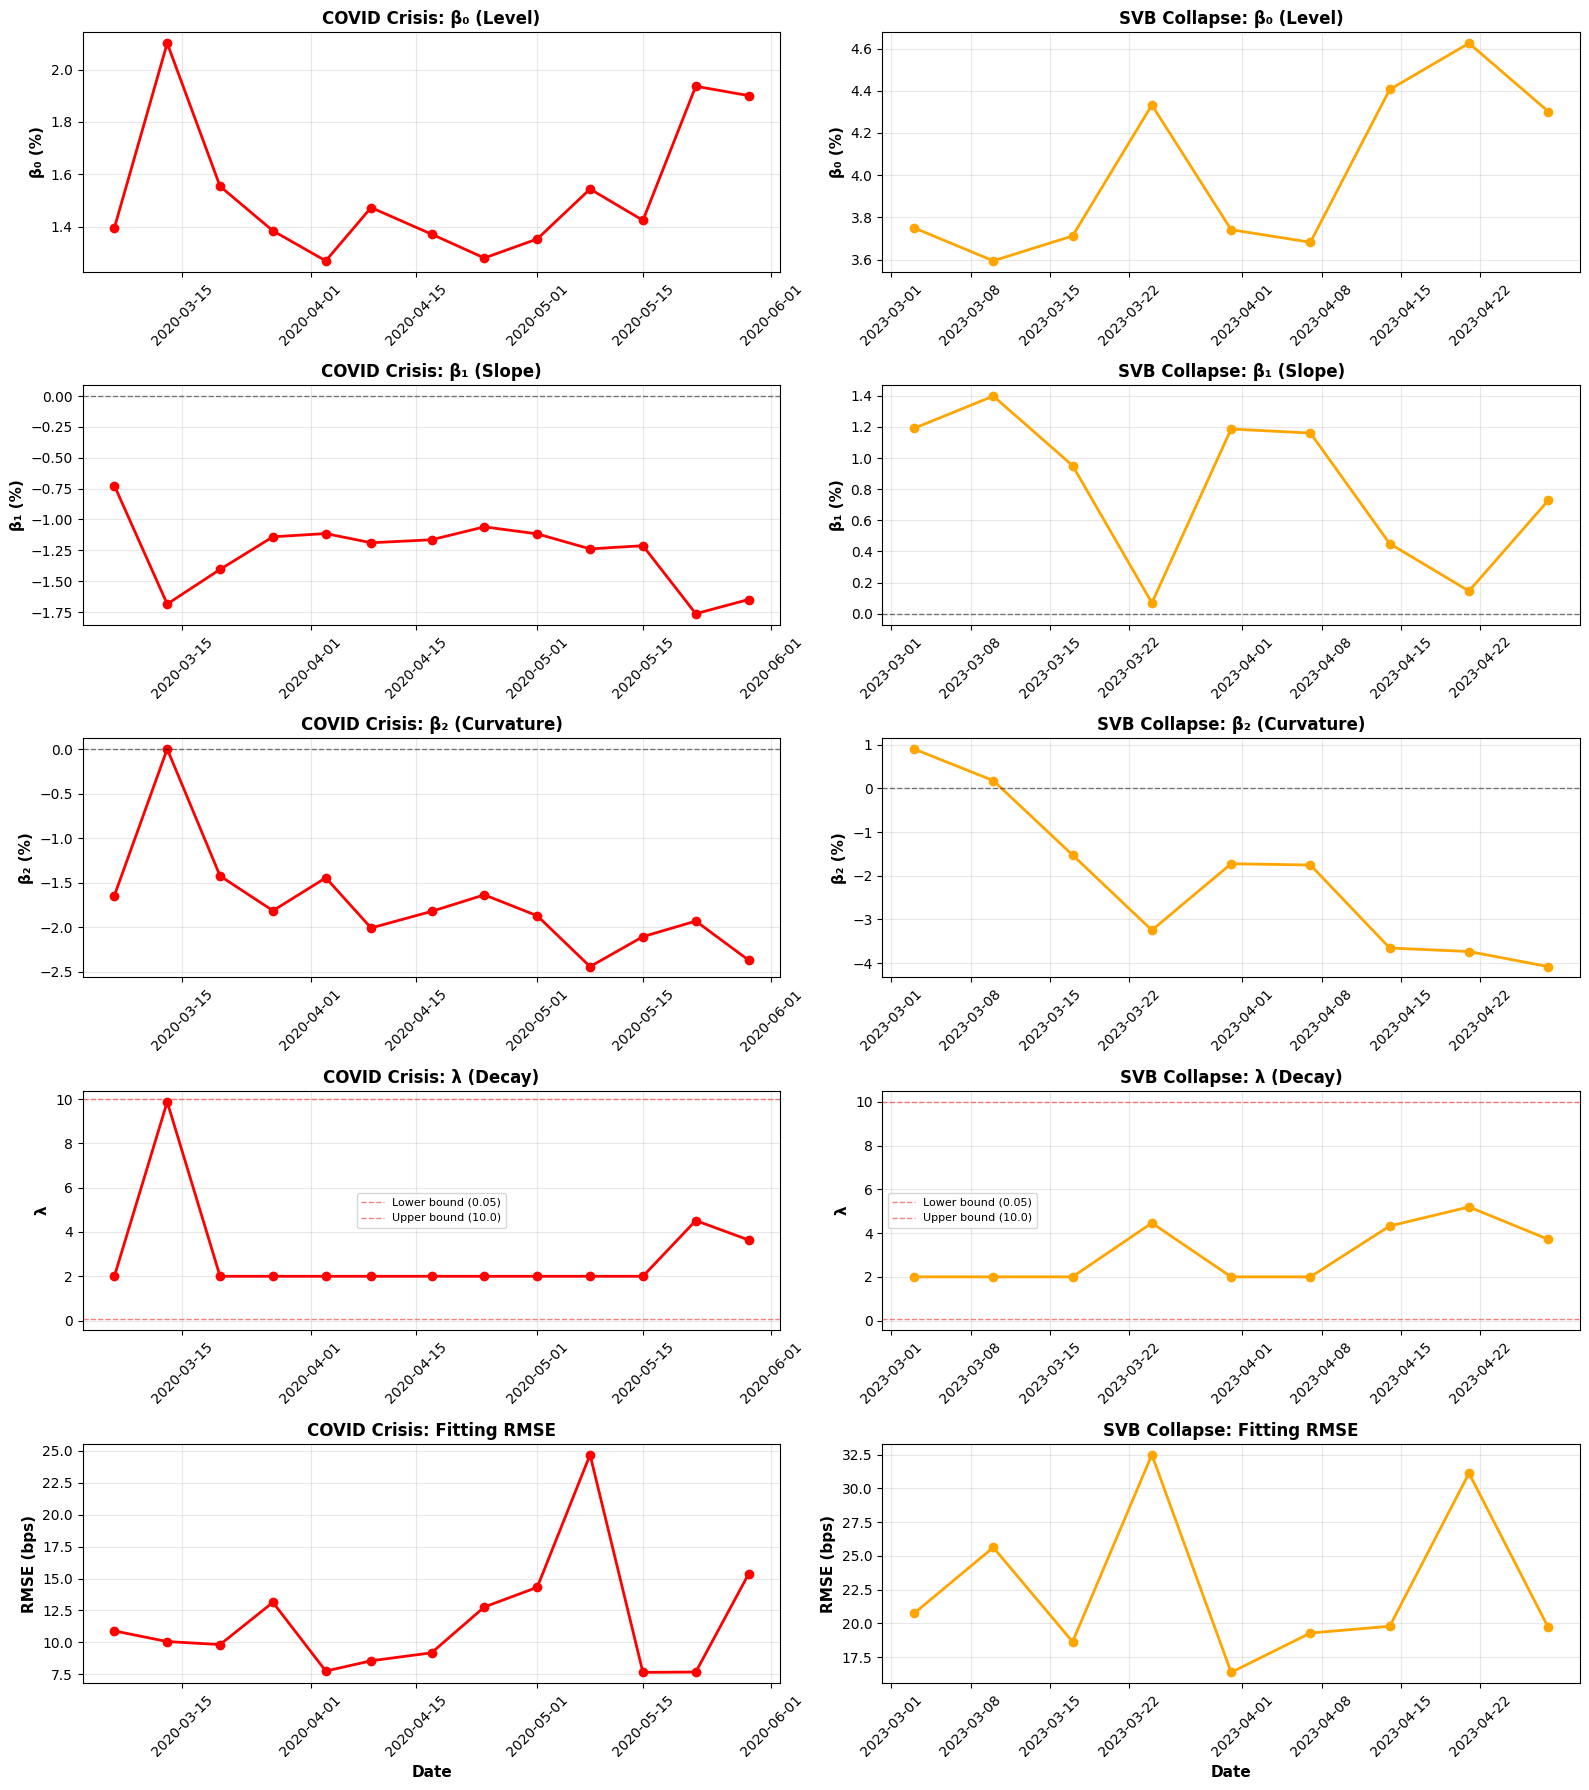

In [154]:
# Create detailed trajectory plots for both stress periods
fig, axes = plt.subplots(5, 2, figsize=(16, 18))

periods = [('COVID Crisis', covid_df), ('SVB Collapse', svb_df)]
colors = ['red', 'orange']

for col_idx, (period_name, df) in enumerate(periods):
    # β₀ trajectory
    ax = axes[0, col_idx]
    ax.plot(df['date'], df['beta0'] * 100, 'o-', linewidth=2, markersize=6, color=colors[col_idx])
    ax.set_ylabel('β₀ (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{period_name}: β₀ (Level)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # β₁ trajectory
    ax = axes[1, col_idx]
    ax.plot(df['date'], df['beta1'] * 100, 'o-', linewidth=2, markersize=6, color=colors[col_idx])
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('β₁ (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{period_name}: β₁ (Slope)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # β₂ trajectory
    ax = axes[2, col_idx]
    ax.plot(df['date'], df['beta2'] * 100, 'o-', linewidth=2, markersize=6, color=colors[col_idx])
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('β₂ (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{period_name}: β₂ (Curvature)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # λ trajectory with bounds
    ax = axes[3, col_idx]
    ax.plot(df['date'], df['lambda'], 'o-', linewidth=2, markersize=6, color=colors[col_idx])
    # Add optimization bounds from our earlier code
    ax.axhline(0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Lower bound (0.05)')
    ax.axhline(10.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Upper bound (10.0)')
    ax.set_ylabel('λ', fontsize=11, fontweight='bold')
    ax.set_title(f'{period_name}: λ (Decay)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # RMSE trajectory
    ax = axes[4, col_idx]
    ax.plot(df['date'], df['rmse_bps'], 'o-', linewidth=2, markersize=6, color=colors[col_idx])
    ax.set_ylabel('RMSE (bps)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_title(f'{period_name}: Fitting RMSE', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Lambda Instability Analysis

In [157]:
def analyze_lambda_stability(df, period_name):
    """
    Analyze λ stability within a dataframe for a given period.
    Computes boundary counts, jump statistics, and volatility metrics.
    """
    lower_bound = 0.05
    upper_bound = 10.0

    # Check λ proximity to bounds
    n_lower_hits = (df["lambda"] <= lower_bound + 0.01).sum()
    n_upper_hits = (df["lambda"] >= upper_bound - 0.1).sum()

    # Identify large week-over-week λ jumps
    lambda_jumps = df["lambda"].diff().abs()
    large_jumps = lambda_jumps[lambda_jumps > 1.0]

    # Compute volatility and summary stats
    lambda_range = df["lambda"].max() - df["lambda"].min()
    lambda_std = df["lambda"].std()
    lambda_mean = df["lambda"].mean()
    lambda_cv = lambda_std / lambda_mean if lambda_mean > 0 else np.nan

    results = {
        "Period": period_name,
        "Mean λ": lambda_mean,
        "Std λ": lambda_std,
        "Coefficient of Variation": lambda_cv,
        "Range (max - min)": lambda_range,
        "Near Lower Bound (0.05)": n_lower_hits,
        "Near Upper Bound (10.0)": n_upper_hits,
        "Number of Large Jumps (>1.0)": len(large_jumps),
        "Max Single Jump": lambda_jumps.max(),
        "Weeks with λ ≈ 2.0 (±0.1)": ((df["lambda"] >= 1.9) & (df["lambda"] <= 2.1)).sum(),
    }
    return results, large_jumps

# Analyze both periods and collect stats
covid_lambda_stats, covid_jumps = analyze_lambda_stability(covid_df, "COVID Crisis")
svb_lambda_stats, svb_jumps = analyze_lambda_stability(svb_df, "SVB Collapse")

lambda_stability_df = pd.DataFrame([covid_lambda_stats, svb_lambda_stats]).set_index("Period")
display(lambda_stability_df.style.set_caption("λ Stability Analysis During Stress Periods").format(precision=4))

# Large λ jumps details for COVID and SVB periods
covid_jump_details = None
if not covid_jumps.empty:
    covid_jump_details = covid_df.loc[covid_jumps.index, ["date", "lambda", "wow_lambda", "rmse_bps"]].copy()
    covid_jump_details["date"] = covid_jump_details["date"].dt.date
    display(covid_jump_details.style.set_caption("COVID: Large λ Jumps"))
else:
    empty_covid = pd.DataFrame(columns=["date", "lambda", "wow_lambda", "rmse_bps"])
    display(empty_covid.style.set_caption("COVID: No large λ jumps detected"))

svb_jump_details = None
if not svb_jumps.empty:
    svb_jump_details = svb_df.loc[svb_jumps.index, ["date", "lambda", "wow_lambda", "rmse_bps"]].copy()
    svb_jump_details["date"] = svb_jump_details["date"].dt.date
    display(svb_jump_details.style.set_caption("SVB: Large λ Jumps"))
else:
    empty_svb = pd.DataFrame(columns=["date", "lambda", "wow_lambda", "rmse_bps"])
    display(empty_svb.style.set_caption("SVB: No large λ jumps detected"))


,Mean λ,Std λ,Coefficient of Variation,Range (max - min),Near Lower Bound (0.05),Near Upper Bound (10.0),Number of Large Jumps (>1.0),Max Single Jump,Weeks with λ ≈ 2.0 (±0.1)
Period,,,,,,,,,
COVID Crisis,2.9253,2.2336,0.7635,7.8727,0,0,3,7.8727,10
SVB Collapse,3.0774,1.3307,0.4324,3.1949,0,0,4,2.4616,5


,date,lambda,wow_lambda,rmse_bps
114,2020-03-13,9.872747,7.872689,10.059625
115,2020-03-20,2.000113,-7.872634,9.823387
124,2020-05-22,4.515296,2.515163,7.672722


,date,lambda,wow_lambda,rmse_bps
272,2023-03-24,4.461590,2.461622,32.482655
273,2023-03-31,1.999954,-2.461635,16.379177
275,2023-04-14,4.325260,2.325298,19.790910
277,2023-04-28,3.714634,-1.480249,19.700517


#### RMSE Evolution During Stress

,Period,Mean RMSE (bps),Median RMSE (bps),Max RMSE (bps),Std RMSE (bps)
0,COVID Baseline (2019-Feb 2020),9.34,8.65,36.49,4.21
1,COVID Crisis (Mar-May 2020),11.68,10.06,24.70,4.69
2,SVB Baseline (2022-Feb 2023),15.62,13.35,34.02,7.01
3,SVB Collapse (Mar-Apr 2023),22.64,19.79,32.48,5.75


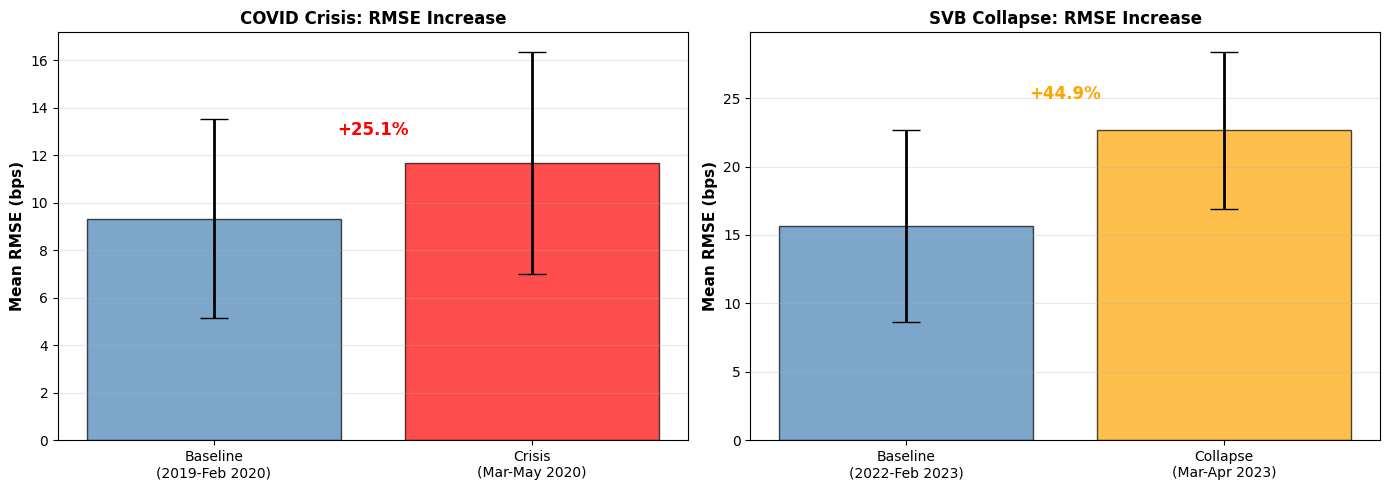

In [156]:
# Compare RMSE during stress vs. baseline
# Calculate baseline (pre-stress) RMSE statistics
covid_baseline_mask = (weekly_params_df['date'] >= pd.Timestamp('2019-01-01')) & \
                       (weekly_params_df['date'] <= pd.Timestamp('2020-02-29'))
svb_baseline_mask = (weekly_params_df['date'] >= pd.Timestamp('2022-01-01')) & \
                     (weekly_params_df['date'] <= pd.Timestamp('2023-02-28'))

covid_baseline = weekly_params_df[covid_baseline_mask]['rmse_bps']
svb_baseline = weekly_params_df[svb_baseline_mask]['rmse_bps']

# Create comparison
rmse_comparison = pd.DataFrame({
    'Period': ['COVID Baseline (2019-Feb 2020)', 'COVID Crisis (Mar-May 2020)', 
               'SVB Baseline (2022-Feb 2023)', 'SVB Collapse (Mar-Apr 2023)'],
    'Mean RMSE (bps)': [
        covid_baseline.mean(),
        covid_df['rmse_bps'].mean(),
        svb_baseline.mean(),
        svb_df['rmse_bps'].mean()
    ],
    'Median RMSE (bps)': [
        covid_baseline.median(),
        covid_df['rmse_bps'].median(),
        svb_baseline.median(),
        svb_df['rmse_bps'].median()
    ],
    'Max RMSE (bps)': [
        covid_baseline.max(),
        covid_df['rmse_bps'].max(),
        svb_baseline.max(),
        svb_df['rmse_bps'].max()
    ],
    'Std RMSE (bps)': [
        covid_baseline.std(),
        covid_df['rmse_bps'].std(),
        svb_baseline.std(),
        svb_df['rmse_bps'].std()
    ]
})

display(rmse_comparison.style.set_caption("RMSE Comparison: Baseline vs Stress Periods").format(precision=2))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# COVID period
ax1.bar(['Baseline\n(2019-Feb 2020)', 'Crisis\n(Mar-May 2020)'], 
        [covid_baseline.mean(), covid_df['rmse_bps'].mean()],
        color=['steelblue', 'red'], alpha=0.7, edgecolor='black')
ax1.errorbar([0, 1], 
             [covid_baseline.mean(), covid_df['rmse_bps'].mean()],
             yerr=[covid_baseline.std(), covid_df['rmse_bps'].std()],
             fmt='none', ecolor='black', capsize=10, linewidth=2)
ax1.set_ylabel('Mean RMSE (bps)', fontsize=11, fontweight='bold')
ax1.set_title('COVID Crisis: RMSE Increase', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add percentage increase annotation
pct_increase_covid = ((covid_df['rmse_bps'].mean() - covid_baseline.mean()) / covid_baseline.mean()) * 100
ax1.text(0.5, max(covid_baseline.mean(), covid_df['rmse_bps'].mean()) * 1.1, 
         f'+{pct_increase_covid:.1f}%', 
         ha='center', fontsize=12, fontweight='bold', color='red')

# SVB period
ax2.bar(['Baseline\n(2022-Feb 2023)', 'Collapse\n(Mar-Apr 2023)'], 
        [svb_baseline.mean(), svb_df['rmse_bps'].mean()],
        color=['steelblue', 'orange'], alpha=0.7, edgecolor='black')
ax2.errorbar([0, 1], 
             [svb_baseline.mean(), svb_df['rmse_bps'].mean()],
             yerr=[svb_baseline.std(), svb_df['rmse_bps'].std()],
             fmt='none', ecolor='black', capsize=10, linewidth=2)
ax2.set_ylabel('Mean RMSE (bps)', fontsize=11, fontweight='bold')
ax2.set_title('SVB Collapse: RMSE Increase', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage increase annotation
pct_increase_svb = ((svb_df['rmse_bps'].mean() - svb_baseline.mean()) / svb_baseline.mean()) * 100
ax2.text(0.5, max(svb_baseline.mean(), svb_df['rmse_bps'].mean()) * 1.1, 
         f'+{pct_increase_svb:.1f}%', 
         ha='center', fontsize=12, fontweight='bold', color='orange')

plt.tight_layout()
plt.show()

### Question 8(d): Discussion and Production Recommendations


#### Fixed λ vs Free λ Performance Comparison

In [158]:
# Test fixed λ performance across the two stress periods and baseline
def fit_with_fixed_lambda(tau, y, lam_fixed=2.0):
    """Fit NS with λ fixed (linear regression in β parameters)."""
    L0, L1, L2 = ns_loadings(tau, lam_fixed)
    X = np.column_stack([L0, L1, L2])
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    y_pred = X @ beta
    rmse = rmse_bps(y, y_pred)
    return beta, rmse

# Compare free vs fixed λ for both stress periods
periods_to_test = [
    ('COVID Crisis', covid_df),
    ('SVB Collapse', svb_df),
]

fixed_vs_free_results = []

for period_name, period_df in periods_to_test:
    for _, row in period_df.iterrows():
        date = row['date']
        
        # Get data for this date
        df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == date].copy()
        if len(df_date) < 30:
            continue
            
        tau_date = df_date[PANEL_TTM_COL].to_numpy()
        y_date = df_date[PANEL_YTM_COL].to_numpy()
        
        # Free λ results (already have from weekly_params_df)
        free_lambda = row['lambda']
        free_rmse = row['rmse_bps']
        free_beta0 = row['beta0']
        free_beta1 = row['beta1']
        free_beta2 = row['beta2']
        
        # Fixed λ = 2.0
        try:
            beta_fixed, rmse_fixed = fit_with_fixed_lambda(tau_date, y_date, lam_fixed=2.0)
            
            fixed_vs_free_results.append({
                'period': period_name,
                'date': date,
                'free_lambda': free_lambda,
                'free_rmse': free_rmse,
                'fixed_rmse': rmse_fixed,
                'rmse_diff': rmse_fixed - free_rmse,
                'rmse_diff_pct': ((rmse_fixed - free_rmse) / free_rmse) * 100,
                'free_beta0': free_beta0,
                'free_beta1': free_beta1,
                'free_beta2': free_beta2,
                'fixed_beta0': beta_fixed[0],
                'fixed_beta1': beta_fixed[1],
                'fixed_beta2': beta_fixed[2],
            })
        except:
            continue

fixed_vs_free_df = pd.DataFrame(fixed_vs_free_results)

# Summary statistics by period
summary_by_period = fixed_vs_free_df.groupby('period').agg({
    'free_lambda': ['mean', 'std', 'min', 'max'],
    'free_rmse': 'mean',
    'fixed_rmse': 'mean',
    'rmse_diff': 'mean',
    'rmse_diff_pct': 'mean'
}).round(4)

summary_by_period.columns = ['_'.join(col).strip() for col in summary_by_period.columns.values]
summary_by_period = summary_by_period.rename(columns={
    'free_lambda_mean': 'Mean λ (free)',
    'free_lambda_std': 'Std λ (free)',
    'free_lambda_min': 'Min λ (free)',
    'free_lambda_max': 'Max λ (free)',
    'free_rmse_mean': 'Mean RMSE free (bps)',
    'fixed_rmse_mean': 'Mean RMSE fixed (bps)',
    'rmse_diff_mean': 'Mean RMSE diff (bps)',
    'rmse_diff_pct_mean': 'Mean RMSE diff (%)'
})

display(summary_by_period.style.set_caption("Fixed λ=2.0 vs Free λ: Performance During Stress Periods"))

# Overall summary
n_fixed_better = (fixed_vs_free_df['rmse_diff'] < 0).sum()
n_total = len(fixed_vs_free_df)
pct_fixed_better = (n_fixed_better / n_total) * 100

overall_summary = pd.DataFrame({
    'Metric': [
        'Total weeks analyzed',
        'Weeks where fixed λ=2.0 is better',
        'Percentage where fixed is better',
        'Mean RMSE difference (bps)',
        'Mean RMSE difference (%)'
    ],
    'Value': [
        f'{n_total}',
        f'{n_fixed_better}',
        f'{pct_fixed_better:.1f}%',
        f'{fixed_vs_free_df["rmse_diff"].mean():.3f}',
        f'{fixed_vs_free_df["rmse_diff_pct"].mean():.2f}%'
    ]
})

display(overall_summary.style.set_caption("Overall: Fixed λ=2.0 vs Free λ During Stress"))

,Mean λ (free),Std λ (free),Min λ (free),Max λ (free),Mean RMSE free (bps),Mean RMSE fixed (bps),Mean RMSE diff (bps),Mean RMSE diff (%)
period,,,,,,,,
COVID Crisis,2.925300,2.233600,2.000100,9.872700,11.679300,12.018000,0.338700,3.609500
SVB Collapse,3.077400,1.330700,2.000000,5.194900,22.641300,23.540800,0.899600,3.835500


,Metric,Value
0,Total weeks analyzed,22
1,Weeks where fixed λ=2.0 is better,4
2,Percentage where fixed is better,18.2%
3,Mean RMSE difference (bps),0.568
4,Mean RMSE difference (%),3.70%


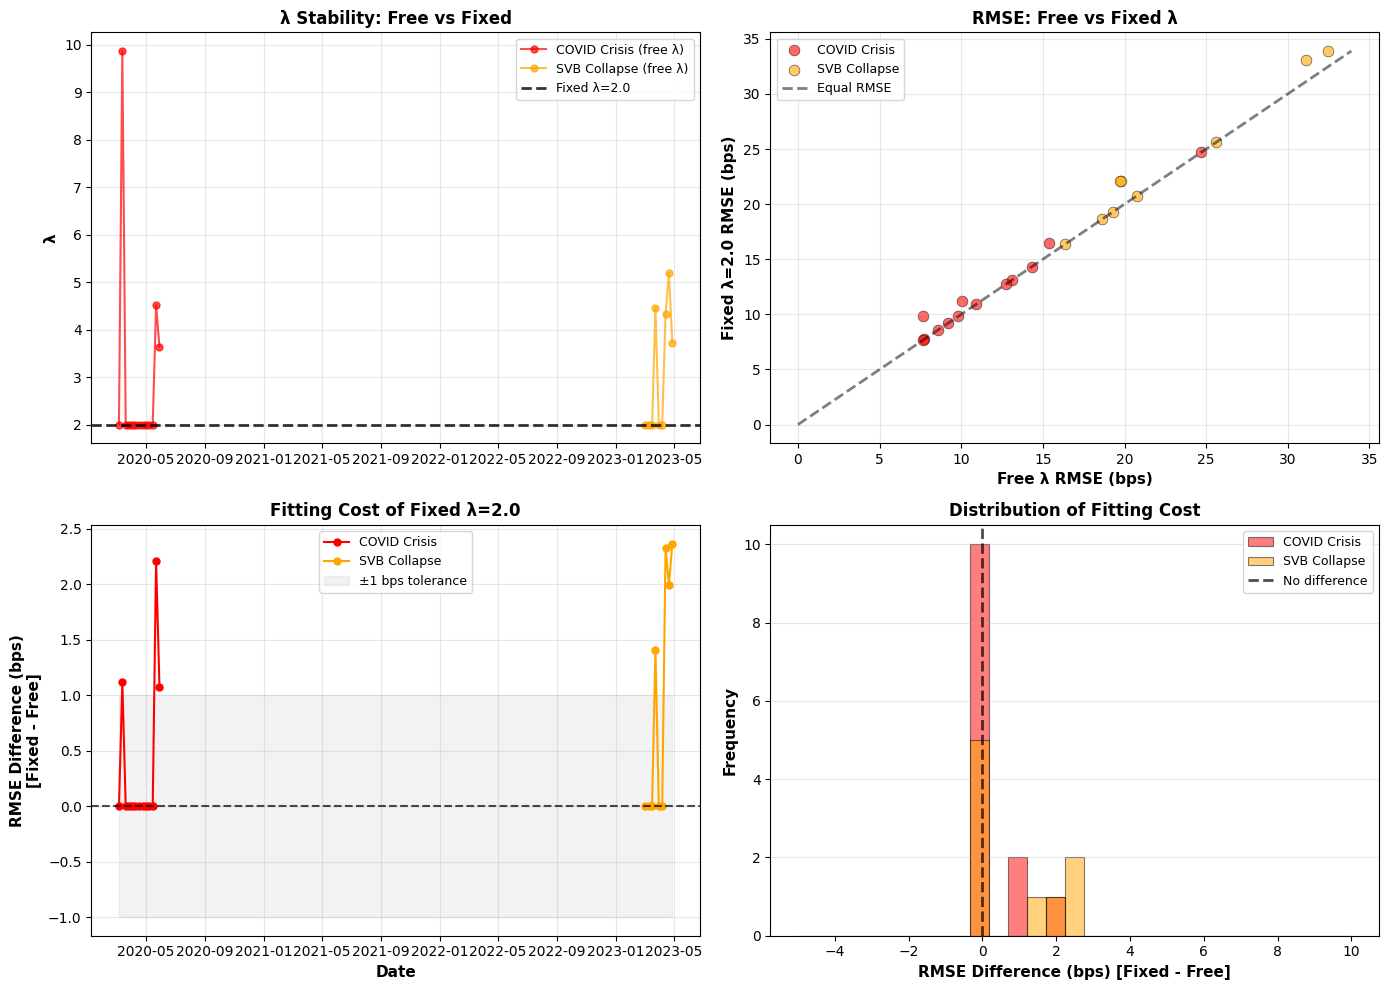

In [160]:
# Visualization of fixed vs free λ trade-offs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: λ stability comparison
ax = axes[0, 0]
for period_name in ['COVID Crisis', 'SVB Collapse']:
    period_data = fixed_vs_free_df[fixed_vs_free_df['period'] == period_name]
    color = 'red' if period_name == 'COVID Crisis' else 'orange'
    ax.plot(period_data['date'], period_data['free_lambda'], 
            'o-', label=f'{period_name} (free λ)', 
            color=color, linewidth=1.5, markersize=5, alpha=0.7)
ax.axhline(2.0, color='black', linestyle='--', linewidth=2, 
           label='Fixed λ=2.0', alpha=0.8)
ax.set_ylabel('λ', fontsize=11, fontweight='bold')
ax.set_title('λ Stability: Free vs Fixed', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: RMSE comparison scatter
ax = axes[0, 1]
for period_name, color in [('COVID Crisis', 'red'), ('SVB Collapse', 'orange')]:
    period_data = fixed_vs_free_df[fixed_vs_free_df['period'] == period_name]
    ax.scatter(period_data['free_rmse'], period_data['fixed_rmse'], 
              s=60, alpha=0.6, color=color, edgecolors='black', linewidths=0.5,
              label=period_name)
max_rmse = max(fixed_vs_free_df['free_rmse'].max(), fixed_vs_free_df['fixed_rmse'].max())
ax.plot([0, max_rmse], [0, max_rmse], 'k--', linewidth=2, alpha=0.5, label='Equal RMSE')
ax.set_xlabel('Free λ RMSE (bps)', fontsize=11, fontweight='bold')
ax.set_ylabel('Fixed λ=2.0 RMSE (bps)', fontsize=11, fontweight='bold')
ax.set_title('RMSE: Free vs Fixed λ', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: RMSE difference over time
ax = axes[1, 0]
for period_name, color in [('COVID Crisis', 'red'), ('SVB Collapse', 'orange')]:
    period_data = fixed_vs_free_df[fixed_vs_free_df['period'] == period_name]
    ax.plot(period_data['date'], period_data['rmse_diff'], 
            'o-', label=period_name, color=color, linewidth=1.5, markersize=5)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.fill_between(fixed_vs_free_df['date'], -1, 1, alpha=0.1, color='gray', 
                label='±1 bps tolerance')
ax.set_ylabel('RMSE Difference (bps)\n[Fixed - Free]', fontsize=11, fontweight='bold')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_title('Fitting Cost of Fixed λ=2.0', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 4: Distribution of RMSE differences
ax = axes[1, 1]
bins = np.linspace(-5, 10, 30)
for period_name, color in [('COVID Crisis', 'red'), ('SVB Collapse', 'orange')]:
    period_data = fixed_vs_free_df[fixed_vs_free_df['period'] == period_name]
    ax.hist(period_data['rmse_diff'], bins=bins, alpha=0.5, 
            color=color, edgecolor='black', linewidth=0.8, label=period_name)
ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='No difference')
ax.set_xlabel('RMSE Difference (bps) [Fixed - Free]', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Fitting Cost', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Analysis and Discussion

#### Parameter behavior during stress

**COVID crisis (Mar–May 2020)**  
- **β₀ (level):** Substantial week-to-week changes (std ~33 bps, max |Δ| ~71 bps), reflecting rapid shifts in rates.
- **β₁ (slope):** Remained negative throughout, with notable variability (std ~35 bps, max |Δ| ~96 bps).
- **β₂ (curvature):** Most volatile parameter (std ~74 bps, max |Δ| ~165 bps), indicating instability in curve shape.
- **λ (decay):** Typically near 2.0, but with one major spike (max ~9.87, close to upper bound but not hitting it); overall mean λ = 2.93, std = 2.23.
- **Fit quality (RMSE):** Deteriorated relative to baseline (mean RMSE from 9.34 to 11.68 bps, +25.1%), with a maximum crisis RMSE of 24.70 bps.

**SVB collapse (Mar–Apr 2023)**  
- **β₀ (level):** Higher overall (around 3.6–4.6%) with moderate variability (std ~45 bps, max |Δ| ~72 bps).
- **β₁ (slope):** Largely positive—different regime than 2020—with significant variability (std ~67 bps, max |Δ| ~112 bps).
- **β₂ (curvature):** Volatile (std ~115 bps, max |Δ| ~190 bps), similar to COVID.
- **λ (decay):** More stable (mean λ = 3.08, std = 1.33), no bound hits, modest number of large jumps.
- **Fit quality (RMSE):** Worsened notably (mean RMSE from 15.62 to 22.64 bps, +44.9%), max RMSE 32.48 bps.

**Takeaway:** The **shape parameters** (especially β₂) are the biggest sources of short-term instability in both stress periods. **λ** is generally well-behaved, with occasional discrete jumps (notably during COVID).

---

#### Is Nelson–Siegel robust enough for production during stress?

**Mostly yes, with monitoring.** The results show:
- λ is not consistently pinned to its constraint bounds—even in stress (COVID spike stays inside bounds).
- All parameters remain finite and interpretable during stress, though the curve shape (β₂) is inherently noisy week-to-week.
- RMSE increases substantially in stressful periods: +25% (COVID), +45% (SVB), sometimes spiking to 25–32 bps. This signals degraded fit, but the model remains usable.

**Implication for production:** Use RMSE as a health metric. Continue NS modeling through stress, but flag or handle weeks with large RMSE jumps and do not expect baseline fits comparable to calmer periods.

---

#### Would fixing λ at a constant improve stability? At what cost?

**Yes—fixing λ improves operational stability, at a small and quantifiable cost in fit.**

From the fixed-vs-free λ (fixed at 2.0) comparison:
- **COVID:** mean RMSE rises from 11.679 to 12.018 bps; penalty +0.339 bps (+3.61%).
- **SVB:** mean RMSE rises from 22.641 to 23.541 bps; penalty +0.900 bps (+3.84%).
- **Overall (22 stress weeks):** avg penalty +0.568 bps (+3.70%). In only 4 of 22 weeks (18.2%) does fixed λ perform better; free λ yields better fit most of the time.

**Interpretation:** The cost of fixing λ is typically an increase of ~0.3–0.9 bps in RMSE during stress, or about 3–4%. This is generally negligible relative to overall stress-period RMSEs, which are often >10–20 bps.

**Recommendation:**  
- For reliability and reproducibility, **fixed λ = 2.0 is defensible**.
- For tighter fit, use **free λ** but add guardrails—monitor for extreme λ jumps and large RMSEs.

## Use of AI

Generative AI tools were used as part of the development workflow for this project. In particular, **ChatGPT** and **Claude** were used to broadly support coding productivity and analysis.

Their contributions included:
- Assisting with the design and refinement of Python functions used for model estimation, diagnostics, and validation
- Helping structure and automate plotting routines for visualizing fits, residuals, and sanity checks
- Supporting exploratory analysis and iteration by speeding up code generation and refactoring